In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
#warnings.filterwarnings("ignore")

In [2]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [ ]:
## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [4]:
import geopandas as gpd

In [5]:
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

In [12]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [13]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [14]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [15]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


#estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
#estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<?, ?it/s]


In [16]:
# Read the dataset network
estreams_attributes_clipped_filters = pd.read_csv(R'..\data\network_estreams_moselle_108_gauges.csv', encoding='utf-8')
estreams_attributes_clipped_filters.set_index("basin_id", inplace = True)
estreams_attributes_clipped_filters

Unnamed: 0    gauge_id            gauge_name gauge_country  \
basin_id                                                               
LU000018           0           5            Schoenfels            LU   
LU000010           1           6             Hunnebuer            LU   
LU000001           2          17            Bigonville            LU   
DERP2028           3  2674030900          Eisenschmitt            DE   
FR000183           4  A900105050              A9001050            FR   
...              ...         ...                   ...           ...   
FR003271         107  A782101001   La Seille Ã  Nomeny            FR   
FR003301         108  A930108040  La Sarre Ã  Wittring            FR   
DERP2003         109  2620050500            Bollendorf            DE   
DEBU1958         110    26500100    BundespegelTrierUp            DE   
FR000184         111  A901305050              A9013050            FR   

          gauge_provider                                river  lon_snap  \
basin_id                                                                  
LU000018  LU_CONTACTFORM                                Mamer  6.100795   
LU000010  LU_CONTACTFORM                                Eisch  6.079524   
LU000001  LU_CONTACTFORM                                 Sure  5.801399   
DERP2028           DE_RP                                 Salm  6.718000   
FR000183    FR_EAUFRANCE  La Sarre à Laneuveville-lès-Lorquin  7.008689   
...                  ...                                  ...       ...   
FR003271    FR_EAUFRANCE                   La Seille à Nomeny  6.227788   
FR003301    FR_EAUFRANCE                  La Sarre à Wittring  7.150066   
DERP2003           DE_RP                                Sauer  6.359000   
DEBU1958           DE_BU                                Mosel  6.627000   
FR000184    FR_EAUFRANCE        La Sarre Rouge à Vasperviller  7.060836   

           lat_snap       lon        lat  ...  irri_1990  irri_2005  \
basin_id                                  ...                         
LU000018  49.723112  6.100795  49.723112  ...      0.015      0.015   
LU000010  49.729184  6.079524  49.729184  ...      0.026      0.026   
LU000001  49.869821  5.801399  49.869821  ...      0.000      0.000   
DERP2028  50.048000  6.718000  50.048000  ...      0.000      0.000   
FR000183  48.654579  7.008689  48.654579  ...      0.000      0.000   
...             ...       ...        ...  ...        ...        ...   
FR003271  48.888271  6.227788  48.888271  ...      0.429      0.436   
FR003301  49.053225  7.150066  49.053225  ...      0.436      2.205   
DERP2003  49.851000  6.359000  49.851000  ...      1.627      4.160   
DEBU1958  49.732000  6.627000  49.732000  ...     10.862     12.761   
FR000184  48.640785  7.064290  48.640085  ...      0.000      0.000   

          stations_num_p_mean  perm_high_regi  perm_medium_regi perm_low_regi  \
basin_id                                                                        
LU000018                 17.0            39.0              61.0           0.0   
LU000010                 16.0            42.0              58.0           0.0   
LU000001                  9.0             1.0               0.0          99.0   
DERP2028                 10.0            80.0               7.0          13.0   
FR000183                  4.0            66.0              29.0           5.0   
...                       ...             ...               ...           ...   
FR003271                  5.0             8.0              92.0           0.0   
FR003301                 16.0            17.0              83.0           0.0   
DERP2003                 65.0            17.0              30.0          53.0   
DEBU1958                219.0            25.0              60.0          15.0   
FR000184                  5.0            98.0               2.0           0.0   

         perm_high_glob2  perm_medium_glob2  perm_low_glob2    group  
basin_id                                        

In [4]:
# Python implementation
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [5]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)

In [6]:
    import numba as nb
    from superflexpy.framework.element import ODEsElement
    from copy import deepcopy
    import numba as nb
    from superflexpy.framework.element import ODEsElement
    from copy import deepcopy

    class CustomUnsaturatedReservoir(UnsaturatedReservoir):
        """
        This class implements the UnsaturatedReservoir of HBV.
        """

        def __init__(self, parameters, states, approximation, id):
            
            """
            This is the initializer of the class UnsaturatedReservoir.

            Parameters
            ----------
            parameters : dict
                Parameters of the element. The keys must be:
                'Smax' : maximum reservoir storage
                'Ce' : Potential evapotranspiration multiplier
                'm' : Smoothing factor for evapotranspiration
                'beta' : Exponent in the relation for the streamflow
            states : dict
                Initial state of the element. The keys must be:
                - 'S0' : initial storage of the reservoir.
            approximation : superflexpy.utils.numerical_approximation.NumericalApproximator
                Numerial method used to approximate the differential equation
            id : str
                Itentifier of the element. All the elements of the framework must
                have an id.
            """

            ODEsElement.__init__(self, parameters=parameters, states=states, approximation=approximation, id=id)

            self._fluxes_python = [self._fluxes_function_python]

            if approximation.architecture == "numba":
                self._fluxes = [self._fluxes_function_numba]
            elif approximation.architecture == "python":
                self._fluxes = [self._fluxes_function_python]


        # METHODS FOR THE USER

        def set_input(self, input):
            """
            Set the input of the element.

            Parameters
            ----------
            input : list(numpy.ndarray)
                List containing the input fluxes of the element. It contains 2
                fluxes:
                1. Rainfall
                2. PET
            """

            self.input = {"P": input[0], "PET": input[1]}

        def get_output(self, solve=True):
            """
            This method solves the differential equation governing the routing
            store.

            Returns
            -------
            list(numpy.ndarray)
                Output fluxes in the following order:
                1. Streamflow (Q)
            """

            if solve:
                self._solver_states = [self._states[self._prefix_states + "S0"]]

                self._solve_differential_equation()

                # Update the state
                self.set_states({self._prefix_states + "S0": self.state_array[-1, 0]})

            fluxes = self._num_app.get_fluxes(
                fluxes=self._fluxes_python,
                S=self.state_array,
                S0=self._solver_states,
                dt=self._dt,
                **self.input,
                **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
            )

            return [-fluxes[0][2]]

        def get_AET(self):
            """
            This method calculates the actual evapotranspiration

            Returns
            -------
            numpy.ndarray
                Array of actual evapotranspiration
            """

            try:
                S = self.state_array
            except AttributeError:
                message = "{}get_aet method has to be run after running ".format(self._error_message)
                message += "the model using the method get_output"
                raise AttributeError(message)

            fluxes = self._num_app.get_fluxes(
                fluxes=self._fluxes_python,
                S=S,
                S0=self._solver_states,
                dt=self._dt,
                **self.input,
                **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
            )

            return [-fluxes[0][1]]

        # PROTECTED METHODS

        @staticmethod
        def _fluxes_function_python(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
            # TODO: handle time variable parameters (Smax) -> overflow
            Smax = Csmax * bacon

            if ind is None:
                return (
                    [
                        P,
                        -Ce * PET * ((S / Smax) * (1 + m)) / ((S / Smax) + m),
                        -P * (S / Smax) ** beta,
                    ],
                    0.0,
                    S0 + P * dt,
                )
            else:
                Smax[ind] = Csmax[ind] * bacon[ind]

                return (
                    [
                        P[ind],
                        -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                        -P[ind] * (S / Smax[ind]) ** beta[ind],
                    ],
                    0.0,
                    S0 + P[ind] * dt[ind],
                    [
                        0.0,
                        -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                        -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
                    ],
                )

        @staticmethod
        @nb.jit(
            "Tuple((UniTuple(f8, 3), f8, f8,UniTuple(f8, 3)))"
            "(optional(f8), f8, i4, f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:])",
            nopython=True,
        )
        def _fluxes_function_numba(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
            # TODO: handle time variable parameters (Smax) -> overflow
            Smax = Csmax * bacon
            
            return (
                (
                    P[ind],
                    -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                    -P[ind] * (S / Smax[ind]) ** beta[ind],
                ),
                0.0,
                S0 + P[ind] * dt[ind],
                (
                    0.0,
                    -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                    -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
                ),
            )


In [7]:
import os
import glob

# Dictionary to store all parameter dicts
all_param_dicts = {}

# Loop through all CSVs in the current directory
for filepath in glob.glob("../results/groups/*moselle*.csv"):
    file_key = os.path.splitext(os.path.basename(filepath))[0]  # Strip .csv
    
    param_dict = {}

    # Read file and parse lines
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(","):  # Skip empty or malformed lines
                continue
            parts = line.split(",")
            if len(parts) == 2:
                key, value = parts
                try:
                    param_dict[key] = float(value)
                except ValueError:
                    pass  # Skip lines where value is not a float
            else:
                pass  # Skip malformed lines

    # Store the parsed dictionary
    all_param_dicts[file_key] = param_dict


In [8]:
all_param_dicts.keys()

dict_keys(['moselle_best_params_contcomp_Group_1', 'moselle_best_params_contcomp_Group_1_2', 'moselle_best_params_contcomp_Group_2', 'moselle_best_params_contcomp_Group_2_2', 'moselle_best_params_contcomp_Group_3', 'moselle_best_params_contcomp_Group_3_2', 'moselle_best_params_contcomp_Group_4', 'moselle_best_params_contcomp_Group_4_2', 'moselle_best_params_contcomp_Group_5', 'moselle_best_params_contcomp_Group_5_2', 'moselle_best_params_contcomp_Group_6', 'moselle_best_params_contcomp_Group_6_2', 'moselle_best_params_contcomp_Group_7', 'moselle_best_params_contcomp_Group_7_2', 'moselle_best_params_globcomp_Group_1', 'moselle_best_params_globcomp_Group_1_2', 'moselle_best_params_globcomp_Group_2', 'moselle_best_params_globcomp_Group_2_2', 'moselle_best_params_globcomp_Group_3', 'moselle_best_params_globcomp_Group_3_2', 'moselle_best_params_globcomp_Group_4', 'moselle_best_params_globcomp_Group_4_2', 'moselle_best_params_globcomp_Group_5', 'moselle_best_params_globcomp_Group_5_2', 'mose

In [9]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()
prec_mean= [1,2]


In [10]:
catchments_ids = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [26]:
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']


    root_finder = PegasusNumba()
    num_app = ImplicitEulerNumba(root_finder=root_finder)

    class ParameterizedSingleFluxSplitter(ParameterizedElement):
        _num_downstream = 2
        _num_upstream = 1
        
        def set_input(self, input):

            self.input = {'Q_in': input[0]}

        def get_output(self, solve=True):

            split_par = self._parameters[self._prefix_parameters + 'splitpar']

            output1 = [self.input['Q_in'] * split_par]
            output2 = [self.input['Q_in'] * (1 - split_par)]
            
            return [output1, output2]   
        
        
    lower_splitter = ParameterizedSingleFluxSplitter(
        parameters={'splitpar': 0.5},
        id='lowersplitter'
    )

    lower_splitter_medium = ParameterizedSingleFluxSplitter(
        parameters={'splitpar': 0.6},
        id='lowersplitter'
    )

    lower_splitter_high = ParameterizedSingleFluxSplitter(
        parameters={'splitpar': 0.7},
        id='lowersplitter'
    )

    # Fluxes in the order P, T, PET
    upper_splitter = Splitter(
        direction=[
            [0, 1, None],    # P and T go to the snow reservoir
            [2, None, None]  # PET goes to the transparent element
        ],
        weight=[
            [1.0, 1.0, 0.0],
            [0.0, 0.0, 1.0]
        ],
        id='upper-splitter'
    )

    snow = SnowReservoir(
        parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='snow'
    )

    upper_transparent = Transparent(
        id='upper-transparent'
    )

    upper_junction = Junction(
        direction=[
            [0, None],
            [None, 0]
        ],
        id='upper-junction'
    )



    fast = PowerReservoir(
        parameters={'k': 0.01, 'alpha': 2.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='fast'
    )

    slow = PowerReservoir(
        parameters={'k': 1e-4, 'alpha': 1.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='slow'
    )

    slowhigh = PowerReservoir(
        parameters={'k': 1e-4, 'alpha': 2.0},
        states={'S0': 0.0},
        approximation=num_app,
        id='slowhigh'
    )


    lower_junction = Junction(
        direction=[
            [0, 0]
        ],
        id='lower-junction'
    )

    lag_fun = HalfTriangularLag(
        parameters={'lag-time': 4.0},
        states={'lag': None},
        id='lag-fun'
    )

    lower_transparent = Transparent(
        id='lower-transparent'
    )

    lower_transparent2 = Transparent(
        id='lower-transparent2'
    )

    general = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='general'
    )

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='low'
    )

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='high'
    )

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:

        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': rootdepth_mean[cat_id]},
            states={'S0': 10.0},
            approximation=num_app,
            id='unsaturated')
        
        general = Unit(
            layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
            ],
            id='general'
            )

        low = Unit(
            layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
            ],
            id='low'
            )

        high = Unit(
            layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
            ],
            id='high'
            )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node

    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )


    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs


    def assign_parameter_values(parameters_name_model, parameter_names, parameters):
        """
        Assigns values from `parameters` to `parameters_name_model` where a match exists in `parameter_names`,
        but keeps any parameters that have three segments (`X_Y_Z`) unchanged.

        Args:
            parameters_name_model (list): List of full parameter names (e.g., "general_slow_k").
            parameter_names (list): List of unique parameter names (e.g., "slow_k", "high_slow_k").
            parameters (list): List of values corresponding to `parameter_names`.

        Returns:
            dict: Dictionary {parameter_name_model: assigned_value}, where:
                - `X_Y` parameters are updated from `parameter_names`.
                - `X_Y_Z` parameters are kept unchanged.
        """
        # Create a dictionary mapping parameter_names to their corresponding values
        param_value_dict = {param_name: value for param_name, value in zip(parameter_names, parameters)}

        # Build the output dictionary
        filtered_parameters = {}

        for param_name in parameters_name_model:
            parts = param_name.split("_")  # Split the name to check structure
            base_name = "_".join(parts[-2:])  # Extract last two parts (X_Y)
            
            if base_name in param_value_dict:  # If X_Y is in parameter_names
                filtered_parameters[param_name] = param_value_dict[base_name]
            elif param_name in parameter_names:  # Direct match in parameter_names (X_Y)
                filtered_parameters[param_name] = param_value_dict[param_name]
        
        return filtered_parameters  # Return dictionary of matched parameters


    class spotpy_model(object):

        def __init__(self, model, catchments, dt, observations, parameters, parameter_names, parameter_names_model, output_index, warm_up, prec_mean):

            """
            Spotpy model for multi-node calibration in SuperflexPy.

            Args:
                model (Network): SuperflexPy network containing multiple nodes.
                catchments (list): List of Node objects.
                inputs (dict): Dictionary with inputs for each node.
                dt (float): Time step.
                observations (dict): Observed discharge data for each node.
                parameters (list): List of parameter distributions for calibration.
                parameter_names (list): Names of the parameters.
                output_index (str/int): The output key for extracting model results.
                warm_up (int): Number of time steps to ignore in the evaluation.
            """
            self._model = model  # The SuperflexPy network
            self._catchments = catchments  # List of catchments
            self._dt = dt  # Time step

            # Store shared calibration parameters
            self._parameters = parameters
            self._parameter_names = parameter_names
            self._parameter_names_model = parameter_names_model  # Store full parameter names

            # Store inputs and observations for each node
            self._observations = observations  # Dictionary {node_id: observed_data}
            self._output_index = output_index  # Output key (e.g., 'Q_out')
            self._warm_up = int(warm_up)  # Warm-up period

        def parameters(self):
            """Generate parameter samples for calibration."""
            return spotpy.parameter.generate(self._parameters)

        def simulation(self, parameters):
            """Runs the entire network using the same parameter set and collects per-node outputs."""

            # Convert parameter list into a dictionary
            #named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
            
            # Check if parameters have changed (avoid unnecessary computations)
            if not hasattr(self, "_cached_params") or not np.array_equal(self._cached_params, parameters):
                self._cached_params = np.array(parameters)  # Store the current parameters
                named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
                self._model.set_parameters(named_parameters)  # Apply shared parameters

            # Apply shared parameters to the whole network (this is due to the way we set Csumax)
            for key in model._content_pointer.keys():
                i = model._content_pointer[key] 
                self._model._content[i].set_parameters(named_parameters)
            #self._model.set_parameters(named_parameters)

            # Set timestep and reset the network
            self._model.set_timestep(self._dt)
            self._model.reset_states()

            # Run the full network
            output = self._model.get_output()  # Get outputs for all nodes

            # Return outputs as a list (one per node)
            return [output[cat.id][self._output_index] for cat in self._catchments]

        def evaluation(self):
            """Returns the observed data for all nodes."""
            return self._observations

        def objectivefunction(self, simulation, evaluation):
            """Computes the average NSE (or another metric) across all nodes."""

            obj_values = []  # Store individual NSE values for each node

            for sim, cat in zip(simulation, self._catchments):
                node_id = cat.id
                obs = evaluation[node_id]

                # Apply warm-up period
                sim = sim[self._warm_up + 1:]
                obs = obs[self._warm_up + 1:]

                # Compute NSE (or another metric like KGE)
                obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
                obj_values.append(obj_value)

            # Compute the average objective function across all nodes
            return np.mean(obj_values)  # Minimize the average error

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  10  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 10, minimal objective function=1.6967, time remaining: 00:00:37
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'teste.csv' created.
2 of 10, minimal objective function=1.6967, time remaining: 00:00:39
3 of 10, minimal objective function=1.6967, time remaining: 00:00:35
4 of 10, minimal objective function=1.6967, time remaining: 00:00:31
5 of 10, minimal objective function=0.843015, time remaining: 00:00:25
6 of 10, minimal objective function=0.843015, time remaining: 00:00:19
7 of 10, minimal objective function=0.843015, time remaining: 00:00:13
8 of 10, minimal objective function=0.818692, time remaining: 00:00:07
9 of 10, minimal objective function=0.818692, time remaining: 00:00:00
10 of 10, minimal objective function=0.818692, time remaining: 23:59:53
Stopping samplig. Maximum numb

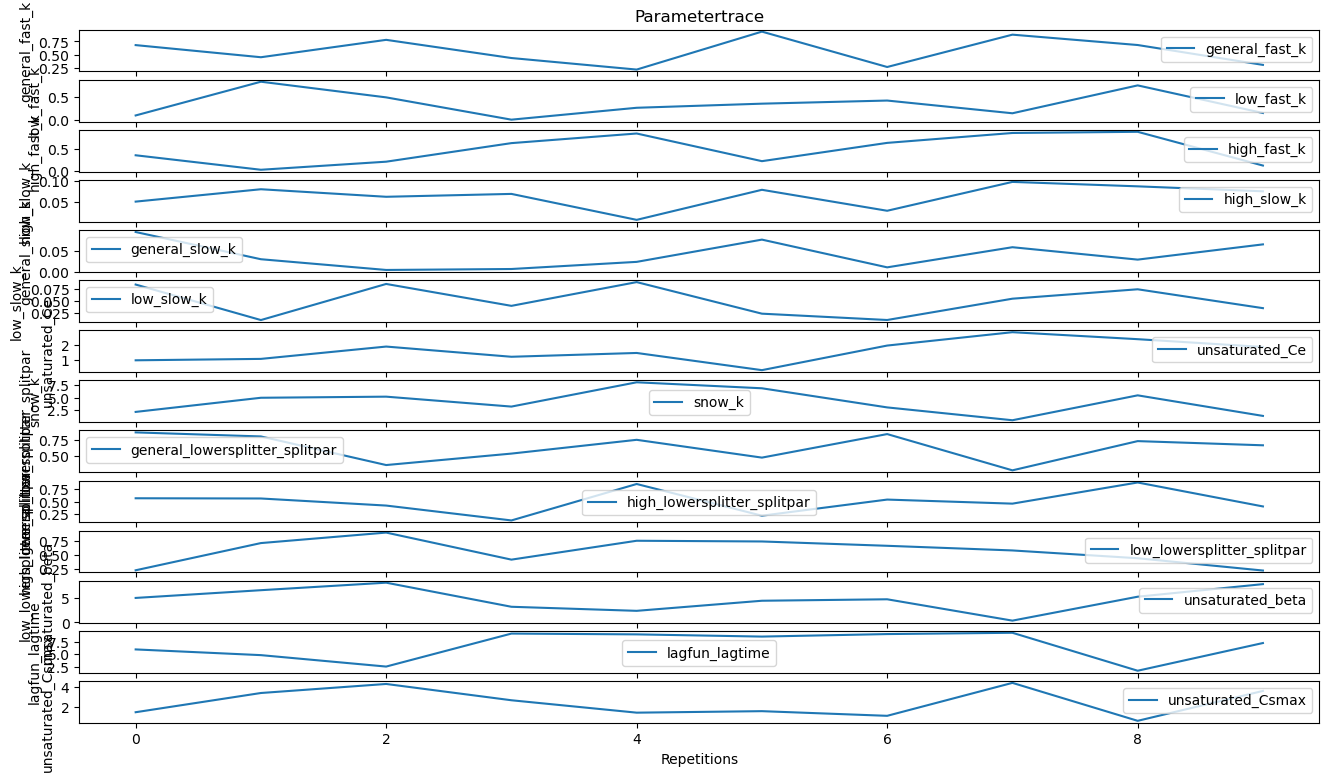

In [27]:
    spotpy_hyd_mod = spotpy_model(
        model=model,  # The entire SuperflexPy network
        catchments=catchments,  # Use predefined catchments list
        dt=1.0,  # Time step
        observations=observations,  # Observed data per node
        parameters=[
            spotpy.parameter.Uniform("general_fast_k", 0.0001, 1.0), #1e-5, 1.0
            spotpy.parameter.Uniform("low_fast_k", 0.0001, 1.0),
            spotpy.parameter.Uniform("high_fast_k", 0.0001, 1.0),

            spotpy.parameter.Uniform("high_slow_k", 1e-7, 0.1),
            spotpy.parameter.Uniform("general_slow_k", 1e-7, 0.1),
            spotpy.parameter.Uniform("low_slow_k", 1e-7, 0.1),

            spotpy.parameter.Uniform("unsaturated_Ce", 0.1, 3.0),
            spotpy.parameter.Uniform("snow_k", 0.01, 10.0),

            spotpy.parameter.Uniform("general_lowersplitter_splitpar", 0.1, 0.9),
            spotpy.parameter.Uniform("high_lowersplitter_splitpar", 0.1, 0.9),
            spotpy.parameter.Uniform("low_lowersplitter_splitpar", 0.1, 0.9),
            
            spotpy.parameter.Uniform("unsaturated_beta", 0.01, 10.0),
            spotpy.parameter.Uniform("lag-fun_lag-time", 1.0, 10.0),
            spotpy.parameter.Uniform("unsaturated_Csmax", 0.5, 5.0),  # Global calibration parameter

        ],
        parameter_names=[
            "general_fast_k", "low_fast_k", "high_fast_k",
            "high_slow_k", "general_slow_k", "low_slow_k", "unsaturated_Ce", "snow_k", "general_lowersplitter_splitpar", "high_lowersplitter_splitpar", "low_lowersplitter_splitpar",
            "unsaturated_beta", "lag-fun_lag-time","unsaturated_Csmax",
        ],
        parameter_names_model = model.get_parameters_name(),
        output_index=0,  # Assumes all nodes have the same output variable
        warm_up=365,  # Warm-up period
        prec_mean=prec_mean

    )

    #sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
    sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname='teste', dbformat='csv')

    sampler.sample(repetitions=10)
    
    results = spotpy.analyser.load_csv_results('teste')

    #results = sampler.getdata()                                                  # Load the results
    spotpy.analyser.plot_parametertrace(results)                                 # Show the results

    bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function


    spotpy.analyser.get_parameters(results)[bestindex]

    best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))

    #if 'splitpar' in best_params_dict:
    #    best_params_dict['general_lowersplitter_splitpar'] = best_params_dict.pop('splitpar')

    # Remove spaces and replace with underscores (or any other transformation)
    best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

    parameter_names = list(best_params_dict.keys())
    parameters = list(best_params_dict.values())
    parameter_names_model = model.get_parameters_name()
    best_params_dict_model = assign_parameter_values(parameter_names_model, parameter_names, parameters)

In [28]:
best_params_dict

{'general_fast_k': 0.8773445,
 'low_fast_k': 0.14376956,
 'high_fast_k': 0.8542455,
 'high_slow_k': 0.097595304,
 'general_slow_k': 0.058078565,
 'low_slow_k': 0.05484915,
 'unsaturated_Ce': 2.8430805,
 'snow_k': 0.47861877,
 'general_lowersplitter_splitpar': 0.28023326,
 'high_lowersplitter_splitpar': 0.45918047,
 'low_lowersplitter_splitpar': 0.57742214,
 'unsaturated_beta': 0.3588628,
 'lagfun_lagtime': 9.367332,
 'unsaturated_Csmax': 4.4631577}

In [29]:

#best_params_dict['lag-fun_lag-time'] = best_params_dict.pop('lagfun_lagtime')

best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

parameter_names = list(best_params_dict.keys())
parameters = list(best_params_dict.values())
parameter_names_model = model.get_parameters_name()
best_params_dict_model = assign_parameter_values(parameter_names_model, parameter_names, parameters)


In [30]:
best_params_dict_model

{'high_snow_k': 0.47861877,
 'high_unsaturated_Csmax': 4.4631577,
 'high_unsaturated_Ce': 2.8430805,
 'high_unsaturated_beta': 0.3588628,
 'high_lowersplitter_splitpar': 0.45918047,
 'high_slow_k': 0.097595304,
 'high_fast_k': 0.8542455,
 'general_snow_k': 0.47861877,
 'general_unsaturated_Csmax': 4.4631577,
 'general_unsaturated_Ce': 2.8430805,
 'general_unsaturated_beta': 0.3588628,
 'general_lowersplitter_splitpar': 0.28023326,
 'general_slow_k': 0.058078565,
 'general_fast_k': 0.8773445,
 'low_snow_k': 0.47861877,
 'low_unsaturated_Csmax': 4.4631577,
 'low_unsaturated_Ce': 2.8430805,
 'low_unsaturated_beta': 0.3588628,
 'low_lowersplitter_splitpar': 0.57742214,
 'low_slow_k': 0.05484915,
 'low_fast_k': 0.14376956}

In [31]:
spotpy_hyd_mod._parameters

[Uniform('general_fast_k', [0.0001, 1.0]),
 Uniform('low_fast_k', [0.0001, 1.0]),
 Uniform('high_fast_k', [0.0001, 1.0]),
 Uniform('high_slow_k', [1e-07, 0.1]),
 Uniform('general_slow_k', [1e-07, 0.1]),
 Uniform('low_slow_k', [1e-07, 0.1]),
 Uniform('unsaturated_Ce', [0.1, 3.0]),
 Uniform('snow_k', [0.01, 10.0]),
 Uniform('general_lowersplitter_splitpar', [0.1, 0.9]),
 Uniform('high_lowersplitter_splitpar', [0.1, 0.9]),
 Uniform('low_lowersplitter_splitpar', [0.1, 0.9]),
 Uniform('unsaturated_beta', [0.01, 10.0]),
 Uniform('lag-fun_lag-time', [1.0, 10.0]),
 Uniform('unsaturated_Csmax', [0.5, 5.0])]

In [34]:
model[0].get_parameters()

TypeError: 'Network' object is not subscriptable

In [43]:
model._content[0].get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 1.3404280017067682,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 3.634001176021269,
 'high_unsaturated_Ce': 1.8629520665419077,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 7.801023321840083,
 'high_unsaturated_bacon': 85.281,
 'high_lowersplitter_splitpar': 0.4038720317942929,
 'high_slow_k': 0.07486076535649329,
 'high_slow_alpha': 1.0,
 'high_lag-fun_lag-time': 7.283665683241204,
 'high_fast_k': 0.12666510850587012,
 'high_fast_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 1.3404280017067682,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 3.634001176021269,
 'general_unsaturated_Ce': 1.8629520665419077,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 7.801023321840083,
 'general_unsaturated_bacon': 85.281,
 'general_lowersplitter_splitpar': 0.6621542939415943,
 'general_slow_k': 0.06481882500474127,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 7.283665683241204,
 'general_fast_k': 0.3136795

In [37]:
catchments_ids

['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [38]:
model._content_pointer["FR000184"]

0

In [ ]:
model._content_pointer["FR000184"]

In [36]:
model.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 5.008731698090756,
 'high_snow_m': 2.0,
 'high_unsaturated_Smax': 450.8693133015716,
 'high_unsaturated_Ce': 2.089371363959854,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 0.5647677354343631,
 'high_lowersplitter_splitpar': 0.5009935998145725,
 'high_slow_k': 0.042524224761547394,
 'high_slow_alpha': 1.0,
 'high_lag-fun_lag-time': 1.9121366227133292,
 'high_fast_k': 0.9482857433159764,
 'high_fast_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 5.008731698090756,
 'general_snow_m': 2.0,
 'general_unsaturated_Smax': 450.8693133015716,
 'general_unsaturated_Ce': 2.089371363959854,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 0.5647677354343631,
 'general_lowersplitter_splitpar': 0.2530023338193453,
 'general_slow_k': 0.0009108289851340306,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 1.9121366227133292,
 'general_fast_k': 0.5547711265710202,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k'

In [29]:
    def assign_parameter_values(parameters_name_model, parameter_names, parameters):
        """
        Assigns values from `parameters` to `parameters_name_model` where a match exists in `parameter_names`,
        but keeps any parameters that have three segments (`X_Y_Z`) unchanged.

        Args:
            parameters_name_model (list): List of full parameter names (e.g., "general_slow_k").
            parameter_names (list): List of unique parameter names (e.g., "slow_k", "high_slow_k").
            parameters (list): List of values corresponding to `parameter_names`.

        Returns:
            dict: Dictionary {parameter_name_model: assigned_value}, where:
                - `X_Y` parameters are updated from `parameter_names`.
                - `X_Y_Z` parameters are kept unchanged.
        """
        # Create a dictionary mapping parameter_names to their corresponding values
        param_value_dict = {param_name: value for param_name, value in zip(parameter_names, parameters)}

        # Build the output dictionary
        filtered_parameters = {}

        for param_name in parameters_name_model:
            parts = param_name.split("_")  # Split the name to check structure
            base_name = "_".join(parts[-2:])  # Extract last two parts (X_Y)
            
            if base_name in param_value_dict:  # If X_Y is in parameter_names
                filtered_parameters[param_name] = param_value_dict[base_name]
            elif param_name in parameter_names:  # Direct match in parameter_names (X_Y)
                filtered_parameters[param_name] = param_value_dict[param_name]
        
        return filtered_parameters  # Return dictionary of matched parameters

In [45]:
parameter_names=[
            "general_fast_k", "low_fast_k", "high_fast_k",
            "high_slow_k", "general_slow_k", "low_slow_k", "unsaturated_Ce", "snow_k", "unsaturated_Smax", "general_lowersplitter_splitpar", "high_lowersplitter_splitpar", "low_lowersplitter_splitpar",
            "unsaturated_beta", "lag-fun_lag-time",
        ]

In [ ]:
model.get_parameters()

In [37]:
parameter_names_model = model.get_parameters_name()
parameter_names_model

['high_snow_t0',
 'high_snow_k',
 'high_snow_m',
 'high_unsaturated_Smax',
 'high_unsaturated_Ce',
 'high_unsaturated_m',
 'high_unsaturated_beta',
 'high_lowersplitter_splitpar',
 'high_slow_k',
 'high_slow_alpha',
 'high_lag-fun_lag-time',
 'high_fast_k',
 'high_fast_alpha',
 'general_snow_t0',
 'general_snow_k',
 'general_snow_m',
 'general_unsaturated_Smax',
 'general_unsaturated_Ce',
 'general_unsaturated_m',
 'general_unsaturated_beta',
 'general_lowersplitter_splitpar',
 'general_slow_k',
 'general_slow_alpha',
 'general_lag-fun_lag-time',
 'general_fast_k',
 'general_fast_alpha',
 'low_snow_t0',
 'low_snow_k',
 'low_snow_m',
 'low_unsaturated_Smax',
 'low_unsaturated_Ce',
 'low_unsaturated_m',
 'low_unsaturated_beta',
 'low_lowersplitter_splitpar',
 'low_slow_k',
 'low_slow_alpha',
 'low_lag-fun_lag-time',
 'low_fast_k',
 'low_fast_alpha']

In [46]:
parameter_names

['general_fast_k',
 'low_fast_k',
 'high_fast_k',
 'high_slow_k',
 'general_slow_k',
 'low_slow_k',
 'unsaturated_Ce',
 'snow_k',
 'unsaturated_Smax',
 'general_lowersplitter_splitpar',
 'high_lowersplitter_splitpar',
 'low_lowersplitter_splitpar',
 'unsaturated_beta',
 'lag-fun_lag-time']

In [42]:
parameters_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [47]:
filteres_parameters = assign_parameter_values(parameter_names_model, parameter_names, parameters_1)

In [48]:
filteres_parameters

{'high_snow_k': 7,
 'high_unsaturated_Smax': 8,
 'high_unsaturated_Ce': 6,
 'high_unsaturated_beta': 12,
 'high_lowersplitter_splitpar': 10,
 'high_slow_k': 3,
 'high_lag-fun_lag-time': 13,
 'high_fast_k': 2,
 'general_snow_k': 7,
 'general_unsaturated_Smax': 8,
 'general_unsaturated_Ce': 6,
 'general_unsaturated_beta': 12,
 'general_lowersplitter_splitpar': 9,
 'general_slow_k': 4,
 'general_lag-fun_lag-time': 13,
 'general_fast_k': 0,
 'low_snow_k': 7,
 'low_unsaturated_Smax': 8,
 'low_unsaturated_Ce': 6,
 'low_unsaturated_beta': 12,
 'low_lowersplitter_splitpar': 11,
 'low_slow_k': 5,
 'low_lag-fun_lag-time': 13,
 'low_fast_k': 1}

In [ ]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
        id='low')

    high = Unit(
        layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output



def generate_nse_results(catchments_ids, daterange, output, observations, quality_masks):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        hydro_year = calculate_hydro_year(date=Qtimeseries.index, first_month=10)

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
                
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        qmean_obs = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])
        qmean_sim = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])
        
        try:

            slope_obs = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])["Sawicz"]
            slope_sim = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])["Sawicz"]
        except: 
            slope_obs = np.nan
            slope_sim = np.nan
        
        try:
            hfd_obs = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
            hfd_sim = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]

        except:
            hfd_obs = np.nan
            hfd_sim = np.nan

        try:            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi,
            "qmean_obs": qmean_obs,
            "qmean_sim": qmean_sim,
            "slope_obs": slope_obs,
            "slope_sim": slope_sim,
            "hfd_obs": hfd_obs,
            "hfd_sim": hfd_sim
            })

    # Convert results to DataFrame
    nse_results_df = pd.DataFrame(nse_results_cal)

    return nse_results_df

import re

def is_valid_key(k):
    # Exclude keys that end in Group_X_2
    return not re.search(r'Group_\d+_2$', k)

def is_valid_key_2(k):
    # Include only keys that end in Group_X_2
    return re.search(r'Group_\d+_2$', k)

## Model all time-series using all possible combinations of params

In [16]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_regional_dict = {}
output_continental_dict = {}
output_global_dict = {}

for key in tqdm.tqdm(regional_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict[key] = output

for key in tqdm.tqdm(continental_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict[key] = output

for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict[key] = output

100%|██████████| 7/7 [02:12<00:00, 18.87s/it]


In [17]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_regional_dict_8801 = {}
output_continental_dict_8801 = {}
output_global_dict_8801 = {}

for key in tqdm.tqdm(regional_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict_8801[key] = output

for key in tqdm.tqdm(continental_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict_8801[key] = output

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict_8801[key] = output

100%|██████████| 7/7 [02:09<00:00, 18.48s/it]


In [18]:
# Create the concatenated data for the complete series analysis
path_inputs = '../data/models/input/subset_1988_2001'
observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'
observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

In [19]:
output_global_dict_cal = {}

for param_key in output_global_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_8801:
        merged_outputs = {}

        for gauge_id in output_global_dict[param_key]:
            if gauge_id in output_global_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_cal[param_key] = merged_outputs

In [20]:
output_continental_dict_cal = {}

for param_key in output_continental_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_continental_dict_8801:
        merged_outputs = {}

        for gauge_id in output_continental_dict[param_key]:
            if gauge_id in output_continental_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_continental_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_continental_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_continental_dict_cal[param_key] = merged_outputs

In [21]:
output_regional_dict_cal = {}

for param_key in output_regional_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_regional_dict_8801:
        merged_outputs = {}

        for gauge_id in output_regional_dict[param_key]:
            if gauge_id in output_regional_dict_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_regional_dict_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_regional_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_regional_dict_cal[param_key] = merged_outputs

In [22]:
date_range = pd.date_range("1988-10-01", "2015-09-30", freq="D")

nse_results_global_dict_cal = {}
for key in tqdm.tqdm(output_global_dict_cal):
    nse_results_global_dict_cal[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_global_dict_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_global_dict_cal[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_continental_dict_cal = {}
for key in tqdm.tqdm(output_continental_dict_cal):
    nse_results_continental_dict_cal[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_continental_dict_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_continental_dict_cal[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_regional_dict_cal = {}
for key in tqdm.tqdm(output_regional_dict_cal):
    nse_results_regional_dict_cal[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_regional_dict_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_regional_dict_cal[key].drop_duplicates(subset='basin', keep='first', inplace=True)

100%|██████████| 7/7 [01:14<00:00, 10.57s/it]


In [23]:
nse_results_regional_dict_cal.keys()

dict_keys(['moselle_best_params_regi_Group_1', 'moselle_best_params_regi_Group_2', 'moselle_best_params_regi_Group_3', 'moselle_best_params_regi_Group_4', 'moselle_best_params_regi_Group_5', 'moselle_best_params_regi_Group_6', 'moselle_best_params_regi_Group_7'])

In [24]:
data_diff_cal_complete_dict = {}

groups_list = [1,2,3, 4,5,6,7]

for number_group in groups_list:

    Group_number = f"Group_"+str(number_group)

    nse_results_cal_r_1_100_complete_cal = nse_results_regional_dict_cal[f"moselle_best_params_regi_Group_{number_group}"]
    nse_results_cal_c_1_100_complete_cal = nse_results_continental_dict_cal[f"moselle_best_params_cont_Group_{number_group}"]
    nse_results_cal_g_1_100_complete_cal = nse_results_global_dict_cal[f"moselle_best_params_glob_Group_{number_group}"]

    list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == Group_number].index.tolist()

    # Remove strings starting with 'LU'
    list_cal = [g for g in list_cal if not g.startswith("LU")]


    data_diff_cal_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_c_1_100_complete_cal.nse)
    data_diff_cal_complete["nse_rg"] = nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_g_1_100_complete_cal.nse

    data_diff_cal_complete.index = nse_results_cal_c_1_100_complete_cal.basin

    data_diff_cal_complete = data_diff_cal_complete.loc[~data_diff_cal_complete.index.isin(list_cal)]

    data_diff_cal_complete["nse_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse
    data_diff_cal_complete["nse_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse
    data_diff_cal_complete["nse_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse

    data_diff_cal_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
    data_diff_cal_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
    data_diff_cal_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

    data_diff_cal_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_obs
    data_diff_cal_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
    data_diff_cal_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
    data_diff_cal_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim

    data_diff_cal_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_obs
    data_diff_cal_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
    data_diff_cal_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
    data_diff_cal_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim

    data_diff_cal_complete["slope_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_obs
    data_diff_cal_complete["slope_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
    data_diff_cal_complete["slope_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
    data_diff_cal_complete["slope_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).slope_sim

    data_diff_cal_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_obs
    data_diff_cal_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
    data_diff_cal_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
    data_diff_cal_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim

    data_diff_cal_complete_dict[Group_number] = data_diff_cal_complete

In [25]:
# List to store all DataFrames
dfs = list(data_diff_cal_complete_dict.values())

# Concatenate all, aligning by index and columns (outer join)
all_data = pd.concat(dfs, axis=0)

# Group by index and compute mean
data_diff_cal_complete = all_data.groupby(all_data.index).mean()

data_diff_cal_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.004011  0.238105  0.840477  0.844488  0.602372         NaN   
BEWA0067 -0.006290  0.160183  0.786864  0.793153  0.626681         NaN   
BEWA0106  0.000643  0.397206  0.779976  0.779333  0.382770         NaN   
BEWA0107 -0.004043  0.253120  0.734429  0.738472  0.481308         NaN   
BEWA0119 -0.005639  0.206364  0.815959  0.821598  0.609595         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.005622  0.423077  0.831265  0.825644  0.408188         NaN   
LU000016 -0.007572  0.043316  0.726632  0.734204  0.683316         NaN   
LU000017  0.001392  0.042253  0.868751  0.867359  0.826498         NaN   
LU000018  0.276768  0.019817  0.694001  0.417233  0.674183         NaN   
LU000019 -0.002007  0.166378  0.823882  0.825889  0.657504         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.573996  ...  1.354794  1.347175   
BEWA0067         NaN         NaN  0.446878  0.561839  ...  1.454498  1.441517   
BEWA0106         NaN         NaN  0.496805  0.576025  ...  1.073445  1.057375   
BEWA0107         NaN         NaN  0.565063  0.553150  ...  1.495473  1.474725   
BEWA0119         NaN         NaN  0.508101  0.564817  ...  1.390009  1.375960   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.569515  ...  1.060348  1.054085   
LU000016         NaN         NaN  0.564940  0.529946  ...  0.749355  0.746989   
LU000017         NaN         NaN  0.572433  0.599407  ...  0.937097  0.929370   
LU000018         NaN         NaN  0.549133  0.640475  ...  0.812687  0.799441   
LU000019         NaN         NaN  0.492709  0.573873  ...  1.173858  1.164493   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.868116  2.865808  1.785606  126.294118  132.088235   
BEWA0067   3.527884  2.893638  2.880805  1.936803  123.437500  131.427083   
BEWA0106   4.063631  3.077113  2.945425  1.809467  127.000000  133.333333   
BEWA0107   3.418299  2.848702  2.872728  1.849373  133.588235  135.421569   
BEWA0119   3.336434  2.898094  2.878937  1.897892  123.266667  130.922222   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  3.046407  2.985053  1.851511  121.769231  129.142857   
LU000016   2.005883  2.639049  2.559169  2.976492  133.615385  131.395604   
LU000017   2.459555  2.566640  2.502652  1.944899  127.307692  132.956044   
LU000018   2.305895  2.159678  1.808115  2.962157  127.384615  139.670330   
LU000019   3.428468  2.820012  2.823068  1.761708  125.846154  130.340659   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  133.019608  153.411765  
BEWA0067  132.531250  148.312500  
BEWA0106  134.253623  163.630435  
BEWA0107  136.127451  160.862745  
BEWA0119  131.766667  151.033333  
...              ...         ...  
LU000015  129.549451  162.010989  
LU000016  132.670330  128.582418  
LU000017  134.230769  143.604396  
LU000018  156.626374  127.846154  
LU000019  130.956044  149.802198  

[108 rows x 24 columns]

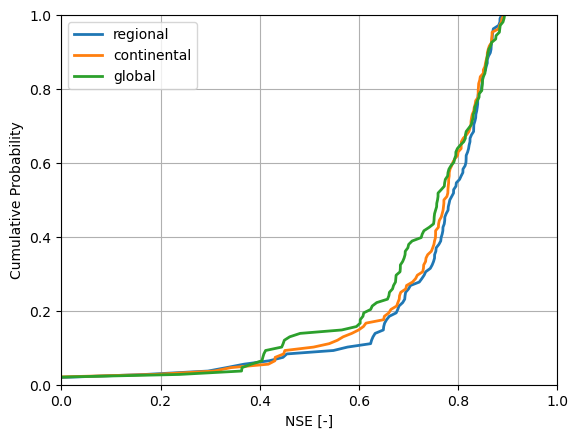

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

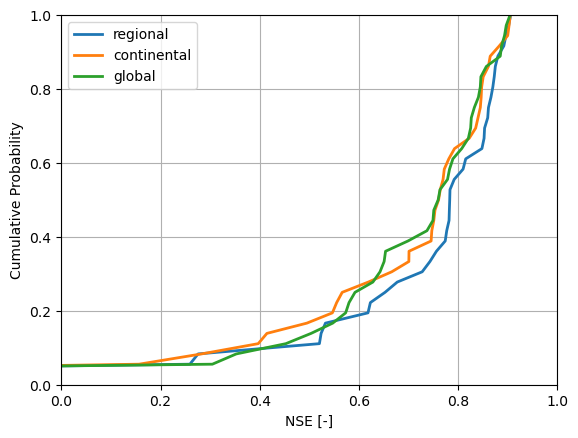

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

## Space-time validation

In [28]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_regional_val_dict = {}
output_continental_val_dict = {}
output_global_val_dict = {}

for key in tqdm.tqdm(regional_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_val_dict[key] = output

for key in tqdm.tqdm(continental_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_val_dict[key] = output

for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_val_dict[key] = output

100%|██████████| 7/7 [02:09<00:00, 18.47s/it]


In [29]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_regional_dict_0115 = {}
output_continental_dict_0115 = {}
output_global_dict_0115 = {}

for key in tqdm.tqdm(regional_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_regional_dict_0115[key] = output

for key in tqdm.tqdm(continental_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areascontinental
    )
    output_continental_dict_0115[key] = output

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areasglobal
    )
    output_global_dict_0115[key] = output

100%|██████████| 7/7 [02:26<00:00, 20.92s/it]


In [30]:
output_global_dict_val = {}

for param_key in output_global_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_0115:
        merged_outputs = {}

        for gauge_id in output_global_val_dict[param_key]:
            if gauge_id in output_global_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_val_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_recent, series_8801])
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_val[param_key] = merged_outputs

In [31]:
output_continental_dict_val = {}

for param_key in output_continental_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_continental_dict_0115:
        merged_outputs = {}

        for gauge_id in output_continental_val_dict[param_key]:
            if gauge_id in output_continental_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_continental_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_continental_val_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_recent, series_8801])
                merged_outputs[gauge_id] = [concatenated]

        output_continental_dict_val[param_key] = merged_outputs

In [32]:
output_regional_dict_val = {}

for param_key in output_regional_val_dict:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_regional_dict_0115:
        merged_outputs = {}

        for gauge_id in output_regional_val_dict[param_key]:
            if gauge_id in output_regional_dict_0115[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_regional_dict_0115[param_key_8801][gauge_id])
                series_recent = np.ravel(output_regional_val_dict[param_key][gauge_id])
                concatenated = np.concatenate([series_recent, series_8801])
                merged_outputs[gauge_id] = [concatenated]

        output_regional_dict_val[param_key] = merged_outputs

In [33]:
date_range = pd.date_range("1988-10-01", "2015-09-30", freq="D")

nse_results_global_dict_val = {}
for key in tqdm.tqdm(output_global_dict_val):
    nse_results_global_dict_val[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_global_dict_val[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_global_dict_val[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_continental_dict_val = {}
for key in tqdm.tqdm(output_continental_dict_val):
    nse_results_continental_dict_val[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_continental_dict_val[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_continental_dict_val[key].drop_duplicates(subset='basin', keep='first', inplace=True)

nse_results_regional_dict_val = {}
for key in tqdm.tqdm(output_regional_dict_val):
    nse_results_regional_dict_val[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_regional_dict_val[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_regional_dict_val[key].drop_duplicates(subset='basin', keep='first', inplace=True)

100%|██████████| 7/7 [01:21<00:00, 11.60s/it]


In [34]:
data_diff_val_complete_dict = {}

groups_list = [1,2,3,4,5,6,7]

for number_group in groups_list:

    Group_number = f"Group_"+str(number_group)

    nse_results_cal_r_1_100_complete_val = nse_results_regional_dict_val[f"moselle_best_params_regi_Group_{number_group}"]
    nse_results_cal_c_1_100_complete_val = nse_results_continental_dict_val[f"moselle_best_params_cont_Group_{number_group}"]
    nse_results_cal_g_1_100_complete_val = nse_results_global_dict_val[f"moselle_best_params_glob_Group_{number_group}"]

    list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == Group_number].index.tolist()

    # Remove strings starting with 'LU'
    list_cal = [g for g in list_cal if not g.startswith("LU")]


    data_diff_val_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_c_1_100_complete_val.nse)
    data_diff_val_complete["nse_rg"] = nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_g_1_100_complete_val.nse

    data_diff_val_complete.index = nse_results_cal_c_1_100_complete_val.basin

    data_diff_val_complete = data_diff_val_complete.loc[~data_diff_val_complete.index.isin(list_cal)]

    data_diff_val_complete["nse_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse
    data_diff_val_complete["nse_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse
    data_diff_val_complete["nse_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse

    data_diff_val_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
    data_diff_val_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
    data_diff_val_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

    data_diff_val_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_obs
    data_diff_val_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
    data_diff_val_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
    data_diff_val_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).bfi_sim

    data_diff_val_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_obs
    data_diff_val_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
    data_diff_val_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
    data_diff_val_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).qmean_sim

    data_diff_val_complete["slope_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_obs
    data_diff_val_complete["slope_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_sim
    data_diff_val_complete["slope_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).slope_sim
    data_diff_val_complete["slope_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).slope_sim

    data_diff_val_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_obs
    data_diff_val_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
    data_diff_val_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
    data_diff_val_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).hfd_sim

    data_diff_val_complete_dict[Group_number] = data_diff_val_complete

In [36]:
# List to store all DataFrames
dfs = list(data_diff_val_complete_dict.values())

# Concatenate all, aligning by index and columns (outer join)
all_data = pd.concat(dfs, axis=0)

# Group by index and compute mean
data_diff_val_complete = all_data.groupby(all_data.index).mean()

data_diff_val_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.007999  0.193294  0.816050  0.808050  0.622756         NaN   
BEWA0067  0.012304  0.139817  0.754879  0.742576  0.615063         NaN   
BEWA0106  0.007547  0.359963  0.756900  0.749353  0.396936         NaN   
BEWA0107  0.001647  0.220919  0.730829  0.729183  0.509910         NaN   
BEWA0119  0.001614  0.195395  0.792291  0.790677  0.596897         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.006136  0.237127  0.795602  0.801739  0.558476         NaN   
LU000016 -0.001741  0.008490  0.692547  0.694288  0.684057         NaN   
LU000017  0.006710  0.035115  0.842363  0.835653  0.807248         NaN   
LU000018  0.241503 -0.009367  0.632449  0.390946  0.641817         NaN   
LU000019  0.008609  0.113883  0.796220  0.787611  0.682337         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.578789  ...  1.264337  1.267072   
BEWA0067         NaN         NaN  0.446878  0.564938  ...  1.329078  1.314246   
BEWA0106         NaN         NaN  0.496805  0.582017  ...  1.073624  1.065648   
BEWA0107         NaN         NaN  0.565063  0.557327  ...  1.465407  1.437944   
BEWA0119         NaN         NaN  0.508101  0.566760  ...  1.363182  1.351593   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.580560  ...  0.924478  0.922286   
LU000016         NaN         NaN  0.564940  0.558774  ...  0.648936  0.656006   
LU000017         NaN         NaN  0.572433  0.612745  ...  0.814226  0.809989   
LU000018         NaN         NaN  0.549133  0.657691  ...  0.714577  0.701196   
LU000019         NaN         NaN  0.492709  0.581088  ...  1.014123  1.001614   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.829639  2.765691  2.045648  126.294118  134.029412   
BEWA0067   3.527884  2.912570  2.798336  2.093838  123.437500  135.093750   
BEWA0106   4.063631  3.003341  2.879257  1.928846  127.000000  133.971014   
BEWA0107   3.418299  2.901102  2.936532  2.088673  133.588235  137.588235   
BEWA0119   3.336434  2.953030  2.926211  2.154216  123.266667  132.344444   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.737841  2.679914  1.927297  121.769231  131.252747   
LU000016   2.005883  2.347809  2.295506  2.509434  133.615385  132.395604   
LU000017   2.459555  2.366656  2.284250  1.957674  127.307692  134.824176   
LU000018   2.305895  1.954435  1.578770  2.509877  127.384615  139.934066   
LU000019   3.428468  2.641403  2.618956  1.931614  125.846154  134.384615   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  135.009804  150.372549  
BEWA0067  136.218750  148.447917  
BEWA0106  134.746377  160.536232  
BEWA0107  137.588235  156.705882  
BEWA0119  132.777778  148.511111  
...              ...         ...  
LU000015  132.021978  153.120879  
LU000016  132.395604  131.263736  
LU000017  136.120879  143.153846  
LU000018  157.032967  130.659341  
LU000019  134.615385  148.175824  

[108 rows x 24 columns]

# Save the performances in dataframes

In [ ]:
# Difference dataframe
for name, df in data_diff_cal_complete_dict.items():
    df.to_csv(rf"..\results\performances\space\{name}.csv", index=True)

In [ ]:
# NSEs
for name, df in nse_results_regional_dict_cal.items():
    df.to_csv(rf"..\results\performances\space\nses\{name}.csv", index=True)

for name, df in nse_results_continental_dict_cal.items():
    df.to_csv(rf"..\results\performances\space\nses\{name}.csv", index=True)

for name, df in nse_results_global_dict_cal.items():
    df.to_csv(rf"..\results\performances\space\nses\{name}.csv", index=True)

In [ ]:
# Difference dataframe
for name, df in data_diff_val_complete_dict.items():
    df.to_csv(rf"..\results\performances\space_time\{name}.csv", index=True)

In [ ]:
# NSEs
for name, df in nse_results_regional_dict_val.items():
    df.to_csv(rf"..\results\performances\space_time\nses\{name}.csv", index=True)

for name, df in nse_results_continental_dict_val.items():
    df.to_csv(rf"..\results\performances\space_time\nses\{name}.csv", index=True)

for name, df in nse_results_global_dict_val.items():
    df.to_csv(rf"..\results\performances\space_time\nses\{name}.csv", index=True)

# Load the performances

In [16]:
# Folder where the CSVs are saved (change if needed)
csv_folder = r"..\results\performances\space"

# Create a dictionary by reading all .csv files in the folder
data_diff_cal_complete_dict = {}
for filename in os.listdir(csv_folder):
    if filename.endswith(".csv"):
        key = filename.replace(".csv", "")
        df = pd.read_csv(os.path.join(csv_folder, filename))  # <== this is the 'df' you're asking about
        df.set_index("basin", inplace=True)
        data_diff_cal_complete_dict[key] = df

# Example: access one DataFrame
print(data_diff_cal_complete_dict.keys())      # shows all keys

dict_keys(['Group_1', 'Group_2', 'Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7'])


In [17]:
# Folder where the CSVs are saved (change if needed)
csv_folder = r"..\results\performances\space_time"

# Create a dictionary by reading all .csv files in the folder
data_diff_val_complete_dict = {}
for filename in os.listdir(csv_folder):
    if filename.endswith(".csv"):
        key = filename.replace(".csv", "")
        df = pd.read_csv(os.path.join(csv_folder, filename))  # <== this is the 'df' you're asking about
        df.set_index("basin", inplace=True)
        data_diff_val_complete_dict[key] = df

# Example: access one DataFrame
print(data_diff_val_complete_dict.keys())      # shows all keys

dict_keys(['Group_1', 'Group_2', 'Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7'])


In [23]:
# List to store all DataFrames
dfs = list(data_diff_val_complete_dict.values())

# Concatenate all, aligning by index and columns (outer join)
all_data = pd.concat(dfs, axis=0)

# Group by index and compute mean
data_diff_val_complete = all_data.groupby(all_data.index).mean()

data_diff_val_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.007999  0.193294  0.816050  0.808050  0.622756         NaN   
BEWA0067  0.012304  0.139817  0.754879  0.742576  0.615063         NaN   
BEWA0106  0.007547  0.359963  0.756900  0.749353  0.396936         NaN   
BEWA0107  0.001647  0.220919  0.730829  0.729183  0.509910         NaN   
BEWA0119  0.001614  0.195395  0.792291  0.790677  0.596897         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.006136  0.237127  0.795602  0.801739  0.558476         NaN   
LU000016 -0.001741  0.008490  0.692547  0.694288  0.684057         NaN   
LU000017  0.006710  0.035115  0.842363  0.835653  0.807248         NaN   
LU000018  0.241503 -0.009367  0.632449  0.390946  0.641817         NaN   
LU000019  0.008609  0.113883  0.796220  0.787611  0.682337         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.578789  ...  1.264337  1.267072   
BEWA0067         NaN         NaN  0.446878  0.564938  ...  1.329078  1.314246   
BEWA0106         NaN         NaN  0.496805  0.582017  ...  1.073624  1.065648   
BEWA0107         NaN         NaN  0.565063  0.557327  ...  1.465407  1.437944   
BEWA0119         NaN         NaN  0.508101  0.566760  ...  1.363182  1.351593   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.580560  ...  0.924478  0.922286   
LU000016         NaN         NaN  0.564940  0.558774  ...  0.648936  0.656006   
LU000017         NaN         NaN  0.572433  0.612745  ...  0.814226  0.809989   
LU000018         NaN         NaN  0.549133  0.657691  ...  0.714577  0.701196   
LU000019         NaN         NaN  0.492709  0.581088  ...  1.014123  1.001614   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.829639  2.765691  2.045648  126.294118  134.029412   
BEWA0067   3.527884  2.912570  2.798336  2.093838  123.437500  135.093750   
BEWA0106   4.063631  3.003341  2.879257  1.928846  127.000000  133.971014   
BEWA0107   3.418299  2.901102  2.936532  2.088673  133.588235  137.588235   
BEWA0119   3.336434  2.953030  2.926211  2.154216  123.266667  132.344444   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.737841  2.679914  1.927297  121.769231  131.252747   
LU000016   2.005883  2.347809  2.295506  2.509434  133.615385  132.395604   
LU000017   2.459555  2.366656  2.284250  1.957674  127.307692  134.824176   
LU000018   2.305895  1.954435  1.578770  2.509877  127.384615  139.934066   
LU000019   3.428468  2.641403  2.618956  1.931614  125.846154  134.384615   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  135.009804  150.372549  
BEWA0067  136.218750  148.447917  
BEWA0106  134.746377  160.536232  
BEWA0107  137.588235  156.705882  
BEWA0119  132.777778  148.511111  
...              ...         ...  
LU000015  132.021978  153.120879  
LU000016  132.395604  131.263736  
LU000017  136.120879  143.153846  
LU000018  157.032967  130.659341  
LU000019  134.615385  148.175824  

[108 rows x 24 columns]

In [32]:
# List to store all DataFrames
dfs = list(data_diff_cal_complete_dict.values())

# Concatenate all, aligning by index and columns (outer join)
all_data = pd.concat(dfs, axis=0)

# Group by index and compute mean
data_diff_cal_complete = all_data.groupby(all_data.index).mean()

data_diff_cal_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.004011  0.238105  0.840477  0.844488  0.602372         NaN   
BEWA0067 -0.006290  0.160183  0.786864  0.793153  0.626681         NaN   
BEWA0106  0.000643  0.397206  0.779976  0.779333  0.382770         NaN   
BEWA0107 -0.004043  0.253120  0.734429  0.738472  0.481308         NaN   
BEWA0119 -0.005639  0.206364  0.815959  0.821598  0.609595         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.005622  0.423077  0.831265  0.825644  0.408188         NaN   
LU000016 -0.007572  0.043316  0.726632  0.734204  0.683316         NaN   
LU000017  0.001392  0.042253  0.868751  0.867359  0.826498         NaN   
LU000018  0.276768  0.019817  0.694001  0.417233  0.674183         NaN   
LU000019 -0.002007  0.166378  0.823882  0.825889  0.657504         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.573996  ...  1.354794  1.347175   
BEWA0067         NaN         NaN  0.446878  0.561839  ...  1.454498  1.441517   
BEWA0106         NaN         NaN  0.496805  0.576025  ...  1.073445  1.057375   
BEWA0107         NaN         NaN  0.565063  0.553150  ...  1.495473  1.474725   
BEWA0119         NaN         NaN  0.508101  0.564817  ...  1.390009  1.375960   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.569515  ...  1.060348  1.054085   
LU000016         NaN         NaN  0.564940  0.529946  ...  0.749355  0.746989   
LU000017         NaN         NaN  0.572433  0.599407  ...  0.937097  0.929370   
LU000018         NaN         NaN  0.549133  0.640475  ...  0.812687  0.799441   
LU000019         NaN         NaN  0.492709  0.573873  ...  1.173858  1.164493   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.868116  2.865808  1.785606  126.294118  132.088235   
BEWA0067   3.527884  2.893638  2.880805  1.936803  123.437500  131.427083   
BEWA0106   4.063631  3.077113  2.945425  1.809467  127.000000  133.333333   
BEWA0107   3.418299  2.848702  2.872728  1.849373  133.588235  135.421569   
BEWA0119   3.336434  2.898094  2.878937  1.897892  123.266667  130.922222   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  3.046407  2.985053  1.851511  121.769231  129.142857   
LU000016   2.005883  2.639049  2.559169  2.976492  133.615385  131.395604   
LU000017   2.459555  2.566640  2.502652  1.944899  127.307692  132.956044   
LU000018   2.305895  2.159678  1.808115  2.962157  127.384615  139.670330   
LU000019   3.428468  2.820012  2.823068  1.761708  125.846154  130.340659   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  133.019608  153.411765  
BEWA0067  132.531250  148.312500  
BEWA0106  134.253623  163.630435  
BEWA0107  136.127451  160.862745  
BEWA0119  131.766667  151.033333  
...              ...         ...  
LU000015  129.549451  162.010989  
LU000016  132.670330  128.582418  
LU000017  134.230769  143.604396  
LU000018  156.626374  127.846154  
LU000019  130.956044  149.802198  

[108 rows x 24 columns]

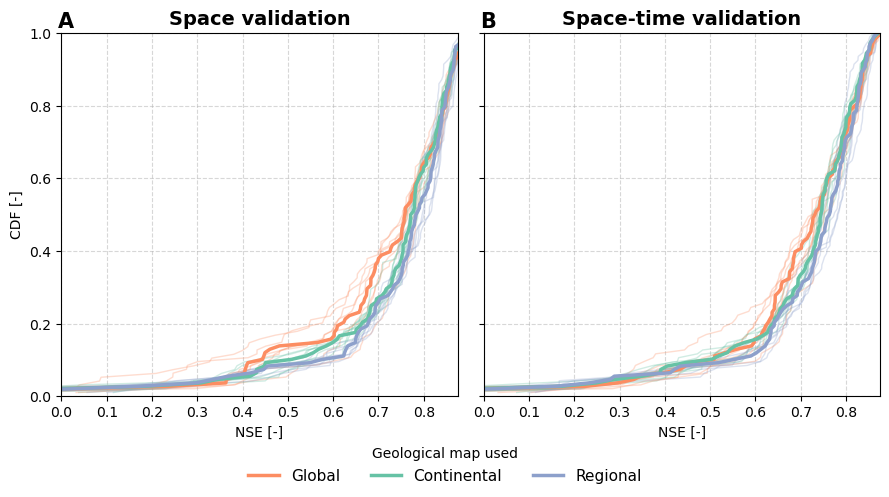

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define colors for each model type
colors = {
    'nse_g1': '#fc8d62',   # Coral / Orange #E69F00 other option
    'nse_c1': '#66c2a5',  # Mint Green
    'nse_r1': '#8da0cb',  # Lavender Blue
}

# Pretty names for legend
labels_pretty = {
    'nse_g1': 'Global',
    'nse_c1': 'Continental',
    'nse_r1': 'Regional',
}

# Define dicts to loop through
dicts = {
    'Space validation': data_diff_cal_complete_dict,
    'Space-time validation': data_diff_val_complete_dict
    
}

# Create 1x2 subplot figure
fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
letters = ['A', 'B']

# Plot loop
for ax, (label, data_dict), subplot_letter in zip(axs, dicts.items(), letters):
    
    # --- Step 1: Plot all individual curves ---
    for group_num, df in data_dict.items():
        for model_type in ['nse_g1', 'nse_c1', 'nse_r1']:
            if model_type in df.columns:
                nse_values = np.sort(df[model_type].dropna())
                if len(nse_values) == 0:
                    continue
                cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
                ax.plot(
                    nse_values, cumulative,
                    color=colors[model_type],
                    alpha=0.3,
                    linewidth=1
                )

    # --- Step 2: Compute and plot mean lines ---
    dfs = list(data_dict.values())
    all_data = pd.concat(dfs, axis=0)
    data_combined = all_data.groupby(all_data.index).mean()

    for model_type in ['nse_g1', 'nse_c1', 'nse_r1']:
        nse_values = np.sort(data_combined[model_type].dropna())
        if len(nse_values) == 0:
            continue
        cumulative = np.arange(1, len(nse_values) + 1) / len(nse_values)
        ax.plot(
            nse_values, cumulative,
            color=colors[model_type],
            linewidth=2.5,
            label=labels_pretty[model_type]
        )

    # Plot styling
    ax.set_xlabel("NSE [-]")
    ax.set_xlim(-0.0, 0.875)
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(label, fontsize=14, weight='bold')

    # Subplot label (A. / B.)
    ax.text(-0.01, 1.06, f"{subplot_letter}", transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

# Shared y-axis label
axs[0].set_ylabel("CDF [-]")

# Only one legend for both plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Geological map used", loc='lower center', ncol=3, fontsize=11, frameon=False)

# Final layout
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\cdfs.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

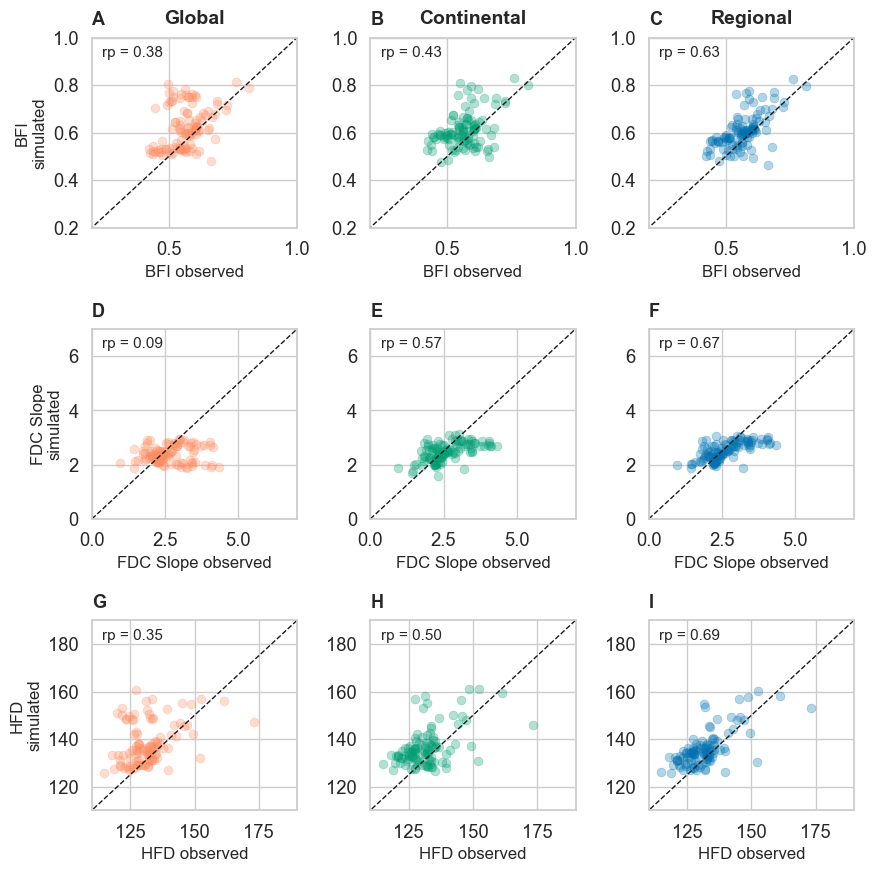

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define variables and pretty titles
metrics = ['bfi', 'slope', 'hfd']
metric_titles = ['BFI', 'FDC Slope', 'HFD']

# Define suffixes and scales
suffixes = ['g1', 'c1', 'r1']
scale_titles = ['Global', 'Continental', 'Regional']

# Define column-based color (Global, Continental, Regional)
col_colors = ['#fc8d62', '#009E73', '#0072B2']  # Orange, Green, Blue

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharex=False, sharey=False)
letters = list(string.ascii_uppercase)

# Loop through rows and columns
for row, (metric, row_title) in enumerate(zip(metrics, metric_titles)):
    for col, (suffix, scale_title) in enumerate(zip(suffixes, scale_titles)):
        ax = axs[row, col]
        var_obs = f"{metric}_obs"
        var_pred = f"{metric}_{suffix}"

        # Scatterplot with seaborn aesthetics
        sns.scatterplot(
            x=data_diff_val_complete[var_obs],
            y=data_diff_val_complete[var_pred],
            ax=ax,
            color=col_colors[col],
            alpha=0.3,
            s=40,
            edgecolor=None
        )

        # 1:1 line
        xy_min = min(data_diff_val_complete[var_obs].min(), data_diff_val_complete[var_pred].min())
        xy_max = max(data_diff_val_complete[var_obs].max(), data_diff_val_complete[var_pred].max())

        # Titles and labels
        if row == 0:
            ax.set_title(scale_title, fontsize=14, pad=10, fontweight="bold")
        if col == 0:
            ax.set_ylabel(f"{row_title}\nsimulated", fontsize=12)
        else:
            ax.set_ylabel("")

        ax.set_xlabel(f"{row_title} observed", fontsize=12)

        # Pearson correlation
        R = data_diff_val_complete[[var_obs, var_pred]].corr(method="pearson").iloc[0, 1]
        ax.text(
            0.05, 0.9, f"rp = {R:.2f}", transform=ax.transAxes,
            fontsize=11, bbox=dict(facecolor='none', alpha=0.6, edgecolor='none')
        )

        # Subplot letter (A, B, C, ...)
        subplot_idx = row * 3 + col
        ax.text(
            -0.00, 1.14, f"{letters[subplot_idx]}", transform=ax.transAxes,
            fontsize=13, fontweight='bold', va='top', ha='left'
        )

        ax.set_xlim(xy_min, xy_max)
        ax.set_ylim(xy_min, xy_max)

axs[0, 0].set_xlim(0.2, 1)
axs[0, 0].set_ylim(0.2, 1)
axs[0, 1].set_xlim(0.2, 1)
axs[0, 1].set_ylim(0.2, 1)
axs[0, 2].set_xlim(0.2, 1)
axs[0, 2].set_ylim(0.2, 1)


axs[1, 0].set_xlim(0, 7)
axs[1, 0].set_ylim(0, 7)
axs[1, 1].set_xlim(0, 7)
axs[1, 1].set_ylim(0, 7)
axs[1, 2].set_xlim(0, 7)
axs[1, 2].set_ylim(0, 7)


axs[2, 0].set_xlim(110, 190)
axs[2, 0].set_ylim(110, 190)
axs[2, 1].set_xlim(110, 190)
axs[2, 1].set_ylim(110, 190)
axs[2, 2].set_xlim(110, 190)
axs[2, 2].set_ylim(110, 190)


axs[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 2].plot([0, 1], [0, 1], 'k--', lw=1)

axs[1, 0].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 1].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 2].plot([0, 7], [0, 7], 'k--', lw=1)

axs[2, 0].plot([100, 200], [100, 200], 'k--', lw=1)
axs[2, 1].plot([100, 200], [100, 200], 'k--', lw=1)
axs[2, 2].plot([100, 200], [100, 200], 'k--', lw=1)

# Improve spacing
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\signatures.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_27024\164301827.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave room for colorbar


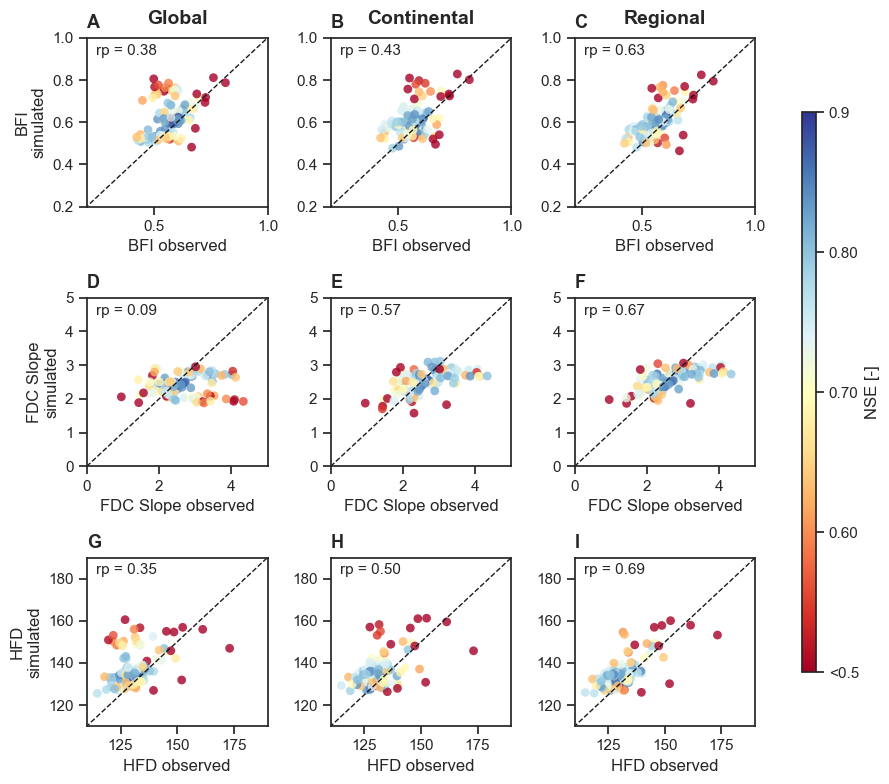

In [ ]:
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt

# Colormap
cmap = plt.cm.RdYlBu
vmin, vmax = 0.5, 0.9  # fixed NSE range for coloring

# Start figure
fig, axs = plt.subplots(3, 3, figsize=(9, 8), sharex=False, sharey=False)
letters = list(string.ascii_uppercase)

for row, (metric, row_title) in enumerate(zip(metrics, metric_titles)):
    for col, (suffix, scale_title) in enumerate(zip(suffixes, scale_titles)):
        ax = axs[row, col]
        var_obs = f"{metric}_obs"
        var_pred = f"{metric}_{suffix}"
        var_nse = f"nse_{suffix}"

        # Get color values for this column's NSE
        colors = data_diff_val_complete[var_nse]

        # Scatter plot with colored points
        sc = ax.scatter(
            data_diff_val_complete[var_obs],
            data_diff_val_complete[var_pred],
            c=data_diff_val_complete[var_nse].clip(0.5, 0.9),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=40,
            alpha=0.8,
            edgecolor='none',
            linewidth=0.2
        )



        # Titles and labels
        if row == 0:
            ax.set_title(scale_title, fontsize=14, pad=10, fontweight="bold")
        if col == 0:
            ax.set_ylabel(f"{row_title}\nsimulated", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(f"{row_title} observed", fontsize=12)

        # Correlation text
        R = data_diff_val_complete[[var_obs, var_pred]].corr(method="pearson").iloc[0, 1]
        ax.text(0.05, 0.9, f"rp = {R:.2f}", transform=ax.transAxes,
                fontsize=11, bbox=dict(facecolor='none', alpha=0.6, edgecolor='none'))

        # Subplot letter
        subplot_idx = row * 3 + col
        ax.text(-0.00, 1.14, f"{letters[subplot_idx]}", transform=ax.transAxes,
                fontsize=13, fontweight='bold', va='top', ha='left')

        ax.set_xlim(xy_min, xy_max)
        ax.set_ylim(xy_min, xy_max)

# Add a single colorbar
fig.subplots_adjust(right=0.88)  # make space


ticks = np.linspace(0.5, 0.9, num=5)  # Adjust number of ticks if needed
tick_labels = [f"<0.5"] + [f"{t:.2f}" for t in ticks[1:-1]] + [f"0.9"]


cbar_ax = fig.add_axes([0.90, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax)), cax=cbar_ax)
cbar.set_label("NSE [-]")
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)


# Add 1:1 line
axs[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0, 2].plot([0, 1], [0, 1], 'k--', lw=1)

axs[1, 0].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 1].plot([0, 7], [0, 7], 'k--', lw=1)
axs[1, 2].plot([0, 7], [0, 7], 'k--', lw=1)

axs[2, 0].plot([100, 200], [100, 200], 'k--', lw=1)
axs[2, 1].plot([100, 200], [100, 200], 'k--', lw=1)
axs[2, 2].plot([100, 200], [100, 200], 'k--', lw=1)

axs[0, 0].set_xlim(0.2, 1)
axs[0, 0].set_ylim(0.2, 1)
axs[0, 1].set_xlim(0.2, 1)
axs[0, 1].set_ylim(0.2, 1)
axs[0, 2].set_xlim(0.2, 1)
axs[0, 2].set_ylim(0.2, 1)


axs[1, 0].set_xlim(0, 5)
axs[1, 0].set_ylim(0, 5)
axs[1, 1].set_xlim(0, 5)
axs[1, 1].set_ylim(0, 5)
axs[1, 2].set_xlim(0, 5)
axs[1, 2].set_ylim(0, 5)


axs[2, 0].set_xlim(110, 190)
axs[2, 0].set_ylim(110, 190)
axs[2, 1].set_xlim(110, 190)
axs[2, 1].set_ylim(110, 190)
axs[2, 2].set_xlim(110, 190)
axs[2, 2].set_ylim(110, 190)

# Tight layout and save
plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave room for colorbar
plt.show()

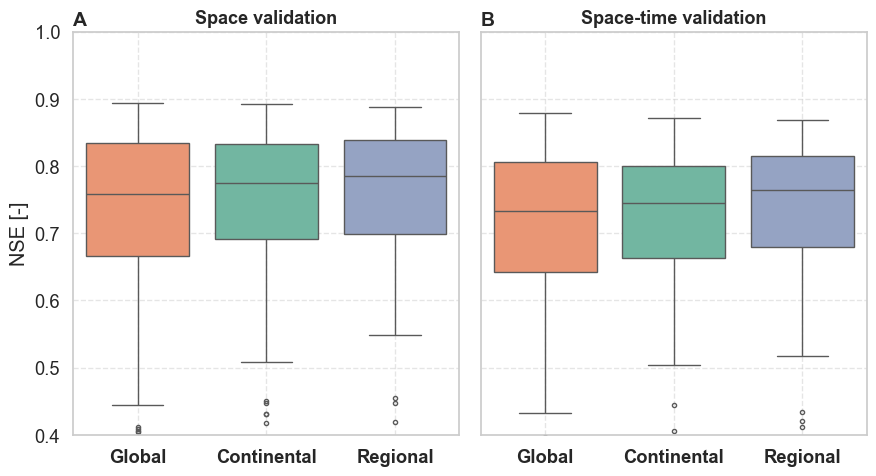

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define model colors
colors = {
    'Regional': '#8da0cb',
    'Continental': '#66c2a5',
    'Global': '#fc8d62'
}

# Map column names to pretty names
column_label_map = {
    'nse_g1': 'Global',
    'nse_c1': 'Continental',
    'nse_r1': 'Regional'

}

# Data sources
dataframes = [data_diff_cal_complete, data_diff_val_complete]
titles = ['Space validation', 'Space-time validation']
letters = ['A', 'B']

# Prepare tidy DataFrames for Seaborn
tidy_dataframes = []
for df, name in zip(dataframes, titles):
    df_tidy = pd.DataFrame({
        'NSE': pd.concat([df[col] for col in column_label_map]),
        'Model': sum([[column_label_map[col]] * len(df) for col in column_label_map], []),
        'Validation': name
    })
    tidy_dataframes.append(df_tidy)

# Combine all into one tidy DataFrame
df_all = pd.concat(tidy_dataframes, ignore_index=True)

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

# Plot loop
for i, ax in enumerate(axs):
    val_type = titles[i]
    df_sub = df_all[df_all["Validation"] == val_type]

    sns.boxplot(
        data=df_sub,
        x="Model",
        y="NSE",
        hue="Model",           # Fix for future seaborn versions
        ax=ax,
        palette=colors,
        linewidth=1,
        fliersize=3,
        dodge=False            # Ensures boxes stay aligned without hue splitting
    )

    # Bold x-tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')

    ax.set_title(val_type, fontsize=13, weight='bold')
    ax.set_xlabel("")
    #ax.set_ylim(-0.5, 1.0)
    ax.set_ylim(0.4, 1.0)

    ax.grid(True, linestyle='--', alpha=0.5)

    if i == 0:
        ax.set_ylabel("NSE [-]")
    else:
        ax.set_ylabel("")

    # Subplot label (A / B)
    ax.text(-0., 1.05, f"{letters[i]}", transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')
    

    


# Final layout
plt.tight_layout()
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\boxplots.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()


In [41]:
df = data_diff_val_complete.copy()
df[["lat", "lon"]] = network_estreams[["lat", "lon"]]

C:\Users\nascimth\AppData\Local\Temp\ipykernel_27024\4109225421.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


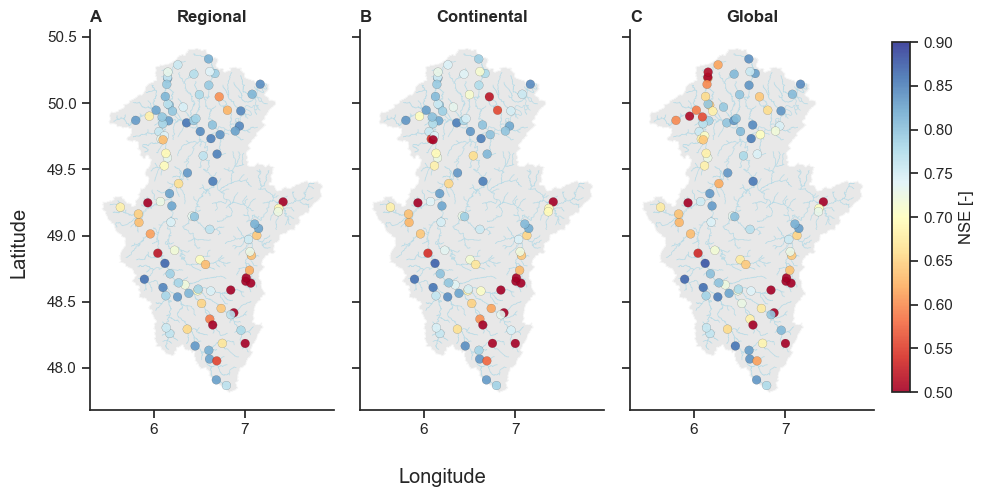

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set style
sns.set_theme(style="ticks")

# Improved colormap for NSE
cmap_nse = plt.cm.RdYlBu  # or try 'viridis', 'coolwarm'

# Create figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(9, 5), sharex=True, sharey=True)

# NSE columns to plot
nse_cols = ['nse_r1', 'nse_c1', 'nse_g1']
titles = ['A', 'B', 'C']
main_titles = ['Regional', 'Continental', 'Global']

# Set common color limits for NSE
vmin, vmax = 0.5, 0.9  # Adjust if you want to include negatives

for ax, col, title in zip(axes, nse_cols, titles):
    # Background maps
    moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # Plot all gauges the same way (circle)
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    ax.set_title(title, loc="left", fontweight="bold")
    ax.set_aspect('auto')
    ax.grid(False)
    sns.despine(ax=ax)

# Add a global "subtitle" row across the top
for ax, title in zip(axes, main_titles):
    ax.set_title(title, fontsize=12, fontweight="bold", loc="center")

# Shared axis labels
fig.supxlabel("Longitude")
fig.supylabel("Latitude")


# One colorbar for all subplots
#cbar = fig.colorbar(
#    sc,
#    ax=axes,
#    orientation='vertical',
#    fraction=0.025,
#    pad=0.02
#)

# Adjust layout to make space on the right
fig.subplots_adjust(right=0.85)  # Leave room for colorbar

# Create custom colorbar axis (position: [left, bottom, width, height])
cbar_ax = fig.add_axes([1, 0.2, 0.02, 0.7])  # tweak as needed
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('NSE [-]')

#cbar.set_label('NSE [-]')

plt.tight_layout()
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\maps.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

In [83]:
data_diff_cal_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.004011  0.238105  0.840477  0.844488  0.602372         NaN   
BEWA0067 -0.006290  0.160183  0.786864  0.793153  0.626681         NaN   
BEWA0106  0.000643  0.397206  0.779976  0.779333  0.382770         NaN   
BEWA0107 -0.004043  0.253120  0.734429  0.738472  0.481308         NaN   
BEWA0119 -0.005639  0.206364  0.815959  0.821598  0.609595         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.005622  0.423077  0.831265  0.825644  0.408188         NaN   
LU000016 -0.007572  0.043316  0.726632  0.734204  0.683316         NaN   
LU000017  0.001392  0.042253  0.868751  0.867359  0.826498         NaN   
LU000018  0.276768  0.019817  0.694001  0.417233  0.674183         NaN   
LU000019 -0.002007  0.166378  0.823882  0.825889  0.657504         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.573996  ...  1.354794  1.347175   
BEWA0067         NaN         NaN  0.446878  0.561839  ...  1.454498  1.441517   
BEWA0106         NaN         NaN  0.496805  0.576025  ...  1.073445  1.057375   
BEWA0107         NaN         NaN  0.565063  0.553150  ...  1.495473  1.474725   
BEWA0119         NaN         NaN  0.508101  0.564817  ...  1.390009  1.375960   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.569515  ...  1.060348  1.054085   
LU000016         NaN         NaN  0.564940  0.529946  ...  0.749355  0.746989   
LU000017         NaN         NaN  0.572433  0.599407  ...  0.937097  0.929370   
LU000018         NaN         NaN  0.549133  0.640475  ...  0.812687  0.799441   
LU000019         NaN         NaN  0.492709  0.573873  ...  1.173858  1.164493   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.868116  2.865808  1.785606  126.294118  132.088235   
BEWA0067   3.527884  2.893638  2.880805  1.936803  123.437500  131.427083   
BEWA0106   4.063631  3.077113  2.945425  1.809467  127.000000  133.333333   
BEWA0107   3.418299  2.848702  2.872728  1.849373  133.588235  135.421569   
BEWA0119   3.336434  2.898094  2.878937  1.897892  123.266667  130.922222   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  3.046407  2.985053  1.851511  121.769231  129.142857   
LU000016   2.005883  2.639049  2.559169  2.976492  133.615385  131.395604   
LU000017   2.459555  2.566640  2.502652  1.944899  127.307692  132.956044   
LU000018   2.305895  2.159678  1.808115  2.962157  127.384615  139.670330   
LU000019   3.428468  2.820012  2.823068  1.761708  125.846154  130.340659   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  133.019608  153.411765  
BEWA0067  132.531250  148.312500  
BEWA0106  134.253623  163.630435  
BEWA0107  136.127451  160.862745  
BEWA0119  131.766667  151.033333  
...              ...         ...  
LU000015  129.549451  162.010989  
LU000016  132.670330  128.582418  
LU000017  134.230769  143.604396  
LU000018  156.626374  127.846154  
LU000019  130.956044  149.802198  

[108 rows x 24 columns]

In [89]:
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((-0.05, 0.8))  # Adjust legend position


def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 12})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 8  # You can adjust this value as needed

def generate_legend_and_color_mapping(variable_name, color_categories, xmin_hist, xmax_hist, base_hist, hist_bins, color_palette='default'):
    """
    Generate legend labels and color mapping based on the provided color categories.

    Parameters:
        variable_name (str): Name of the variable.
        color_categories (list): List of tuples defining color categories.
        xmin_hist (float): Minimum value for histogram.
        xmax_hist (float): Maximum value for histogram.
        base_hist (float): Base value for histogram.
        hist_bins (int): Number of bins for histogram.
        color_palette (str): Name of the color palette to use. Options: 'default', 'custom', 'vegetation', 'grassland', 'blues'.

    Returns:
        tuple: Tuple containing variable name, color categories, legend labels, color mapping, histogram parameters.
    """
    # Adjusting the first and last legend labels
    legend_labels = [f"<{color_categories[0][1]}"]
    for i in range(len(color_categories) - 1):
        legend_labels.append(f"{color_categories[i][1]}-{color_categories[i+1][1]}")
    legend_labels[-1] = f">{color_categories[-1][0]}"  # Correcting the last legend label

    color_mapping = {}
    if color_palette == 'default':
        color_mapping = {
            f"{category[0]}-{category[1]}": ['#a6cee3', '#1f78b4', '#6a3d9a', '#b2df8a', '#33a02c'][i] for i, category in enumerate(color_categories)
        }
    elif color_palette == 'custom':
        # Define your custom color palette here
        color_mapping = {
            f"{category[0]}-{category[1]}": ['bisque', '#fdcc8a', '#fc8d59', '#d7301f', '#990000'][i] for i, category in enumerate(color_categories)
             #color_mapping[f"{category[0]}-{category[1]}"] = ['#ffbb78', '#ff7f0e', '#aec7e8', '#1f77b4', '#9467bd'][i] # This is from orange to purple

        }

    elif color_palette == 'vegetation':
        # Define your custom color palette here
        color_mapping = {
            f"{category[0]}-{category[1]}": ['#B2DF8A', '#66C2A5', '#238B45', '#006D2C', '#00441B'][i] for i, category in enumerate(color_categories)
        }

    elif color_palette == 'grassland':
        # Define your custom color palette here
        color_mapping = {
            f"{category[0]}-{category[1]}": ['#FFD699', '#FF9900', '#FF6600', '#FF3300', '#FF0000'][i] for i, category in enumerate(color_categories)
        }

    elif color_palette == 'blues':
        # Define your custom color palette here
        color_mapping = {
            f"{category[0]}-{category[1]}": ['#FFD699', '#b2df8a', '#a6cee3', '#1f78b4', '#6a3d9a'][i] for i, category in enumerate(color_categories)
        }

    else:
        raise ValueError("Invalid color_palette. Choose 'default' or 'custom'.")

    return variable_name, color_categories, legend_labels, color_mapping, xmin_hist, xmax_hist, base_hist, hist_bins

def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf):
    """
    Plot a variable on a subplot along with its legend and histogram.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]
    xmin_hist = color_mapping_list[variable][4]
    xmax_hist = color_mapping_list[variable][5]
    base_hist = color_mapping_list[variable][6]
    hist_bins = color_mapping_list[variable][7]

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.2)
    ax.set_xlim(-24, 40) 
    ax.set_ylim(35, 70)  

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=-24, miny=35, maxx=40, maxy=70, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=1)

    # Turn off both x-axis and y-axis
    ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    hist_ax = ax.inset_axes([0.05, 0.05, 0.15, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram within the inset axis
    hist_ax.hist(hist_data, bins=hist_bins, color='white', edgecolor='black', alpha=0.7, linewidth=0.5)
    
    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(False)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Remove y-axis ticks and labels
    hist_ax.set_yticks([])
    hist_ax.set_yticklabels([])

    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title)

    # Adjust aspect ratio
    ax.set_aspect('equal')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Function to create histograms inside subplots
def add_hist(axes, data: pd.DataFrame, axes_loc=[0.05, 0.05, 0.15, 0.175], alpha_hist=0.7,
             num_bins=10, x_ticks=[0, 5], base_xaxis=1, xlim_i=0, xlim_f=5):
    """
    Add a histogram to a subplot.

    Parameters:
        data (pandas.Series): Data for the histogram.
        axes (matplotlib.axes.Axes): The subplot where the histogram will be added.
        axes_loc (list): Location and size of the inset axis.
        alpha_hist (float): Alpha value for histogram transparency.
        num_bins (int): Number of histogram bins.
        x_ticks (list): Specific x-axis tick values.
        base_xaxis (int): Minor locator base for x-axis ticks.
        xlim_i (float): Minimum x-axis limit.
        xlim_f (float): Maximum x-axis limit.

    Returns:
        None
    """
    # Create a histogram inset axis within the subplot
    hist_ax = axes.inset_axes(axes_loc)  # Adjust the values as needed
    # Extract the data for the histogram (replace 'column_name' with the actual column you want to plot)
    hist_data = data.dropna()

    # Plot the histogram within the inset axis
    hist_ax.hist(hist_data, bins=num_bins, color='gray', alpha=alpha_hist)
    hist_ax.set_xlabel('')  # Replace with an appropriate label
    hist_ax.set_ylabel('')  # Replace with an appropriate label

    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(False)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=5)

    # Adjust y-tick label alignment for the right y-axis
    hist_ax.yaxis.tick_right()  # Move the y-tick labels to the right side
    hist_ax.yaxis.set_label_position("right")  # Move the y-axis label to the right side

    # Define the specific y-axis tick values you want to show
    hist_ax.set_xticks(x_ticks)

    # Remove y-axis ticks and labels
    hist_ax.set_yticks([])
    hist_ax.set_yticklabels([])

    hist_ax.xaxis.set_minor_locator(plt.MultipleLocator(base=base_xaxis))  # Adjust the base as needed
    # Set x-axis limits (adjust the values as needed)
    hist_ax.set_xlim(xlim_i, xlim_f)


# Histograms for different catchments groups:
def plot_histograms_by_group(df, col_to_classify, num_cols=3):
    """
    Plot histograms for each class within each variable in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        col_to_classify (str): Name of the column containing the classes.
        num_cols (int): Number of columns in each row of subplots. Default is 3.
    """
    # Get unique classes
    classes = df[col_to_classify].unique()
    classes = classes.astype(int)
    num_classes = len(classes)
    
    # Determine number of rows and columns for subplots
    num_rows = (df.shape[1] - 1) // num_cols + 1

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))

    # Flatten the axes array
    axes = axes.flatten()

    # Plot histograms for each variable
    for i, (col, ax) in enumerate(zip(df.columns, axes)):
        if col != col_to_classify:
            for cls in classes:
                ax.hist(df[df[col_to_classify].astype(int) == cls][col], bins=10, alpha=0.5, label=cls)
            ax.set_title(col)
            ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_histograms_by_group_two_subsets(df, df2, col_to_classify, num_cols=3):
    """
    Plot histograms for each class within each variable in the DataFrame using only two different subsets.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        col_to_classify (str): Name of the column containing the classes.
        num_cols (int): Number of columns in each row of subplots. Default is 3.
    """
    # Get unique classes
    classes = df[col_to_classify].unique()
    classes = classes.astype(int)
    num_classes = len(classes)
    
    # Determine number of rows and columns for subplots
    num_rows = (df.shape[1] - 1) // num_cols + 1

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))

    # Flatten the axes array
    axes = axes.flatten()

    # Plot histograms for each variable
    for i, (col, ax) in enumerate(zip(df.columns, axes)):
        if col != col_to_classify:
            for cls in classes:
                ax.hist(df[df[col_to_classify].astype(int) == cls][col], bins=10, alpha=0.5, label=cls, density=True)
                ax.hist(df2[df2[col_to_classify].astype(int) == cls][col], bins=10, alpha=0.5, label=cls, density=True)
            ax.set_title(col)
            ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_watershed_groups_from_dict(estreams_attributes_used, title_plot="Plot title", figsize=(8, 6), ax=None, 
                                    add_legend=False, size_symbol=2, limits_europe=True):
    """
    Plot watershed groups on a map using GeoPandas.

    Parameters:
        estreams_attributes_used (dict): A dictionary containing watershed groups dataframes.
        title_plot (str): Title of the plot.
        figsize (tuple): Figure size in inches (width, height).
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, a new figure and axes will be created.
        add_legend (bool): Whether to add a legend to the plot.
        size_symbol (int): Size of the symbols in the plot.
        limits_europe (bool): Whether to set the plot limits to Europe.

    Returns:
        None
    """
    
    # Load the world shapefile dataset provided by GeoPandas
    gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Set font properties using rcParams
    mpl.rcParams['font.family'] = 'arial'  # Change the font family
    mpl.rcParams['font.size'] = 8            # Change the font size
    mpl.rcParams['font.weight'] = 'normal'   # Change font weight
    mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Clear the subplot
    ax.clear()

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.1)

    # Calculate the bounds of the data if limits_europe is False
    if not limits_europe:
        all_lons = []
        all_lats = []
        for data in estreams_attributes_used.values():
            all_lons.extend(data['lon'])
            all_lats.extend(data['lat'])
        
        if all_lons and all_lats:
            min_lon, max_lon = min(all_lons), max(all_lons)
            min_lat, max_lat = min(all_lats), max(all_lats)
            margin = 0.05  # Add some margin to the bounds
            ax.set_xlim(min_lon - margin, max_lon + margin)
            ax.set_ylim(min_lat - margin, max_lat + margin)

    else:
        ax.set_xlim(-24, 45)
        ax.set_ylim(35, 70)

    # Define markers for each watershed group
    markers = ['o', 's', '^', 'D', '*']  # You can extend this list if needed

    # Plot the gauges for each desired watershed group
    colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
    i = 0
    for catchment, data in estreams_attributes_used.items():
        marker = markers[i % len(markers)]  # Choose marker cyclically
        color = colors[i]  # Choose color from the colormap
        ax.scatter(data['lon'], data['lat'], color=color, edgecolor='black',
                    linewidth=0.01, marker=marker, s=size_symbol, label=catchment)
        i += 1

    ax.set_aspect('equal')  # Adjust aspect ratio as needed
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()  # Turn off both x-axis and y-axis

    # Set title for the plot
    ax.set_title(title_plot)
    # Add legend (if needed)
    if add_legend:
        ax.legend()

    # Adjust layout
    plt.tight_layout()

In [101]:
color_categories_range_df = estreams_attributes.loc[data_diff_cal_complete.index].copy()

# Defining the colour categories and mapping lists
color_categories_q_mean = [(color_categories_range_df.q_mean.min(), 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(color_categories_range_df.q_runoff_ratio.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.0), (3.0, np.inf)]
color_categories_baseflow_index = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(color_categories_range_df.hfd_mean.min(), 130), (130, 140), (140, 150), (150, 160), (160, np.inf)]
color_categories_q_5 = [(color_categories_range_df.q_5.min(), 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, np.inf)]
color_categories_q_95 = [(color_categories_range_df.q_95.min(), 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(color_categories_range_df.hq_freq.min(), 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(color_categories_range_df.hq_dur.min(), 2), (2, 3), (3, 4), (4, 5), (5, np.inf)]
color_categories_lq_freq = [(color_categories_range_df.lq_freq.min(), 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(color_categories_range_df.lq_dur.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_p_mean = [(color_categories_range_df.p_mean.min(), 2.5), (2.5, 3.0), (3, 3.5), (3.5, 4), (4, np.inf)]
color_categories_pet_mean = [(1.7, 1.8), (1.8, 1.9), (1.9, 2.0), (2.0, 2.1), (2.1, np.inf)]
color_categories_aridity = [(color_categories_range_df.aridity.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_p_seasonality = [(color_categories_range_df.p_seasonality.min(), -0.2), (-0.2, -0.1), (-0.1, 0), (0, 0.1), (0.1, np.inf)]
color_categories_frac_snow = [(color_categories_range_df.frac_snow.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(color_categories_range_df.hp_freq.min(), 14), (14, 15), (15, 16), (16, 17), (17, np.inf)]
color_categories_hp_dur = [(color_categories_range_df.hp_dur.min(), 1.16), (1.16, 1.18), (1.18, 1.2), (1.2, 1.22), (1.22, np.inf)]
color_categories_lp_freq = [(color_categories_range_df.lp_freq.min(), 205), (205, 210), (210,215), (215, 220), (220, np.inf)]
color_categories_lp_dur = [(color_categories_range_df.lp_dur.min(), 3.7), (3.7, 3.8), (3.8, 3.9), (3.9, 4), (4, np.inf)]
color_categories_ele_mt_max = [(color_categories_range_df.ele_mt_max.min(), 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(color_categories_range_df.ele_mt_mean.min(), 300), (300, 400), (400, 500), (500, 600), (600, np.inf)]
color_categories_slp_dg_mean = [(color_categories_range_df.slp_dg_mean.min(), 5), (5, 7.5), (7.5, 10), (10, 12.5), (12.5, np.inf)]
color_categories_elon_ratio = [(color_categories_range_df.elon_ratio.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_flat_area_fra = [(color_categories_range_df.flat_area_fra.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_steep_area_fra = [(color_categories_range_df.steep_area_fra.min(), 10), (10, 25), (25, 40), (40, 55), (55, np.inf)]
color_categories_strm_dens = [(color_categories_range_df.strm_dens.min(), 0.1), (0.1, 0.125), (0.125, 0.15), (0.15, 0.175), (0.175, np.inf)]
color_categories_bedrk_dep = [(color_categories_range_df.bedrk_dep.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
#color_categories_perc_imp = [(color_categories_range_df.perc_imp.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perc_low_perm = [(color_categories_range_df.perc_low_perm.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
#color_categories_perc_medium_perm = [(color_categories_range_df.perc_medium_perm.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perc_high_perm = [(color_categories_range_df.perc_high_perm.min(), 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, np.inf)]
#
#color_categories_perm_high_euro = [(color_categories_range_df.perm_high_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perm_medium_euro = [(color_categories_range_df.perm_medium_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perm_lower_euro = [(color_categories_range_df.perm_lower_euro.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
#color_categories_perm_impermeable_euro = [(color_categories_range_df.perm_impermeable_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#
#color_categories_perm_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_imper_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_semiperm_mos_ff = [(-np.nan, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

color_categories_root_dep_mean = [(color_categories_range_df.root_dep_mean.min(), 80), (80, 90), (90, 100), (100, 110), (110, np.inf)]
color_categories_soil_tawc_mean = [(color_categories_range_df.soil_tawc_mean.min(), 45), (45, 47), (47, 49), (49, 52), (52, np.inf)]
color_categories_soil_fra_sand_mean = [(color_categories_range_df.soil_fra_sand_mean.min(), 30), (30, 40), (40, 50), (50, 60), (60, np.inf)]
color_categories_soil_fra_silt_mean = [(color_categories_range_df.soil_fra_silt_mean.min(), 15), (15, 20), (20, 25), (25, 30), (30, np.inf)]
color_categories_soil_fra_clay_mean = [(color_categories_range_df.soil_fra_clay_mean.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(color_categories_range_df.soil_fra_grav_mean.min(), 6), (6, 7), (7, 8), (8, 9), (9, np.inf)]
color_categories_soil_oc_mean = [(color_categories_range_df.soil_oc_mean.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_lai_mean = [(color_categories_range_df.lai_mean.min(), 0.16), (0.16, 0.18), (0.18, 0.2), (0.2, 0.22), (0.22, np.inf)]
color_categories_ndvi_mean = [(color_categories_range_df.ndvi_mean.min(), 0.6), (0.6, 0.64), (0.64, 0.68), (0.68, 0.72), (0.72, np.inf)]
color_categories_lulc_2006_urban = [(color_categories_range_df.lulc_2006_urban.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(color_categories_range_df.lulc_2006_NonIrriAgri.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(color_categories_range_df.lulc_2006_Agric.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(color_categories_range_df.lulc_2006_forest.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(color_categories_range_df.lulc_2006_grass.min(), 0.05), (0.05, 0.075), (0.075, 0.1), (0.1, 0.125), (0.125, np.inf)]
color_categories_lulc_2006_agriculture = [(color_categories_range_df.lulc_2006_agriculture.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_sno_cov_mean = [(color_categories_range_df.sno_cov_mean.min(), 3), (3, 5), (5, 7), (7, 9), (9, np.inf)]
color_categories_dam_num = [(color_categories_range_df.dam_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(color_categories_range_df.lakes_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(color_categories_range_df.area_estreams.min(), 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

color_categories_num_years = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10, color_palette='blues'),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10, color_palette='blues'),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10, color_palette='blues'),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='blues'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "flat_area_fra":  generate_legend_and_color_mapping("Flat area [-]", color_categories_flat_area_fra, 0, 10, 1, 10, color_palette='default'),
    "steep_area_fra":  generate_legend_and_color_mapping("Steep area [-]", color_categories_steep_area_fra, 0, 10, 1, 10, color_palette='default'),
    "strm_dens":  generate_legend_and_color_mapping("Strm dens. [-]", color_categories_strm_dens, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='custom'),        
    #"perc_low_perm":  generate_legend_and_color_mapping("Low perm. LR [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    #"perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. LR [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    #"perc_high_perm":  generate_legend_and_color_mapping("High perm. LR [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    #"perc_imp":  generate_legend_and_color_mapping("Impe. LR [%]", color_categories_perc_imp, 0, 10, 1, 10, color_palette='default'),
    #"perm_mos_ff":  generate_legend_and_color_mapping("Perm. HR [%]", color_categories_perm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    #"semiperm_mos_ff":  generate_legend_and_color_mapping("Semi. HR [%]", color_categories_semiperm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    #"imper_mos_ff":  generate_legend_and_color_mapping("Impe. HR [%]", color_categories_imper_mos_ff, 0, 10, 1, 10, color_palette='default'),
    #
    #"perm_impermeable_euro":  generate_legend_and_color_mapping("Impe. MR [%]", color_categories_perm_impermeable_euro, 0, 10, 1, 10, color_palette='default'),
    #"perm_lower_euro":  generate_legend_and_color_mapping("Low perm. MR [%]", color_categories_perm_lower_euro, 0, 10, 1, 10, color_palette='default'),
    #"perm_medium_euro":  generate_legend_and_color_mapping("Medium perm. MR [%]", color_categories_perm_medium_euro, 0, 10, 1, 10, color_palette='default'),
    #"perm_high_euro":  generate_legend_and_color_mapping("High perm. MR [%]", color_categories_perm_high_euro, 0, 10, 1, 10, color_palette='default'),


    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='blues'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_oc_mean":  generate_legend_and_color_mapping("OC [%]", color_categories_soil_oc_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='blues'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "sno_cov_mean":  generate_legend_and_color_mapping("Snow cover [%]", color_categories_sno_cov_mean, 0, 10, 1, 10, color_palette='default'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
    "num_years":  generate_legend_and_color_mapping("Number of years [-]", color_categories_num_years, 0, 10, 1, 10, color_palette='blues'),

}

def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf, total_bins=20):
    """
    Plot a variable on a subplot along with its legend and histogram, ensuring correct bin edges from color_mapping
    and equal-width bins.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.
        total_bins (int): Total number of bins for the histogram (ensuring equal width).

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]

    # Determine the min and max values from the data
    data_min = estreams_attributes[variable].min()
    data_max = estreams_attributes[variable].max()

    # Create uniform bin edges
    hist_bins = np.linspace(data_min, data_max, total_bins + 1)

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    #gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(47.5, 50.5)

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=10)

    # Turn off both x-axis and y-axis
    ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    hist_ax = ax.inset_axes([0.05, 0.15, 0.3, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram with manually controlled uniform bins
    counts, bins, patches = hist_ax.hist(hist_data, bins=hist_bins, color='white', edgecolor='black', alpha=0.7, linewidth=0.4)

    # Assign colors based on color_categories to the bins
    for patch, bin_left, bin_right in zip(patches, bins[:-1], bins[1:]):
        # Iterate through color categories and check if the bin falls within the category
        for low, high in color_categories:
            if low <= bin_left < high:
                patch.set_facecolor(color_mapping[f'{low}-{high}'])
                break
        # For bins beyond the last threshold, use the color for the last defined category
        if bin_left >= color_categories[-1][0]:
            patch.set_facecolor(color_mapping[f'{color_categories[-1][0]}-{np.inf}'])

    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(True)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Get the x-axis limits
    x_min, x_max = hist_ax.get_xlim()

    # Compute the midpoint of the x-axis
    middle_tick = (x_min + x_max) / 2

    # Set x-ticks to show only the middle tick
    hist_ax.set_xticks([middle_tick])

    # Set the label for the middle tick
    hist_ax.set_xticklabels([f'{middle_tick:.1f}'], fontsize=7, fontweight="bold")

    hist_ax.set_ylabel("Count", fontsize=7, fontweight="bold")

    # Set custom y-axis ticks to show automatically but label only the middle one
    y_ticks = hist_ax.get_yticks()
    mid_tick = y_ticks[len(y_ticks) // 2]
    hist_ax.set_yticks([mid_tick])  # Set only the middle tick
    hist_ax.set_yticklabels([f'{mid_tick:.0f}'], fontsize=7, fontweight="bold")
    hist_ax.set_ylim(0,50)
    
    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title="")

    # Adjust aspect ratio
    ax.set_aspect('equal')

    # Hide spines for the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 8})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((-0.1, 0.875))  # Adjust legend position

In [96]:
df[["slope_sawicz", "baseflow_index", "hfd_mean"]] = df[["slope_obs", "bfi_obs", "hfd_obs"]]

In [ ]:
gdf = "none"

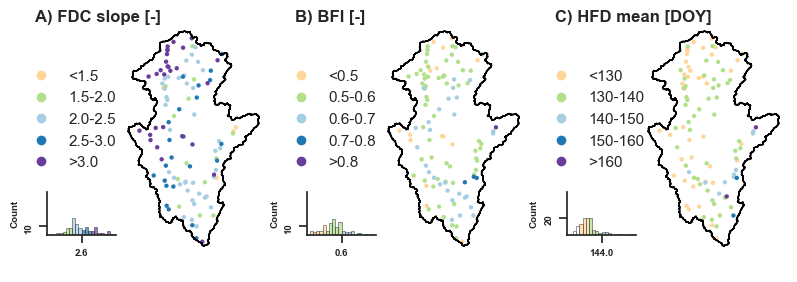

In [112]:
df[["slope_sawicz", "baseflow_index", "hfd_mean"]] = df[["slope_obs", "bfi_obs", "hfd_obs"]]

# List of variables
variable_list = ["slope_sawicz", "baseflow_index", "hfd_mean"]

# Create custom y labels (adjust based on your data)
custom_legend_title = ['FDC slope [-]',  
                   "BFI [-]", 
                   "HFD mean [DOY]"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 3
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.8, 4.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, df, color_mapping_list, gdf)
    legend_title = custom_legend_title[i]
        
    axs[i].set_title(f'{chr(65+i)}) {legend_title}', loc="left", fontweight="bold", pad=0)  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=1)
    
    #FR_selected_gdf.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
#fig.savefig(r'results\figs\fig_signatures_attributes.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

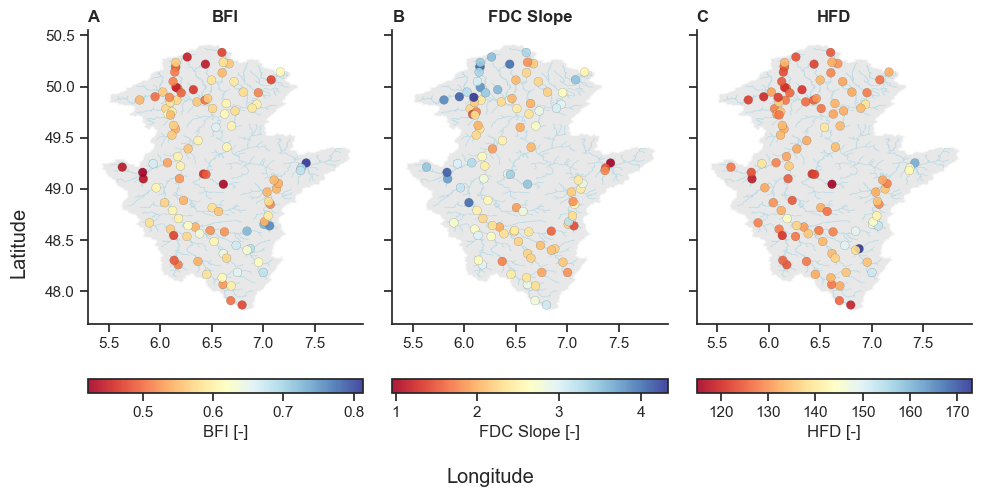

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Set style
sns.set_theme(style="ticks")

# Columns to plot and labels
obs_cols = ['bfi_obs', 'slope_obs', 'hfd_obs']
titles = ['A', 'B', 'C']
main_titles = ['BFI', 'FDC Slope', 'HFD']

# Colormap
cmaps = [plt.cm.RdYlBu, plt.cm.RdYlBu, plt.cm.RdYlBu]

# Determine value ranges for each observed variable
vmins = [df[col].min() for col in obs_cols]
vmaxs = [df[col].max() for col in obs_cols]

# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

for ax, col, letter, label, cmap, vmin, vmax in zip(axes, obs_cols, titles, main_titles, cmaps, vmins, vmaxs):
    # Plot background maps
    moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # Scatter colored by observation
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    # Subplot title
    ax.set_title(f"{letter}", loc="left", fontweight="bold")
    ax.set_title(f"{label}", fontsize=12, fontweight="bold", loc="center")

    ax.set_aspect('auto')
    ax.grid(False)
    sns.despine(ax=ax)

    # Colorbar below each subplot
    cbar = fig.colorbar(
        sc,
        ax=ax,
        orientation='horizontal',
        fraction=0.05,
        pad=0.15  # adjust vertical distance from plot
    )
    cbar.set_label(f"{label} [-]")

# Axis labels
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.tight_layout()
#plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\maps_signatures.png", dpi=300)

plt.show()


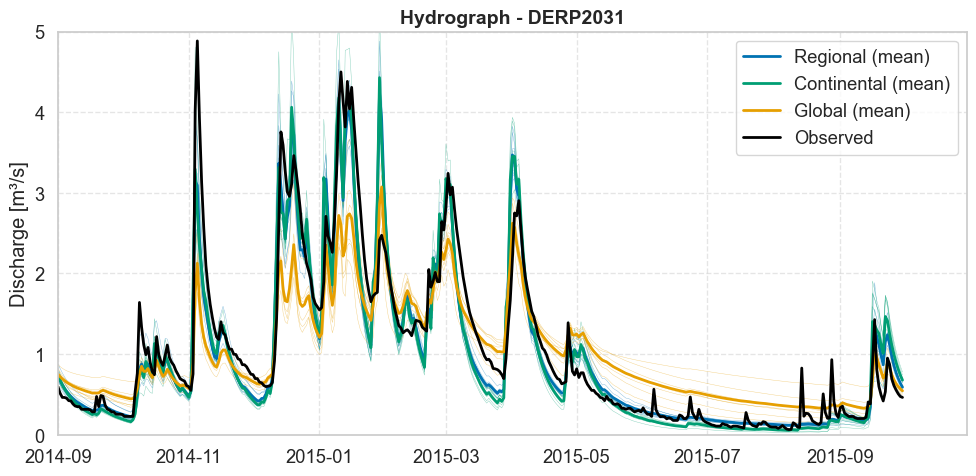

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------
# Parameters
# -------------------------------
gauge_id = "DERP2031"
start_date = '1988-10-01'
end_date = '2015-09-30'
focus_year = '2015'

# -------------------------------
# Time index and base dataframe
# -------------------------------
Qtimeseries = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='D'))
Qtimeseries["Qobs"] = observations_cal[gauge_id]

# -------------------------------
# Helper function to collect simulations
# -------------------------------
def collect_simulations(output_dict, gauge_id):
    preds = []
    for group_dict in output_dict.values():
        if gauge_id in group_dict:
            preds.append(group_dict[gauge_id][0])
    return np.array(preds)  # shape: (n_groups, n_timesteps)

# -------------------------------
# Collect predictions
# -------------------------------
pred_r = collect_simulations(output_regional_dict_cal, gauge_id)
pred_c = collect_simulations(output_continental_dict_cal, gauge_id)
pred_g = collect_simulations(output_global_dict_cal, gauge_id)

# Add mean predictions to Qtimeseries
Qtimeseries["Qcalc_r"] = pred_r.mean(axis=0)
Qtimeseries["Qcalc_c"] = pred_c.mean(axis=0)
Qtimeseries["Qcalc_g"] = pred_g.mean(axis=0)

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Plot all individual group predictions (thin lines)
for pred_array, color in zip([pred_r, pred_c, pred_g], ['#0072B2', '#009E73', '#E69F00']):  # blue, green, orange
    for i in range(pred_array.shape[0]):
        ax.plot(Qtimeseries.index, pred_array[i], color=color, alpha=0.5, linewidth=0.3)

# Plot mean lines (thicker, darker)
ax.plot(Qtimeseries.index, Qtimeseries["Qcalc_r"], color='#0072B2', label="Regional (mean)", linewidth=2)
ax.plot(Qtimeseries.index, Qtimeseries["Qcalc_c"], color='#009E73', label="Continental (mean)", linewidth=2)
ax.plot(Qtimeseries.index, Qtimeseries["Qcalc_g"], color='#E69F00', label="Global (mean)", linewidth=2)

# Plot observed discharge
ax.plot(Qtimeseries.index, Qtimeseries["Qobs"], color='black', label="Observed", linewidth=2)

# Focus on a specific year (e.g. 2015)
ax.set_xlim(pd.to_datetime(str(int(focus_year)-1) + "-09-01"), pd.to_datetime(focus_year + "-10-30"))
ax.set_ylim(0, 5)

# Final plot styling
ax.set_title(f"Hydrograph - {gauge_id}", fontsize=14, weight='bold')
ax.set_ylabel("Discharge [m³/s]")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR001179"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
#Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_dict_val["vienne_best_params_cont_Group_1"][gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_dict_val["vienne_best_params_glob_Group_1"][gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2015"].plot()

<Axes: >

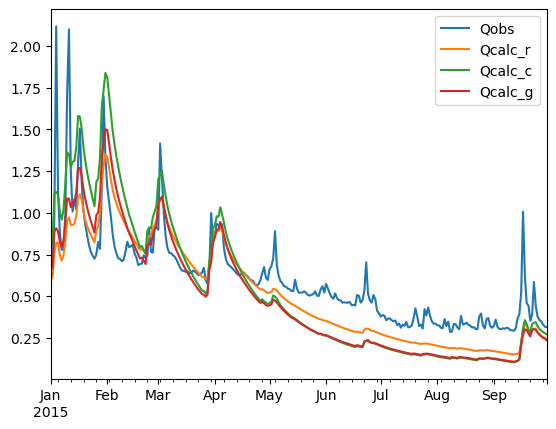

In [172]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2013"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2015"].plot()

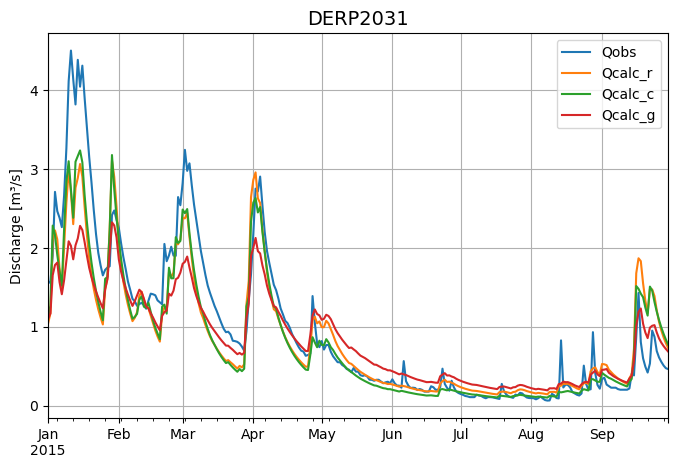

In [125]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

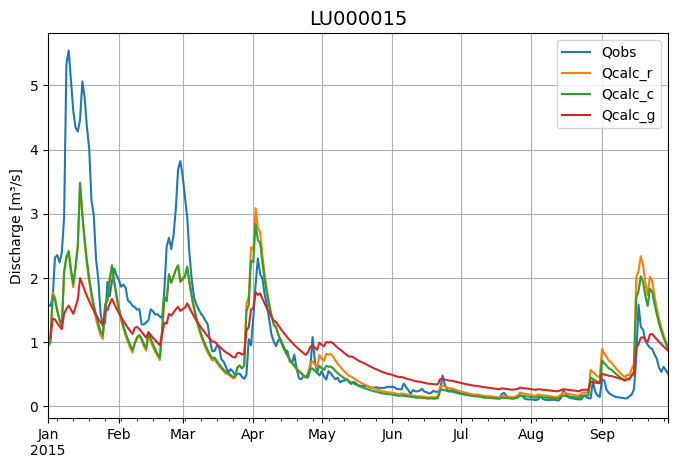

In [126]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000015"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

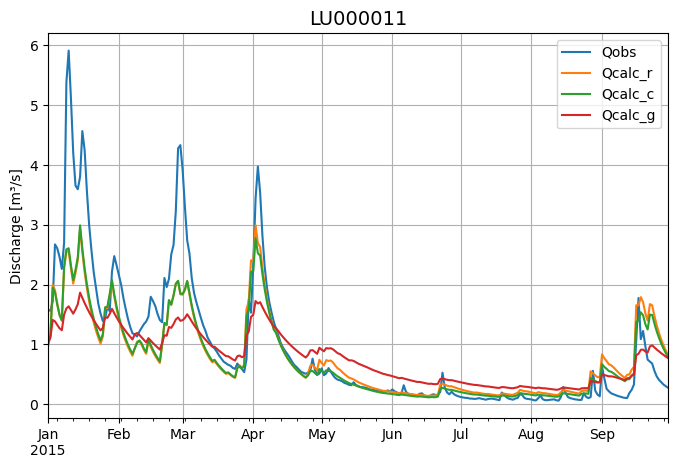

In [127]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000011"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

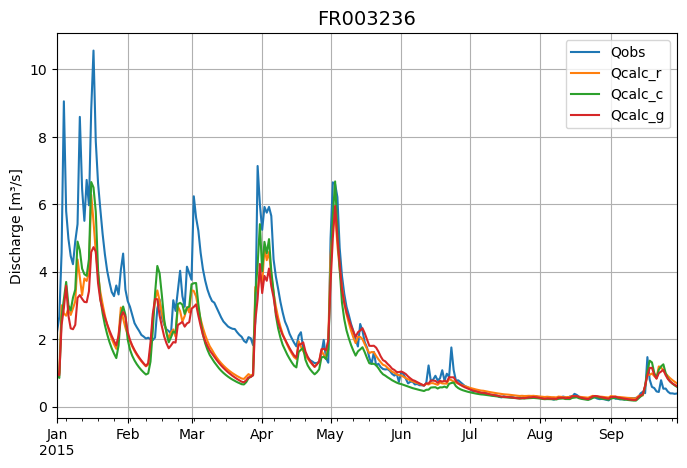

In [128]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003236"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

<Axes: >

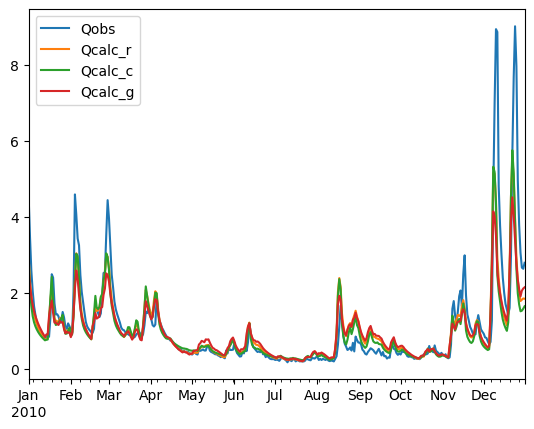

In [129]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1956"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

<Axes: >

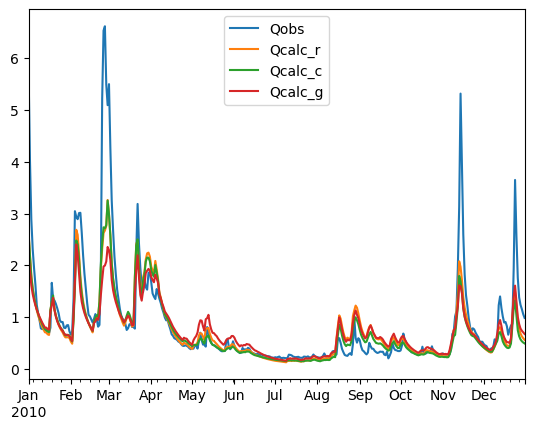

In [130]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

In [62]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse < 0.5]

gauge_name     basin       nse  \
8                                            A9021050  FR000185  0.287135   
16                                           A6232010  FR000144 -0.489820   
23                                           A6232010  FR000144 -0.489820   
36                                 Le Woigot Ã  Briey  FR003280  0.493093   
65                                           A6232010  FR000144 -0.489820   
70                         Le Canner Ã  KÅ“nigsmacker  FR003288  0.417412   
76                                            Contwig  DERP2013 -0.488618   
83  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259  0.194456   
98                               La Meurthe Ã  Fraize  FR003250  0.354904   

     bfi_obs   bfi_sim  nse_value_bfi  qmean_obs  qmean_sim  slope_obs  \
8   0.552725  0.745738            NaN   0.774233   1.179506   3.438700   
16  0.678912  0.758575            NaN   1.348492   1.181155   2.280050   
23  0.678912  0.758575            NaN   1.348492   1.181155   2.280050   
36  0.689765  0.544019            NaN   1.295303   0.884625   3.038034   
65  0.678912  0.758575            NaN   1.348492   1.181155   2.280050   
70  0.588279  0.632877            NaN   0.492836   0.645429   1.896325   
76  0.814145  0.778640      -1.972549   0.650233   0.793763   0.911240   
83  0.582905  0.712927            NaN   0.835544   1.307601   2.004998   
98  0.683506  0.566194            NaN   2.122664   1.538537   1.657028   

    slope_sim     hfd_obs     hfd_sim  
8    1.965252  157.500000  163.000000  
16   2.096348  178.444444  152.777778  
23   2.096348  178.444444  152.777778  
36   3.050208  138.076923  133.307692  
65   2.096348  178.444444  152.777778  
70   2.567747  128.846154  137.384615  
76   2.230657  161.615385  153.923077  
83   2.121848  143.285714  148.285714  
98   2.608849  154.250000  133.000000

In [292]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR000183"]

gauge_name     basin       nse   bfi_obs   bfi_sim  nse_value_bfi  \
51   A9001050  FR000183  0.813653  0.701242  0.744249            NaN   

    qmean_obs  qmean_sim  slope_obs  slope_sim     hfd_obs     hfd_sim  
51   1.099647   1.045212   1.964987   1.973349  146.272727  149.363636

In [293]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR003252"]

gauge_name     basin       nse  bfi_obs  \
66  La Meurthe Ã  Azerailles et Ã  Baccarat  FR003252  0.746247  0.68354   

     bfi_sim  nse_value_bfi  qmean_obs  qmean_sim  slope_obs  slope_sim  \
66  0.682204            NaN   1.860452   1.575774   2.360902   2.057833   

       hfd_obs     hfd_sim  
66  153.833333  147.666667

In [294]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR003254"]

gauge_name     basin       nse   bfi_obs  \
68  La Vezouze Ã  BlÃ¢mont et Ã  FrÃ©monville  FR003254  0.731087  0.679523   

     bfi_sim  nse_value_bfi  qmean_obs  qmean_sim  slope_obs  slope_sim  \
68  0.748233            NaN   1.230142   0.987262   2.007317   2.101612   

    hfd_obs     hfd_sim  
68    144.0  153.666667

In [79]:
nse_results_cal_c_1_100[nse_results_cal_c_1_100.nse < 0.5]

gauge_name     basin        nse  \
2                                           Martelange  BEWA0087 -20.952601   
18                                             Contwig  DERP2013   0.284077   
21                                            Saarburg  DERP2016   0.312854   
29                                        Eisenschmitt  DERP2028   0.322533   
30                                               Dreis  DERP2029   0.437715   
38                                            A4333010  FR000132   0.357028   
43                                            A6232010  FR000144  -0.120584   
52                                            A9013050  FR000184   0.494479   
53                                            A9021050  FR000185   0.161288   
64                                La Meurthe Ã  Fraize  FR003250   0.239730   
71   L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259   0.193627   
82                                  Le Woigot Ã  Briey  FR003280   0.322592   
85                          Le Canner Ã  KÅ“nigsmacker  FR003288   0.470042   
93                              L'Horn Ã  Bousseviller  FR003303  -0.462152   
94                             La Bisten Ã  Creutzwald  FR003306  -0.102476   
105                                            Livange  LU000013   0.338758   
110                                         Schoenfels  LU000018   0.303242   

      bfi_obs   bfi_sim  nse_value_bfi  qmean_obs  qmean_sim  slope_obs  \
2    0.715474  0.541796            NaN   0.196649   1.271732   1.740044   
18   0.814145  0.903759      -0.571054   0.650233   0.758876   0.911240   
21   0.670428  0.494655      -0.708736   0.790717   0.738667   1.843940   
29   0.601355  0.895222      -0.036490   0.955417   0.844708   2.127521   
30   0.581470  0.864318      -0.350848   0.719485   0.764893   2.157646   
38   0.663813  0.523920            NaN   1.738141   2.182535   1.942057   
43   0.678912  0.789053            NaN   1.348492   1.174152   2.280050   
52   0.768679  0.899653            NaN   1.281813   1.146868   1.627801   
53   0.552725  0.819895            NaN   0.774233   1.132219   3.438700   
64   0.683506  0.539023            NaN   2.122664   1.532101   1.657028   
71   0.582905  0.762571            NaN   0.835544   1.290177   2.004998   
82   0.689765  0.481574            NaN   1.295303   0.851529   3.038034   
85   0.588279  0.600917            NaN   0.492836   0.600070   1.896325   
93   0.795316  0.913669      -2.438761   0.592017   0.830870   0.941575   
94   0.745898  0.833297            NaN   0.536542   0.583407   1.084262   
105  0.564653  0.482951      -0.071237   0.592969   0.750255   2.241160   
110  0.549042  0.871740      -0.479965   0.876011   0.790487   2.255653   

     slope_sim     hfd_obs     hfd_sim  
2     3.133023  149.666667  123.500000  
18    1.011156  161.615385  178.307692  
21    4.011947  141.615385  127.461538  
29    1.001812  133.000000  176.461538  
30    1.117771  133.615385  169.923077  
38    2.880786  134.636364  122.818182  
43    1.358923  178.444444  159.222222  
52    1.078761  149.666667  175.666667  
53    1.184193  157.500000  173.833333  
64    2.899255  154.250000  129.750000  
71    1.498707  143.285714  155.714286  
82    4.251318  138.076923  126.923077  
85    2.603519  128.846154  134.076923  
93    0.975585  154.769231  181.769231  
94    1.071141  153.428571  168.142857  
105   4.263014  133.538462  126.692308  
110   1.054332  127.384615  170.615385

In [63]:
len(nse_results_cal_r_1_100_8801[nse_results_cal_r_1_100_8801.nse < 0.5])

13

In [64]:
len(nse_results_cal_c_1_100_8801[nse_results_cal_c_1_100_8801.nse < 0.5])

14

In [65]:
len(nse_results_cal_g_1_100_8801[nse_results_cal_g_1_100_8801.nse < 0.5])

12

In [179]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [83]:
nse_results_cal_r_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.352785
DERP2017    0.867801
DERP2011    0.819390
DERP2013    0.234303
DERP2007    0.856445
DERP2024    0.879439
FR003253    0.773447
FR003283    0.727192
FR003301    0.855149
DERP2003    0.885016
FR003265    0.902029
FR003272    0.880370
DEBU1958    0.902156
Name: nse, dtype: float64

In [84]:
nse_results_cal_c_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.486031
DERP2017    0.841313
DERP2011    0.780354
DERP2013    0.123369
DERP2007    0.820179
DERP2024    0.862515
FR003253    0.793678
FR003283    0.713177
FR003301    0.821363
DERP2003    0.854755
FR003265    0.896927
FR003272    0.877333
DEBU1958    0.889595
Name: nse, dtype: float64

In [85]:
nse_results_cal_g_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.465567
DERP2017    0.730429
DERP2011    0.806612
DERP2013    0.141411
DERP2007    0.866385
DERP2024    0.876119
FR003253    0.808930
FR003283    0.731916
FR003301    0.838486
DERP2003    0.790638
FR003265    0.903852
FR003272    0.884194
DEBU1958    0.895964
Name: nse, dtype: float64

In [86]:
nse_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.659844
DERP2017    0.838269
DERP2011    0.772581
DERP2013    0.176162
DERP2007    0.804265
DERP2024    0.835266
FR003253    0.765287
FR003283    0.759701
FR003301    0.821211
DERP2003    0.860527
FR003265    0.882589
FR003272    0.851035
DEBU1958    0.899955
Name: nse, dtype: float64

In [87]:
nse_results_cal_c_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.494479
DERP2017    0.806931
DERP2011    0.754340
DERP2013    0.284077
DERP2007    0.791043
DERP2024    0.836585
FR003253    0.755521
FR003283    0.778456
FR003301    0.852679
DERP2003    0.870758
FR003265    0.906480
FR003272    0.865265
DEBU1958    0.914803
Name: nse, dtype: float64

In [88]:
nse_results_cal_g_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.691362
DERP2017    0.750994
DERP2011    0.779291
DERP2013    0.108688
DERP2007    0.828013
DERP2024    0.833642
FR003253    0.793202
FR003283    0.758378
FR003301    0.818336
DERP2003    0.786225
FR003265    0.892816
FR003272    0.859693
DEBU1958    0.898294
Name: nse, dtype: float64

In [137]:
data_diff_val_complete[["lon", "lat"]] = network_estreams[["lon", "lat"]]
data_diff_val_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.033513  0.295382  0.838430  0.804917  0.543048         NaN   
BEWA0067  0.047152  0.236029  0.788691  0.741539  0.552662         NaN   
BEWA0106  0.017845  0.413216  0.764083  0.746238  0.350867         NaN   
BEWA0107  0.010444  0.303428  0.740081  0.729637  0.436653         NaN   
BEWA0119  0.025248  0.267249  0.815924  0.790676  0.548675         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.054974  0.467338  0.819813  0.764840  0.352475         NaN   
LU000016 -0.038874  0.026691  0.636273  0.675147  0.609581         NaN   
LU000017  0.031045  0.077578  0.860150  0.829105  0.782572         NaN   
LU000018  0.228038  0.073499  0.630852  0.402814  0.557353         NaN   
LU000019  0.043932  0.211781  0.818594  0.774662  0.606813         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  slope_obs  \
basin                                                 ...              
BEWA0066         NaN         NaN  0.515742  0.550943  ...   3.400558   
BEWA0067         NaN         NaN  0.446878  0.537480  ...   3.527884   
BEWA0106         NaN         NaN  0.496805  0.547966  ...   4.063631   
BEWA0107         NaN         NaN  0.565063  0.536219  ...   3.418299   
BEWA0119         NaN         NaN  0.508101  0.545023  ...   3.336434   
...              ...         ...       ...       ...  ...        ...   
LU000015         NaN         NaN  0.516853  0.551345  ...   4.331634   
LU000016         NaN         NaN  0.564940  0.522122  ...   2.005883   
LU000017         NaN         NaN  0.572433  0.591535  ...   2.459555   
LU000018         NaN         NaN  0.549133  0.653295  ...   2.305895   
LU000019         NaN         NaN  0.492709  0.555690  ...   3.428468   

          slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1      hfd_c1  \
basin                                                                        
BEWA0066  3.121880  2.554032  1.713252  126.294118  129.588235  134.941176   
BEWA0067  3.133557  2.543764  1.836960  123.437500  129.187500  137.500000   
BEWA0106  3.118763  2.623174  1.562442  127.000000  130.739130  134.869565   
BEWA0107  3.138160  2.724969  1.713870  133.588235  134.058824  138.647059   
BEWA0119  3.139372  2.679279  1.866495  123.266667  129.400000  133.333333   
...            ...       ...       ...         ...         ...         ...   
LU000015  2.995448  2.226096  1.351069  121.769231  124.384615  132.461538   
LU000016  3.044009  2.571448  3.110440  133.615385  126.000000  132.230769   
LU000017  2.591746  1.990153  1.716308  127.307692  129.461538  136.692308   
LU000018  1.958625  1.325345  3.123006  127.384615  134.769231  156.538462   
LU000019  2.845910  2.199701  1.584363  125.846154  128.307692  136.307692   

              hfd_g1       lon        lat  
basin                                      
BEWA0066  156.176471  6.151802  50.188258  
BEWA0067  152.687500  6.263467  50.289277  
BEWA0106  164.260870  6.150669  50.196522  
BEWA0107  165.823529  6.153955  50.234494  
BEWA0119  153.933333  6.141814  50.141935  
...              ...       ...        ...  
LU000015  163.615385  6.091178  49.895421  
LU000016  127.230769  6.132266  49.620647  
LU000017  144.000000  6.509851  49.785883  
LU000018  126.615385  6.100795  49.723112  
LU000019  152.000000  6.204738  49.939224  

[98 rows x 26 columns]

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd

In [158]:
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

In [262]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


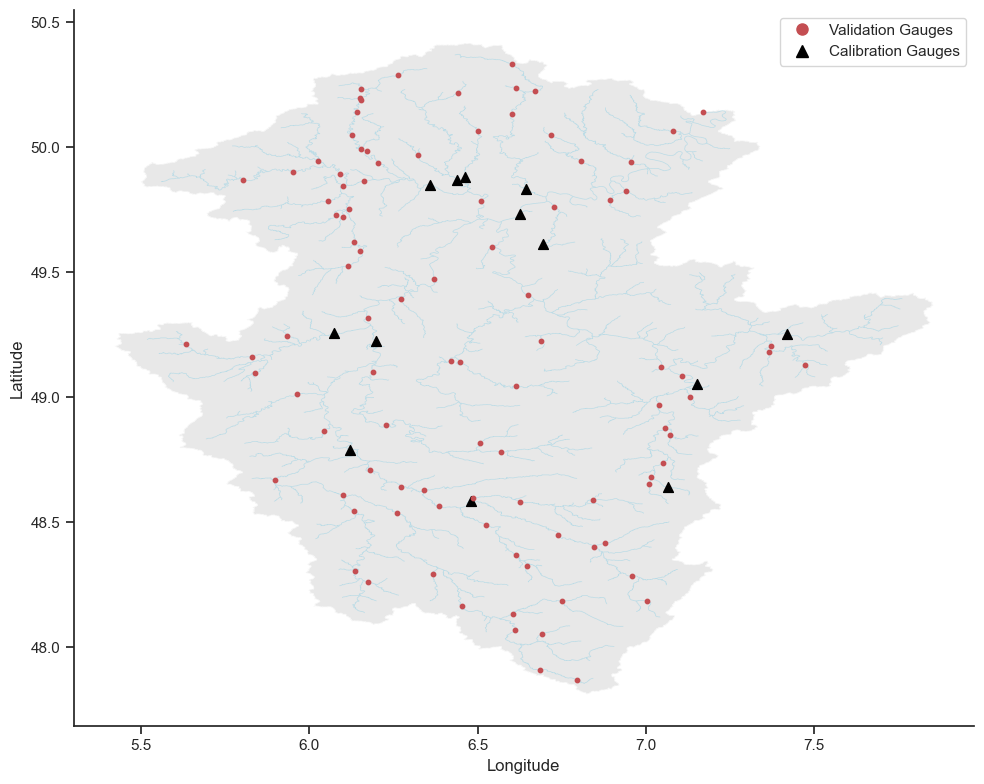

In [263]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
LU000018  0.165330 -0.005979  0.643927  0.478597  0.649906         NaN   
LU000010  0.118536  0.074434  0.710777  0.592241  0.636343         NaN   
LU000001  0.002910  0.160013  0.827942  0.825032  0.667929         NaN   
DERP2028  0.004380 -0.076293  0.631966  0.627586  0.708260    0.578659   
FR000183  0.009503 -0.001809  0.476467  0.466965  0.478277         NaN   
...            ...       ...       ...       ...       ...         ...   
DERP2007  0.000284 -0.009585  0.780389  0.780105  0.789974    0.813876   
FR003271 -0.010294  0.015875  0.706475  0.716769  0.690601         NaN   
FR003301  0.012553 -0.014131  0.782955  0.770402  0.797086         NaN   
DERP2003 -0.000614  0.049263  0.833300  0.833914  0.784037    0.820951   
DEBU1958 -0.006687 -0.002657  0.838536  0.845223  0.841193    0.797083   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
LU000018         NaN         NaN  0.549133  0.663651  ...  0.747819  0.753208   
LU000010         NaN         NaN  0.618760  0.667081  ...  0.834394  0.840603   
LU000001         NaN         NaN  0.546850  0.558409  ...  1.070685  1.082947   
DERP2028    0.569747    0.699353  0.591229  0.771450  ...  1.007220  0.990973   
FR000183         NaN         NaN  0.726346  0.737001  ...  1.129375  1.117234   
...              ...         ...       ...       ...  ...       ...       ...   
DERP2007    0.791860    0.771415  0.500914  0.615233  ...  1.064938  1.048703   
FR003271         NaN         NaN  0.543269  0.604438  ...  0.705003  0.695529   
FR003301         NaN         NaN  0.540766  0.653930  ...  0.892364  0.888493   
DERP2003    0.800374    0.709295  0.559353  0.617683  ...  1.042582  1.024533   
DEBU1958    0.785791    0.813394  0.610254  0.659256  ...  1.039447  1.026830   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
LU000018   2.305895  2.126032  1.752822  2.940732  127.384615  139.230769   
LU000010   1.430667  2.156746  1.903346  2.982150  130.615385  138.615385   
LU000001   3.860265  2.508516  2.444504  1.978572  121.615385  129.230769   
DERP2028   2.249833  2.012464  2.052597  2.119470  131.461538  152.653846   
FR000183   2.204864  2.113599  2.233890  2.270498  147.250000  147.500000   
...             ...       ...       ...       ...         ...         ...   
DERP2007   2.915571  2.503010  2.523587  2.837581  124.884615  136.423077   
FR003271   2.584565  2.792069  2.574238  3.001353  124.560000  132.960000   
FR003301   2.879739  2.441276  2.348354  2.595211  128.187500  137.562500   
DERP2003   2.285585  2.524204  2.495626  2.260114  126.346154  135.230769   
DEBU1958   2.353118  2.437957  2.483600  2.545480  131.615385  136.884615   

              hfd_c1      hfd_g1  
basin                             
LU000018  146.230769  129.615385  
LU000010  143.692308  128.923077  
LU000001  129.000000  145.846154  
DERP2028  149.269231  147.115385  
FR000183  143.791667  142.708333  
...              ...         ...  
DERP2007  134.884615  135.923077  
FR003271  134.040000  130.440000  
FR003301  137.187500  134.687500  
DERP2003  134.576923  140.884615  
DEBU1958  135.346154  135.692308  

[92 rows x 24 columns]

In [40]:
df = data_diff_val_complete.copy()
df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_r1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_4688\1350808124.py:2: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]


ValueError: cannot reindex on an axis with duplicate labels

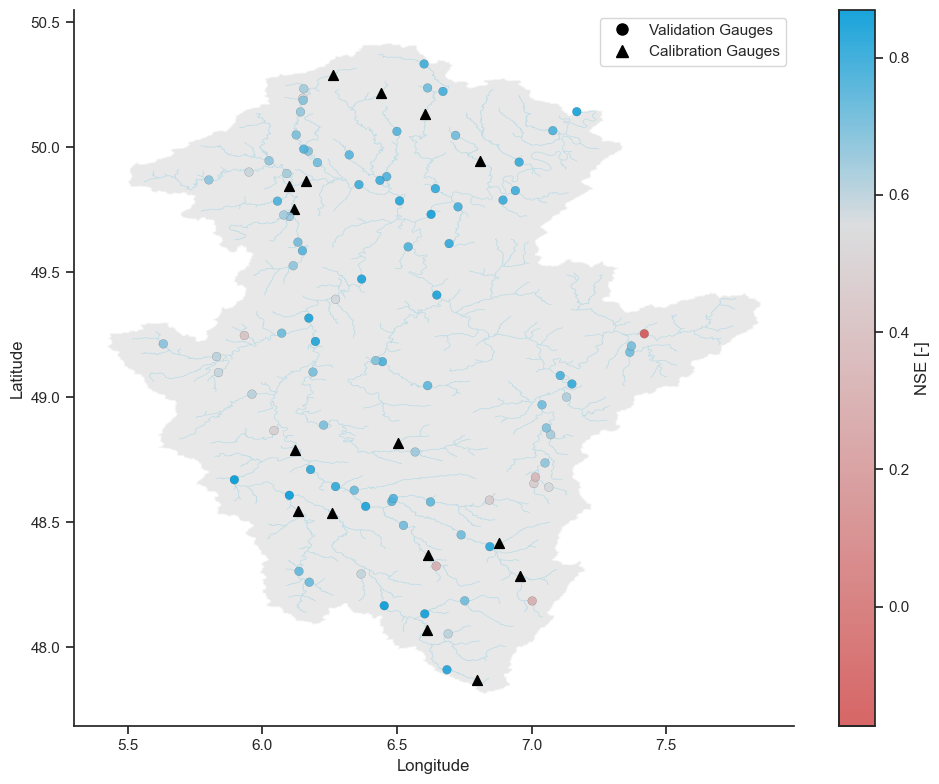

In [162]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_g1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE [-]", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


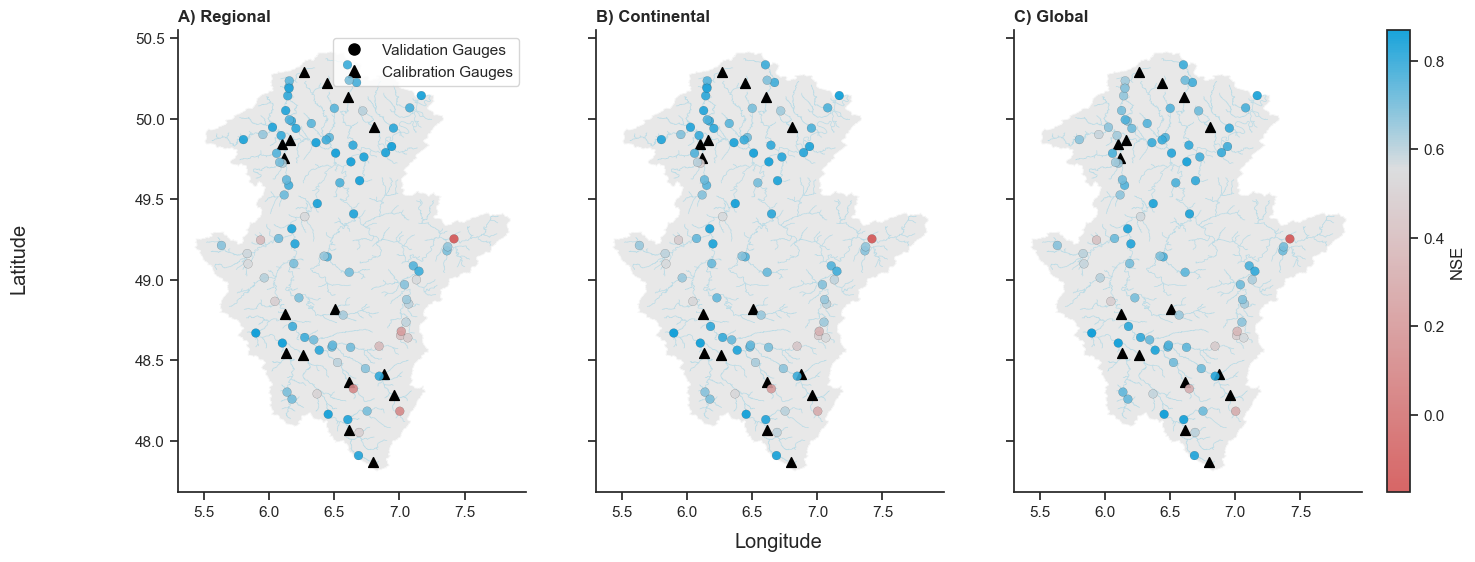

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Create figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

# NSE columns to plot
nse_cols = ['nse_r1', 'nse_c1', 'nse_g1']
titles = ['A) Regional', 'B) Continental', 'C) Global']

for ax, col, title in zip(axes, nse_cols, titles):
    moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # Calibration basins (triangle)
    ax.scatter(
        network_estreams.loc[list_cal, 'lon'],
        network_estreams.loc[list_cal, 'lat'],
        marker='^',
        color='black',
        s=50,
        zorder=3,
        label='Calibrated Basins'
    )

    # NSE scatter
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    ax.set_title(title, loc="left", fontweight="bold")
    ax.set_aspect('auto')
    ax.grid(False)
    sns.despine(ax=ax)

    # Add legend only to the first plot
    if ax == axes[0]:
        validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                          markersize=8, label='Validation Gauges')
        calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                           markersize=8, label='Calibration Gauges')
        ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')

# Shared labels and colorbar
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

# One colorbar for all
#bar = fig.colorbar(sc, ax=axes.ravel().tolist(), label='NSE', shrink=0.8)
# Add a vertical colorbar on the extreme right
cbar = fig.colorbar(
    sc, 
    ax=axes, 
    orientation='vertical', 
    fraction=0.025,  # controls the thickness
    pad=0.02         # controls the distance from the last subplot
)
cbar.set_label('NSE')

#plt.tight_layout()
plt.show()


<Axes: >

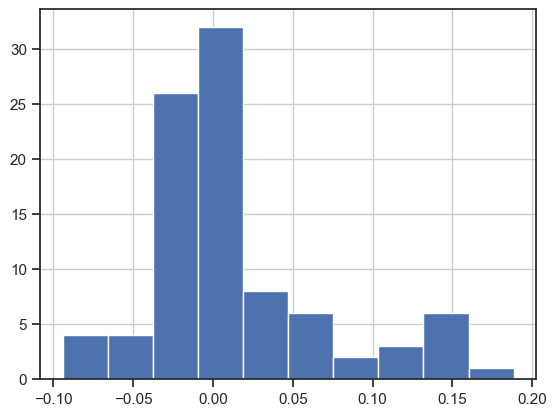

In [164]:
df['nse_rg'].hist()

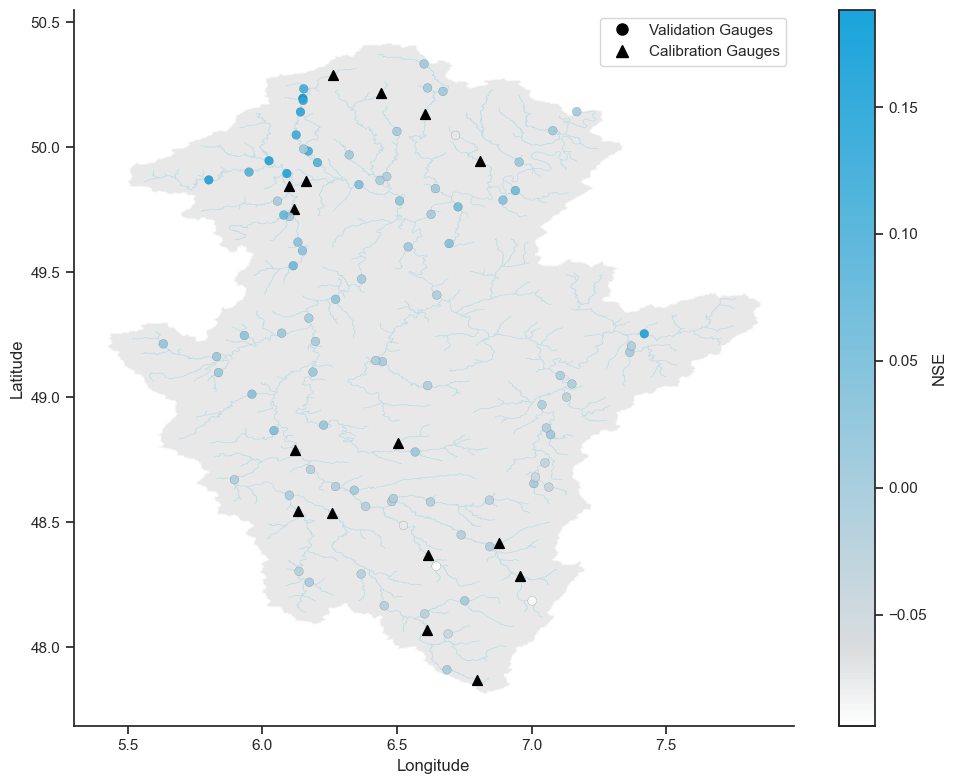

In [168]:
df = data_diff_val_complete.copy()
df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, 'white'), (0.1, '#d8dadc'), (1, '#009ad8')]
)


# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_rg'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


### Group 2: second half

In [212]:
list_cal = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 #'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

In [103]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional2, observations, quality_masks)
nse_results_cal_c_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental2, observations, quality_masks)
nse_results_cal_g_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global2, observations, quality_masks)

path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_88012, observations, quality_masks)
nse_results_cal_c_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_88012, observations, quality_masks)
nse_results_cal_g_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_88012, observations, quality_masks)


path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()


observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal2 = {
    key: [np.concatenate([output_regional_88012[key][0], output_regional2[key][0]])]
    for key in output_regional_88012
    if key in output_regional2  # ensures keys match
}

output_continental_cal2 = {
    key: [np.concatenate([output_continental_88012[key][0], output_continental2[key][0]])]
    for key in output_continental_88012
    if key in output_continental2  # ensures keys match
}

output_global_cal2 = {
    key: [np.concatenate([output_global_88012[key][0], output_global2[key][0]])]
    for key in output_global_88012
    if key in output_global2  # ensures keys match
}


nse_results_cal_r_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal2, observations_cal, quality_masks_cal)

c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_18512\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:1

In [104]:
data_diff_cal_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_c_2_100_complete_cal.nse)
data_diff_cal_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_g_2_100_complete_cal.nse

data_diff_cal_complete2.index = nse_results_cal_c_2_100_complete_cal.basin

data_diff_cal_complete2 = data_diff_cal_complete2.loc[~data_diff_cal_complete2.index.isin(list_cal)]

data_diff_cal_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete2 = data_diff_cal_complete2[data_diff_cal_complete2.nse_r1 > -10.0]
data_diff_cal_complete2

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.025793  0.310020  0.829036  0.854830  0.519017         NaN   
BEWA0067 -0.034845  0.234069  0.768075  0.802919  0.534006         NaN   
BEWA0106 -0.029836  0.487017  0.763070  0.792906  0.276053         NaN   
BEWA0107 -0.002470  0.396842  0.759315  0.761785  0.362473         NaN   
BEWA0119 -0.015906  0.310934  0.816860  0.832765  0.505925         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.060333  0.383704  0.784399  0.844733  0.400695         NaN   
LU000016  0.113749  0.058466  0.657855  0.544106  0.599389         NaN   
LU000017 -0.018020  0.066757  0.844705  0.862725  0.777947         NaN   
LU000018  0.354214  0.038581  0.603627  0.249413  0.565046         NaN   
LU000019 -0.027019  0.189421  0.803508  0.830528  0.614088         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.573456  ...  1.307285  1.234615   
BEWA0067         NaN         NaN  0.446878  0.560397  ...  1.397150  1.323675   
BEWA0106         NaN         NaN  0.496805  0.572535  ...  1.021858  0.983790   
BEWA0107         NaN         NaN  0.565063  0.557326  ...  1.429620  1.321399   
BEWA0119         NaN         NaN  0.508101  0.567503  ...  1.325504  1.260757   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.570479  ...  1.013724  0.962041   
LU000016         NaN         NaN  0.564940  0.555673  ...  0.696155  0.690550   
LU000017         NaN         NaN  0.572433  0.606628  ...  0.873031  0.845101   
LU000018         NaN         NaN  0.549133  0.653455  ...  0.709651  0.738120   
LU000019         NaN         NaN  0.492709  0.576481  ...  1.109100  1.039742   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.743290  3.195068  1.777066  126.294118  137.294118   
BEWA0067   3.527884  2.698627  3.134984  1.860673  123.437500  138.937500   
BEWA0106   4.063631  2.783658  3.291014  1.591152  127.000000  136.521739   
BEWA0107   3.418299  2.795479  3.137608  1.671909  133.588235  141.411765   
BEWA0119   3.336434  2.753243  3.131224  1.822339  123.266667  136.400000   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.573227  3.314807  1.744927  121.769231  135.076923   
LU000016   2.005883  2.774134  3.753879  3.276128  133.615385  134.384615   
LU000017   2.459555  2.377061  2.690857  1.983503  127.307692  137.769231   
LU000018   2.305895  2.186313  0.937234  3.278503  127.384615  142.230769   
LU000019   3.428468  2.495747  3.099580  1.802259  125.846154  137.076923   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  130.352941  159.352941  
BEWA0067  130.562500  154.750000  
BEWA0106  133.000000  171.000000  
BEWA0107  133.941176  168.588235  
BEWA0119  130.600000  157.133333  
...              ...         ...  
LU000015  128.000000  164.692308  
LU000016  130.076923  130.538462  
LU000017  133.076923  147.846154  
LU000018  172.538462  129.692308  
LU000019  130.230769  154.384615  

[98 rows x 24 columns]

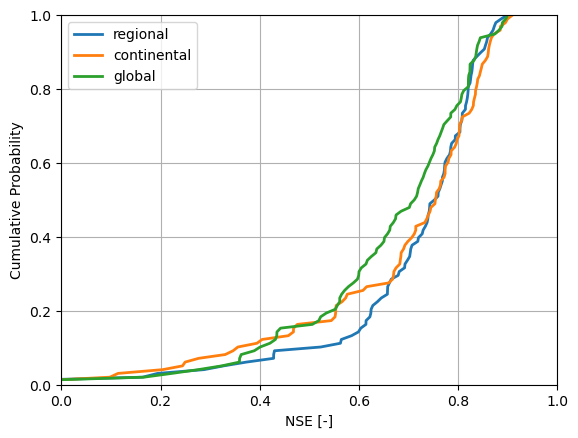

In [105]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

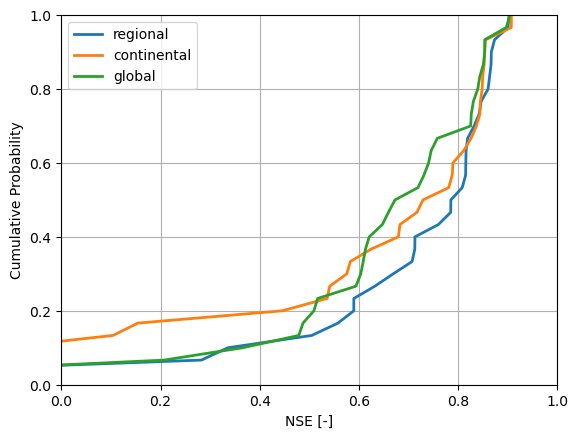

In [106]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


#### Validation

In [108]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

In [109]:
output_regional_val_c2 = {
    key: [np.concatenate([output_regional_val2[key][0], output_regional_01152[key][0]])]
    for key in output_regional_01152
    if key in output_regional_val2  # ensures keys match
}

output_continental_val_c2 = {
    key: [np.concatenate([output_continental_val2[key][0], output_continental_01152[key][0]])]
    for key in output_continental_val2
    if key in output_continental_01152  # ensures keys match
}

output_global_val_c2 = {
    key: [np.concatenate([output_global_val2[key][0], output_global_01152[key][0]])]
    for key in output_global_val2
    if key in output_global_01152  # ensures keys match
}

In [110]:
nse_results_cal_r_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c2, observations_cal, quality_masks_cal)

In [134]:
data_diff_val_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_c_2_100_complete_val.nse)
data_diff_val_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_g_2_100_complete_val.nse

data_diff_val_complete2.index = nse_results_cal_c_2_100_complete_val.basin

data_diff_val_complete2 = data_diff_val_complete2.loc[~data_diff_val_complete2.index.isin(list_cal)]

data_diff_val_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete2 = data_diff_val_complete2[data_diff_val_complete2.nse_r1 > -10.0]
data_diff_val_complete2




nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.005718  0.355179  0.821671  0.827389  0.466492         NaN   
BEWA0067 -0.009087  0.261289  0.755194  0.764281  0.493905         NaN   
BEWA0106 -0.024381  0.494743  0.750625  0.775006  0.255882         NaN   
BEWA0107  0.010143  0.427166  0.761236  0.751093  0.334070         NaN   
BEWA0119 -0.002562  0.319474  0.804388  0.806950  0.484914         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.008877  0.594414  0.808341  0.817218  0.213927         NaN   
LU000016  0.032608  0.082443  0.612132  0.579524  0.529689         NaN   
LU000017  0.003530  0.087533  0.834798  0.831269  0.747265         NaN   
LU000018  0.301340  0.074659  0.573180  0.271840  0.498521         NaN   
LU000019 -0.000169  0.249563  0.799957  0.800125  0.550393         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.571076  ...  1.229881  1.190466   
BEWA0067         NaN         NaN  0.446878  0.555953  ...  1.289278  1.264698   
BEWA0106         NaN         NaN  0.496805  0.571488  ...  1.026590  0.976160   
BEWA0107         NaN         NaN  0.565063  0.555682  ...  1.408629  1.316139   
BEWA0119         NaN         NaN  0.508101  0.565601  ...  1.308257  1.251409   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.571037  ...  0.906454  0.889642   
LU000016         NaN         NaN  0.564940  0.555008  ...  0.638566  0.644934   
LU000017         NaN         NaN  0.572433  0.610980  ...  0.787699  0.785198   
LU000018         NaN         NaN  0.549133  0.670544  ...  0.669237  0.692219   
LU000019         NaN         NaN  0.492709  0.574219  ...  0.976711  0.966127   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.868569  3.061155  1.599769  126.294118  135.352941   
BEWA0067   3.527884  2.914973  3.098414  1.715402  123.437500  136.937500   
BEWA0106   4.063631  2.857153  3.179807  1.408204  127.000000  136.086957   
BEWA0107   3.418299  2.874452  3.142920  1.562104  133.588235  139.411765   
BEWA0119   3.336434  2.884838  3.082609  1.748002  123.266667  134.800000   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.747176  2.931268  1.237538  121.769231  129.923077   
LU000016   2.005883  2.862135  3.078900  3.457008  133.615385  130.461538   
LU000017   2.459555  2.438855  2.459436  1.693942  127.307692  134.307692   
LU000018   2.305895  1.994191  1.138147  3.458827  127.384615  140.076923   
LU000019   3.428468  2.639825  2.847832  1.511136  125.846154  133.846154   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  132.058824  163.529412  
BEWA0067  133.937500  158.187500  
BEWA0106  133.043478  173.478261  
BEWA0107  135.470588  175.529412  
BEWA0119  130.933333  160.666667  
...              ...         ...  
LU000015  129.461538  174.846154  
LU000016  129.923077  127.000000  
LU000017  134.538462  147.230769  
LU000018  167.230769  126.615385  
LU000019  132.769231  157.538462  

[98 rows x 24 columns]

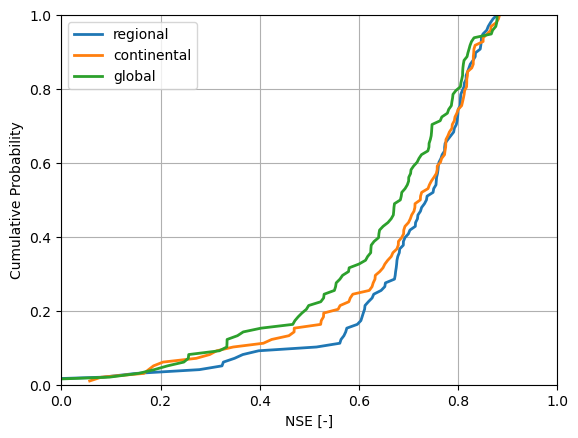

In [135]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

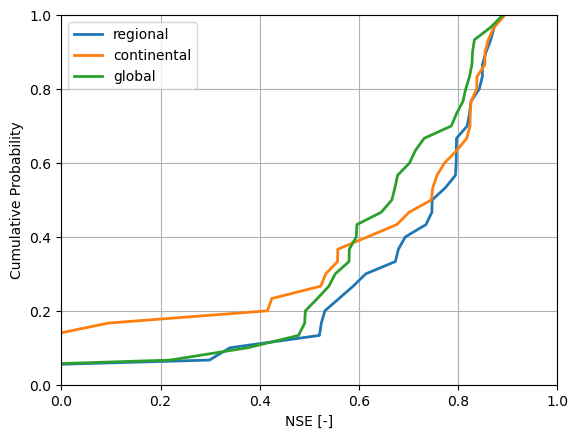

In [115]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

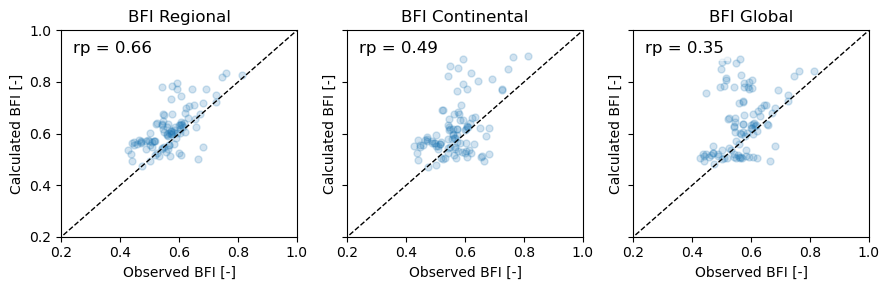

In [117]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["bfi_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

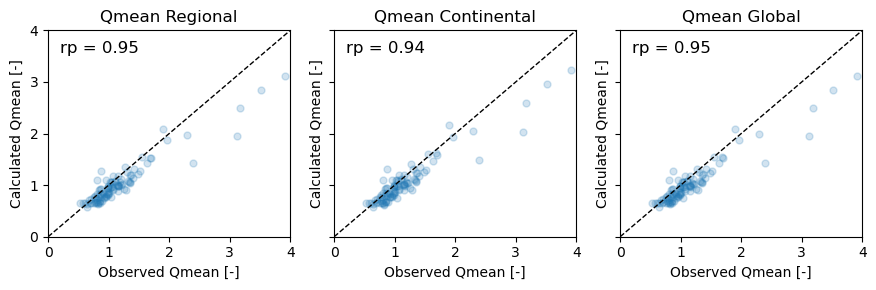

In [119]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["qmean_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

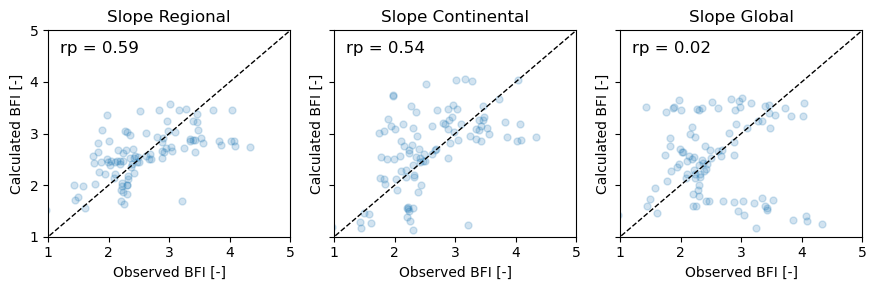

In [121]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["slope_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

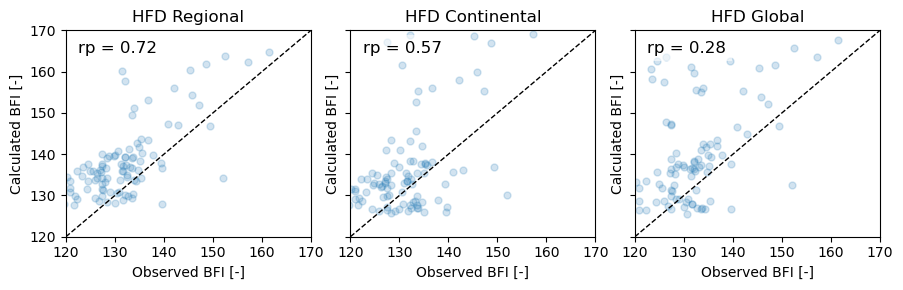

In [122]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["hfd_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

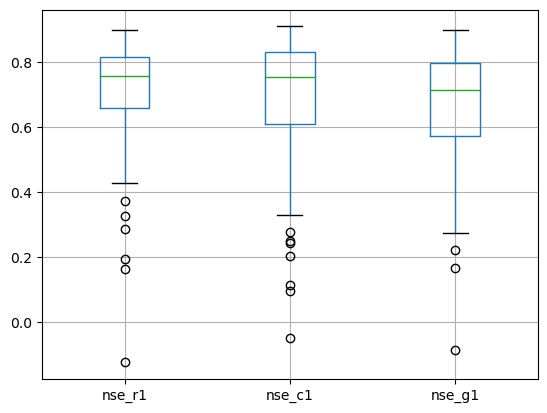

In [124]:


# Plot both columns side by side
data_diff_cal_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



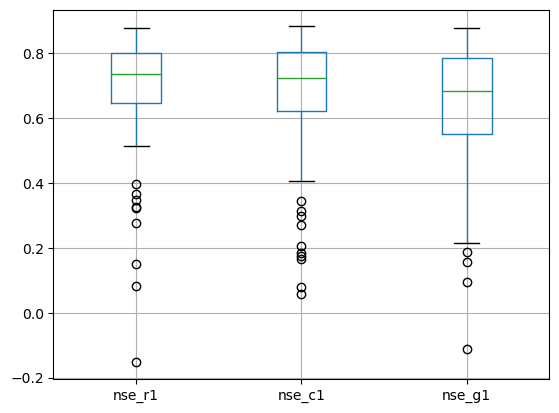

In [125]:


# Plot both columns side by side
data_diff_val_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



In [127]:
data_diff_val_complete2[data_diff_val_complete2.nse_r1 < 0.5]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
DERP2013 -0.083075 -0.013097  0.083079  0.166154  0.096176   -0.585098   
FR000183 -0.009516 -0.004917  0.397711  0.407226  0.402628         NaN   
FR000184  0.180012  0.010754  0.365726  0.185714  0.354972         NaN   
FR000185  0.147979  0.005401  0.323789  0.175810  0.318388         NaN   
FR003250  0.070088 -0.005127  0.150458  0.080370  0.155585         NaN   
FR003254 -0.019839 -0.007303  0.326564  0.346403  0.333867         NaN   
FR003259  0.073407 -0.088387  0.278223  0.204816  0.366610         NaN   
FR003280  0.050043  0.015513  0.349008  0.298965  0.333495         NaN   
FR003306 -0.210191 -0.040751 -0.153152  0.057039 -0.112401         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
DERP2013   -0.408345   -0.554157  0.813898  0.827653  ...  0.771586  0.778427   
FR000183         NaN         NaN  0.726346  0.747846  ...  1.053525  1.040745   
FR000184         NaN         NaN  0.760768  0.832815  ...  1.076194  1.069917   
FR000185         NaN         NaN  0.541713  0.779659  ...  1.106566  1.096805   
FR003250         NaN         NaN  0.680834  0.547678  ...  1.490959  1.438213   
FR003254         NaN         NaN  0.723597  0.723494  ...  0.901611  0.898634   
FR003259         NaN         NaN  0.570623  0.732099  ...  1.305717  1.279329   
FR003280         NaN         NaN  0.664153  0.501144  ...  0.942279  0.919787   
FR003306         NaN         NaN  0.747143  0.818040  ...  0.617547  0.630695   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
DERP2013   0.958560  1.524482  1.192806  1.417545  161.346154  164.807692   
FR000183   2.204864  1.898045  1.555593  1.833309  147.250000  151.958333   
FR000184   1.439657  1.711659  1.161932  1.601227  152.480000  163.760000   
FR000185   3.206302  1.692572  1.223568  1.651249  145.277778  160.444444   
FR003250   1.818016  2.818138  3.039606  2.907354  152.040000  134.120000   
FR003254   1.571402  1.975920  1.441068  1.941028  148.625000  161.875000   
FR003259   2.215223  2.042469  1.546628  2.545800  136.647059  153.176471   
FR003280   3.012886  3.564313  4.041586  3.689990  139.576923  127.807692   
FR003306   1.611967  1.551600  1.269791  1.468984  157.166667  162.388889   

              hfd_c1      hfd_g1  
basin                             
DERP2013  179.538462  167.653846  
FR000183  155.250000  152.041667  
FR000184  179.160000  165.840000  
FR000185  168.611111  160.833333  
FR003250  130.080000  132.600000  
FR003254  167.000000  161.500000  
FR003259  156.058824  143.411765  
FR003280  125.884615  126.769231  
FR003306  169.222222  163.611111  

[9 rows x 24 columns]

In [128]:
data_diff_val_complete2[data_diff_val_complete2.nse_g1 < 0.5]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.005718  0.355179  0.821671  0.827389  0.466492         NaN   
BEWA0067 -0.009087  0.261289  0.755194  0.764281  0.493905         NaN   
BEWA0106 -0.024381  0.494743  0.750625  0.775006  0.255882         NaN   
BEWA0107  0.010143  0.427166  0.761236  0.751093  0.334070         NaN   
BEWA0119 -0.002562  0.319474  0.804388  0.806950  0.484914         NaN   
DERP2013 -0.083075 -0.013097  0.083079  0.166154  0.096176   -0.585098   
FR000183 -0.009516 -0.004917  0.397711  0.407226  0.402628         NaN   
FR000184  0.180012  0.010754  0.365726  0.185714  0.354972         NaN   
FR000185  0.147979  0.005401  0.323789  0.175810  0.318388         NaN   
FR003250  0.070088 -0.005127  0.150458  0.080370  0.155585         NaN   
FR003254 -0.019839 -0.007303  0.326564  0.346403  0.333867         NaN   
FR003259  0.073407 -0.088387  0.278223  0.204816  0.366610         NaN   
FR003280  0.050043  0.015513  0.349008  0.298965  0.333495         NaN   
FR003306 -0.210191 -0.040751 -0.153152  0.057039 -0.112401         NaN   
LU000001 -0.005823  0.587745  0.844431  0.850254  0.256686         NaN   
LU000005 -0.000984  0.345128  0.815907  0.816892  0.470780         NaN   
LU000008 -0.007099  0.505304  0.692645  0.699744  0.187342         NaN   
LU000010  0.215123  0.196519  0.673814  0.458691  0.477295         NaN   
LU000011 -0.004239  0.583124  0.829877  0.834116  0.246752         NaN   
LU000015 -0.008877  0.594414  0.808341  0.817218  0.213927         NaN   
LU000018  0.301340  0.074659  0.573180  0.271840  0.498521         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.571076  ...  1.229881  1.190466   
BEWA0067         NaN         NaN  0.446878  0.555953  ...  1.289278  1.264698   
BEWA0106         NaN         NaN  0.496805  0.571488  ...  1.026590  0.976160   
BEWA0107         NaN         NaN  0.565063  0.555682  ...  1.408629  1.316139   
BEWA0119         NaN         NaN  0.508101  0.565601  ...  1.308257  1.251409   
DERP2013   -0.408345   -0.554157  0.813898  0.827653  ...  0.771586  0.778427   
FR000183         NaN         NaN  0.726346  0.747846  ...  1.053525  1.040745   
FR000184         NaN         NaN  0.760768  0.832815  ...  1.076194  1.069917   
FR000185         NaN         NaN  0.541713  0.779659  ...  1.106566  1.096805   
FR003250         NaN         NaN  0.680834  0.547678  ...  1.490959  1.438213   
FR003254         NaN         NaN  0.723597  0.723494  ...  0.901611  0.898634   
FR003259         NaN         NaN  0.570623  0.732099  ...  1.305717  1.279329   
FR003280         NaN         NaN  0.664153  0.501144  ...  0.942279  0.919787   
FR003306         NaN         NaN  0.747143  0.818040  ...  0.617547  0.630695   
LU000001         NaN         NaN  0.546850  0.549100  ...  1.053798  1.034092   
LU000005         NaN         NaN  0.513152  0.570542  ...  1.031695  1.018697   
LU000008         NaN         NaN  0.500726  0.554382  ...  1.001060  0.982686   
LU000010         NaN         NaN  0.618760  0.678812  ...  0.761779  0.781072   
LU000011         NaN         NaN  0.562102  0.591542  ...  0.814662  0.799048   
LU000015         NaN         NaN  0.516853  0.571037  ...  0.906454  0.889642   
LU000018         NaN         NaN  0.549133  0.670544  ...  0.669237  0.692219   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.868569  3.061155  1.599769  126.294118  135.352941   
BEWA0067   3.527884  2.914973  3.098414  1.715402  123.437500  136.937500   
BEWA0106   4.063631  2.857153  3.179807  1.408204  127.000000  136.086957   
BEWA0107   3.418299  2.874452  3.142920  1.562104  133.588235  

In [214]:
data_diff_val_complete2[["lon", "lat"]] = network_estreams[["lon", "lat"]]

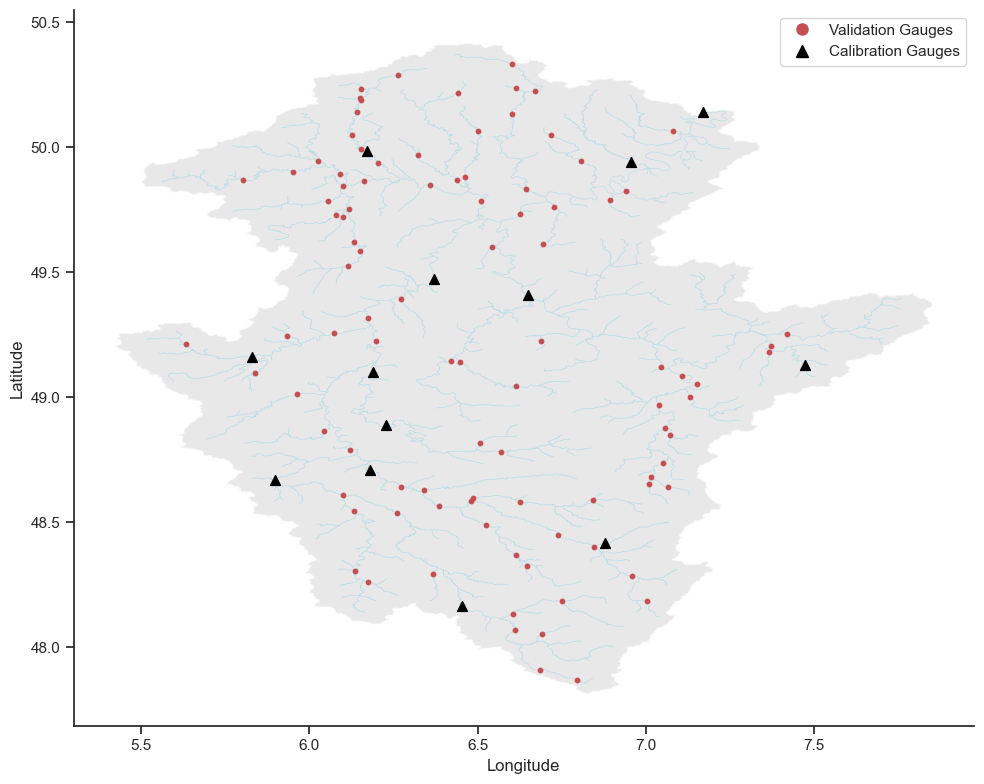

In [252]:
df = data_diff_val_complete2.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


In [ ]:
LU000016

In [251]:
perm_areasglobal

{'BEWA0066': [0.75, 0.25, 0.0],
 'BEWA0067': [0.64, 0.36, 0.0],
 'BEWA0087': [1.0, 0.0, 0.0],
 'BEWA0106': [1.0, 0.0, 0.0],
 'BEWA0107': [1.0, 0.0, 0.0],
 'BEWA0119': [0.75, 0.25, 0.0],
 'DEBU1956': [0.19, 0.73, 0.08],
 'DEBU1957': [0.33, 0.66, 0.01],
 'DEBU1958': [0.28, 0.68, 0.04],
 'DEBU1959': [0.31, 0.65, 0.04],
 'DERP2003': [0.5, 0.5, 0.0],
 'DERP2004': [0.59, 0.41, 0.0],
 'DERP2005': [0.0, 1.0, 0.0],
 'DERP2006': [0.0, 1.0, 0.0],
 'DERP2007': [0.07, 0.93, 0.0],
 'DERP2008': [0.01, 0.99, 0.0],
 'DERP2010': [0.23, 0.77, 0.0],
 'DERP2011': [0.23, 0.77, 0.0],
 'DERP2013': [0.92, 0.08, 0.0],
 'DERP2014': [0.67, 0.33, 0.0],
 'DERP2015': [0.49, 0.51, 0.0],
 'DERP2016': [0.32, 0.68, 0.0],
 'DERP2017': [0.74, 0.26, 0.0],
 'DERP2018': [0.75, 0.25, 0.0],
 'DERP2021': [0.02, 0.98, 0.0],
 'DERP2022': [0.14, 0.76, 0.1],
 'DERP2023': [0.14, 0.77, 0.09],
 'DERP2024': [0.3, 0.65, 0.05],
 'DERP2027': [0.18, 0.78, 0.04],
 'DERP2028': [0.79, 0.2, 0.01],
 'DERP2029': [0.75, 0.25, 0.0],
 'DERP2030': [

In [248]:
data_diff_val_complete.iloc[50:]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
FR003237 -0.010695 -0.025205  0.830886  0.841580  0.856091    0.845793   
FR003239  0.009453 -0.003134  0.588980  0.579528  0.592114         NaN   
FR003241 -0.007894 -0.027964  0.837770  0.845664  0.865734         NaN   
FR003246  0.015625  0.018337  0.752508  0.736883  0.734171         NaN   
FR003249 -0.000189 -0.011399  0.865700  0.865889  0.877099         NaN   
FR003250 -0.084235 -0.155093  0.094741  0.178975  0.249834         NaN   
FR003251  0.067694 -0.014822  0.783474  0.715780  0.798296         NaN   
FR003252  0.055869 -0.021724  0.675042  0.619172  0.696766         NaN   
FR003254 -0.071523 -0.024247  0.395169  0.466692  0.419416         NaN   
FR003256  0.043360  0.020866  0.740303  0.696943  0.719437         NaN   
FR003257  0.037587  0.021386  0.782586  0.745000  0.761200         NaN   
FR003259  0.045365 -0.099301  0.226142  0.180778  0.325443         NaN   
FR003261  0.018563 -0.082531  0.613179  0.594615  0.695709    0.182024   
FR003262 -0.015367 -0.015809  0.811219  0.826586  0.827028         NaN   
FR003266  0.015880  0.057981  0.528887  0.513007  0.470906         NaN   
FR003267 -0.001655  0.013821  0.573796  0.575451  0.559975    0.535987   
FR003268 -0.012115  0.000622  0.620803  0.632918  0.620181         NaN   
FR003271  0.014663  0.039585  0.738760  0.724097  0.699175         NaN   
FR003274  0.050097  0.032189  0.669081  0.618984  0.636892         NaN   
FR003275  0.023120  0.036371  0.674260  0.651140  0.637889         NaN   
FR003280  0.020454 -0.013393  0.294762  0.274308  0.308156         NaN   
FR003284  0.009066 -0.001210  0.851759  0.842692  0.852969         NaN   
FR003288 -0.001280  0.102345  0.606538  0.607817  0.504192         NaN   
FR003293  0.020383 -0.034992  0.575242  0.554860  0.610234         NaN   
FR003294  0.052314  0.012232  0.576250  0.523936  0.564018         NaN   
FR003295  0.019959  0.004242  0.689722  0.669763  0.685480         NaN   
FR003296  0.019754  0.010004  0.734002  0.714249  0.723998    0.477889   
FR003300 -0.012148 -0.005861  0.604851  0.616999  0.610712         NaN   
FR003302  0.015172  0.015555  0.804942  0.789770  0.789387         NaN   
FR003303 -0.082056 -0.022649 -0.127948 -0.045892 -0.105299         NaN   
FR003306 -0.200402 -0.028797 -0.056641  0.143761 -0.027845         NaN   
FR003307  0.016532  0.026629  0.812591  0.796059  0.785962         NaN   
LU000001  0.037102  0.448217  0.844877  0.807775  0.396660         NaN   
LU000002  0.026743  0.019593  0.756139  0.729396  0.736546         NaN   
LU000005  0.041805  0.286039  0.834384  0.792579  0.548345         NaN   
LU000006  0.029854  0.087566  0.841389  0.811535  0.753823         NaN   
LU000007  0.005113  0.057034  0.765903  0.760789  0.708869         NaN   
LU000008  0.029706  0.378902  0.697069  0.667362  0.318166         NaN   
LU000009  0.003145  0.026507  0.683503  0.680357  0.656996         NaN   
LU000010  0.176388  0.185244  0.737526  0.561138  0.552282         NaN   
LU000011  0.041027  0.447264  0.836560  0.795534  0.389296         NaN   
LU000013  0.008379  0.033131  0.594246  0.585867  0.561115         NaN   
LU000014 -0.025179  0.107199  0.711638  0.736817  0.604439         NaN   
LU000015  0.054974  0.467338  0.819813  0.764840  0.352475         NaN   
LU000016 -0.038874  0.026691  0.636273  0.675147  0.609581         NaN   
LU000017  0.031045  0.077578  0.860150  0.829105  0.782572         NaN   
LU000018  0.228038  0.073499  0.630852  0.402814  0.557353         NaN   
LU000019  0.043932  0.211781  0.818594  0.774662  0.606813         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  slope_obs  \
basin                                                 ...              
FR003237    0.810661    0.859823  0.582925  0.573563  ...   2.455219   
FR003239         NaN         NaN  0.541757  0.624275  ...   1.733716   
FR003241         NaN      

# Further analysis

In [305]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3]

gauge_id                                         gauge_name  \
basin_id                                                                  
BEWA0087    56100000                                         Martelange   
FR000174  A812200001                                           A8122000   
FR003259  A664031002  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...   
FR003266  A712201001                              L'Esch Ã  Jezainville   

         gauge_country gauge_provider  \
basin_id                                
BEWA0087            BE         BE_SPW   
FR000174            FR   FR_EAUFRANCE   
FR003259            FR   FR_EAUFRANCE   
FR003266            FR   FR_EAUFRANCE   

                                                 river  lon_snap   lat_snap  \
basin_id                                                                      
BEWA0087                                          Sure  5.739269  49.833704   
FR000174                 L'Yron à Hannonville-Suzémont  5.837081  49.098776   
FR003259  L'Arentèle à Saint-Gorgon et à Sainte-Hélène  6.645964  48.324169   
FR003266                          L'Esch à Jezainville  6.043284  48.866376   

               lon        lat elevation  ...  sno_cov_mean  irri_1990  \
basin_id                                 ...                            
BEWA0087  5.739269  49.833704       NaN  ...         6.106      0.000   
FR000174  5.837081  49.098776       197  ...         2.131      0.070   
FR003259  6.645964  48.324169       295  ...         3.622      0.011   
FR003266  6.043284  48.866376       182  ...         2.120      0.025   

          irri_2005  stations_num_p_mean perm_high_regi perm_medium_regi  \
basin_id                                                                   
BEWA0087      0.000                  6.0            0.0              0.0   
FR000174      0.040                  2.0            0.0            100.0   
FR003259      0.009                  2.0           66.0             34.0   
FR003266      0.057                  2.0            0.0            100.0   

          perm_low_regi  perm_high_glob2  perm_medium_glob2  perm_low_glob2  
basin_id                                                                     
BEWA0087          100.0            100.0                0.0             0.0  
FR000174            0.0              1.0               99.0             0.0  
FR003259            0.0             35.0               65.0             0.0  
FR003266            0.0              0.0              100.0             0.0  

[4 rows x 125 columns]

In [308]:
data_diff_cal_complete.loc[["FR000174", "FR003259", "FR003266"]]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
FR000174  0.030850 -0.000239  0.591608  0.560758  0.591847         NaN   
FR003259 -0.032133 -0.111755  0.256759  0.288892  0.368514         NaN   
FR003266 -0.010001  0.047898  0.542852  0.552853  0.494954         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
FR000174         NaN         NaN  0.437861  0.507505  ...  0.720963  0.730438   
FR003259         NaN         NaN  0.570623  0.748932  ...  1.313141  1.307574   
FR003266         NaN         NaN  0.567523  0.488606  ...  0.690247  0.696934   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
FR000174   3.730071  3.480109  4.070957  3.285338  117.923077  129.769231   
FR003259   2.215223  1.854404  1.809174  2.474283  136.647059  152.117647   
FR003266   4.039029  3.712760  3.667047  3.430468  130.000000  124.363636   

              hfd_c1      hfd_g1  
basin                             
FR000174  130.000000  131.000000  
FR003259  151.764706  141.411765  
FR003266  126.681818  126.681818  

[3 rows x 24 columns]

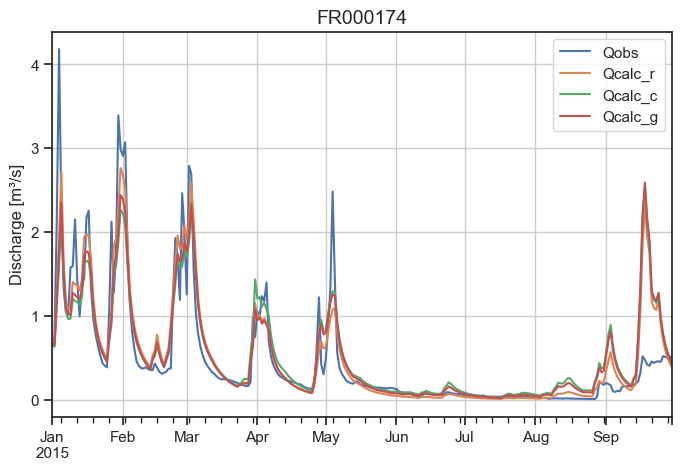

In [312]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR000174"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

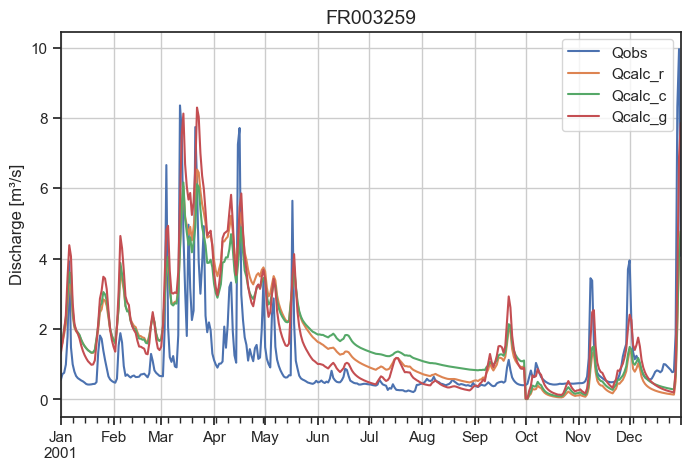

In [317]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003259"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2001"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

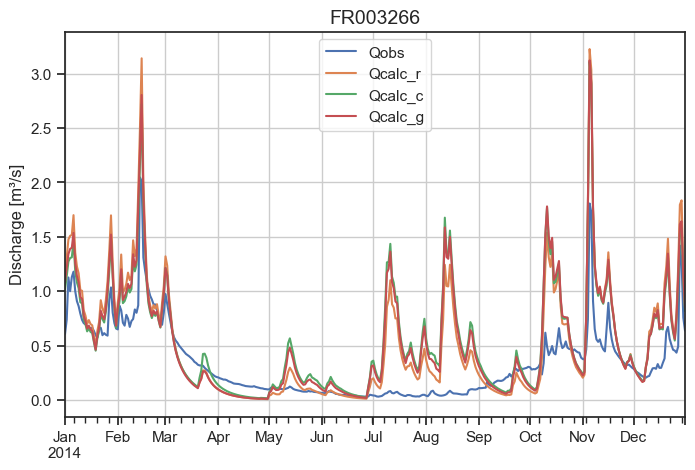

In [319]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003266"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2014"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

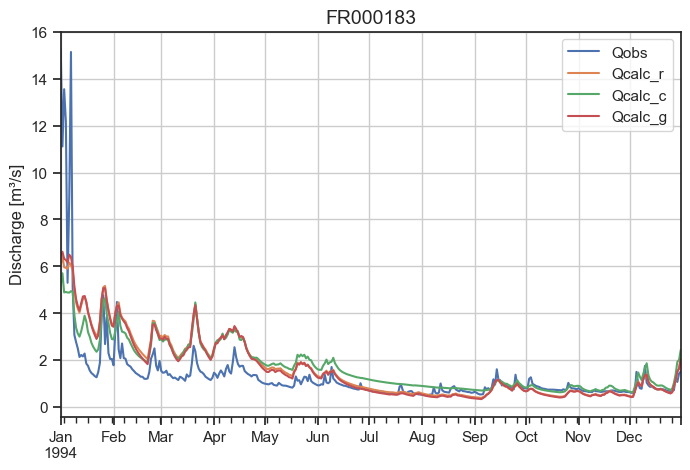

In [334]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR000183"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["1994"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

In [335]:
list_cal

['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [336]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == gauge_id]

gauge_name     basin       nse   bfi_obs   bfi_sim  nse_value_bfi  \
51   A9001050  FR000183  0.813653  0.701242  0.744249            NaN   

    qmean_obs  qmean_sim  slope_obs  slope_sim     hfd_obs     hfd_sim  
51   1.099647   1.045212   1.964987   1.973349  146.272727  149.363636

In [337]:
nse_results_cal_r_1_100

gauge_name     basin        nse   bfi_obs   bfi_sim  nse_value_bfi  \
0          Reuland  BEWA0066   0.848794  0.514795  0.548222       0.864637   
1       Schoenberg  BEWA0067   0.802846  0.448057  0.530274       0.815041   
2       Martelange  BEWA0087 -19.559708  0.715474  0.514520            NaN   
3          Reuland  BEWA0106   0.771835  0.481832  0.549566            NaN   
4    Lommersweiler  BEWA0107   0.733169  0.569622  0.545603            NaN   
..             ...       ...        ...       ...       ...            ...   
107       Michelau  LU000015   0.780712  0.524064  0.544619       0.828639   
108    Pfaffenthal  LU000016   0.672278  0.567054  0.549926       0.446167   
109        Rosport  LU000017   0.865073  0.577206  0.593668       0.885683   
110     Schoenfels  LU000018   0.630301  0.549042  0.658087       0.512632   
111        Vianden  LU000019   0.825056  0.500026  0.554979       0.872502   

     qmean_obs  qmean_sim  slope_obs  slope_sim     hfd_obs     hfd_sim  
0     1.238351   1.163753   3.347668   2.688420  125.769231  131.846154  
1     1.412586   1.264227   3.448610   2.755547  122.307692  131.846154  
2     0.196649   1.218498   1.740044   2.755850  149.666667  125.416667  
3     1.011804   0.901341   4.246454   2.674293  126.153846  132.769231  
4     1.142034   1.248445   3.281075   2.697986  131.250000  134.000000  
..         ...        ...        ...        ...         ...         ...  
107   1.040332   1.017226   4.286267   2.764151  121.769231  128.615385  
108   0.801764   0.740183   2.023796   2.837984  133.615385  130.846154  
109   0.935842   0.893069   2.468492   2.448700  127.307692  133.000000  
110   0.876011   0.789524   2.255653   2.105457  127.384615  139.461538  
111   1.155285   1.080632   3.408979   2.621271  125.846154  132.461538  

[112 rows x 12 columns]

# Visualization of the params

In [16]:
regional_keys_2 = [k for k in all_param_dicts if "regi" in k and is_valid_key_2(k)]
continental_keys_2 = [k for k in all_param_dicts if "cont" in k and is_valid_key_2(k)]
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]


In [ ]:
regional_keys_1 = [k for k in all_param_dicts if "regi" in k and is_valid_key(k)]
continental_keys_1 = [k for k in all_param_dicts if "cont" in k and is_valid_key(k)]
global_keys_1 = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

In [94]:
dfs=[]
for key in regional_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

regional_params_2 = pd.concat(dfs)
regional_params_2.high_snow_k = 1/regional_params_2.high_snow_k
regional_params_2.high_slowhigh_k = 1/regional_params_2.high_slowhigh_k
regional_params_2.general_snow_k = 1/regional_params_2.general_snow_k
regional_params_2.general_slow_k = 1/regional_params_2.general_slow_k
regional_params_2.general_fast_k = 1/regional_params_2.general_fast_k
regional_params_2.low_snow_k = 1/regional_params_2.low_snow_k
regional_params_2.low_fast_k = 1/regional_params_2.low_fast_k

dfs=[]
for key in regional_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

regional_params_1 = pd.concat(dfs)
regional_params_1.high_snow_k = 1/regional_params_1.high_snow_k
regional_params_1.high_slowhigh_k = 1/regional_params_1.high_slowhigh_k
regional_params_1.general_snow_k = 1/regional_params_1.general_snow_k
regional_params_1.general_slow_k = 1/regional_params_1.general_slow_k
regional_params_1.general_fast_k = 1/regional_params_1.general_fast_k
regional_params_1.low_snow_k = 1/regional_params_1.low_snow_k
regional_params_1.low_fast_k = 1/regional_params_1.low_fast_k

regional_params_1

high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
0     0.308461             115.959617             0.825388   
0     0.357143             126.404260             0.858377   
0     0.369213             146.023331             0.668740   
0     0.193287             122.205176             0.834432   
0     0.308616             151.971662             0.957910   
0     0.254093             120.547609             0.860585   
0     0.253457             148.231018             0.791243   

   high_unsaturated_beta  high_slowhigh_k  general_snow_k  \
0               1.655973     22497.093379        0.308461   
0               1.157857     11961.587743        0.357143   
0               2.305365      3728.690425        0.369213   
0               1.630565     67637.793571        0.193287   
0               1.056474     20685.792686        0.308616   
0               1.622552     18580.900267        0.254093   
0               1.076950      3758.952819        0.253457   

   general_unsaturated_Smax  general_unsaturated_Ce  general_unsaturated_beta  \
0                115.959617                0.825388                  1.655973   
0                126.404260                0.858377                  1.157857   
0                146.023331                0.668740                  2.305365   
0                122.205176                0.834432                  1.630565   
0                151.971662                0.957910                  1.056474   
0                120.547609                0.860585                  1.622552   
0                148.231018                0.791243                  1.076950   

   general_lowersplitter_splitpar  general_slow_k  general_lag-fun_lag-time  \
0                        0.137260      357.064361                  2.081892   
0                        0.101083      384.941471                  2.069282   
0                        0.312789      770.799861                  2.147521   
0                        0.174398     2214.670471                  1.982798   
0                        0.126648     2139.150650                  2.090660   
0                        0.111392     2511.281989                  2.159148   
0                        0.119110     1867.465370                  2.069214   

   general_fast_k  low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  \
0       36.166753    0.308461            115.959617            0.825388   
0       23.090690    0.357143            126.404260            0.858377   
0       27.466297    0.369213            146.023331            0.668740   
0       49.726565    0.193287            122.205176            0.834432   
0       36.071616    0.308616            151.971662            0.957910   
0       36.857202    0.254093            120.547609            0.860585   
0       61.179968    0.253457            148.231018            0.791243   

   low_unsaturated_beta  low_fast_k  
0              1.655973  199.141856  
0              1.157857  335.622594  
0              2.305365  394.652992  
0              1.630565  275.481665  
0              1.056474  376.871447  
0              1.622552  407.566734  
0              1.076950  809.055823

In [95]:
dfs=[]
for key in continental_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

continental_params_2 = pd.concat(dfs)
continental_params_2.high_snow_k = 1/continental_params_2.high_snow_k
continental_params_2.high_slowhigh_k = 1/continental_params_2.high_slowhigh_k
continental_params_2.general_snow_k = 1/continental_params_2.general_snow_k
continental_params_2.general_slow_k = 1/continental_params_2.general_slow_k
continental_params_2.general_fast_k = 1/continental_params_2.general_fast_k
continental_params_2.low_snow_k = 1/continental_params_2.low_snow_k
continental_params_2.low_fast_k = 1/continental_params_2.low_fast_k

dfs=[]
for key in continental_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

continental_params_1 = pd.concat(dfs)
continental_params_1.high_snow_k = 1/continental_params_1.high_snow_k
continental_params_1.high_slowhigh_k = 1/continental_params_1.high_slowhigh_k
continental_params_1.general_snow_k = 1/continental_params_1.general_snow_k
continental_params_1.general_slow_k = 1/continental_params_1.general_slow_k
continental_params_1.general_fast_k = 1/continental_params_1.general_fast_k
continental_params_1.low_snow_k = 1/continental_params_1.low_snow_k
continental_params_1.low_fast_k = 1/continental_params_1.low_fast_k

continental_params_1


high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
0     0.321763             140.264651             0.911199   
0     0.342403             131.636228             0.916357   
0     0.313719             131.283071             0.801666   
0     0.243824             149.849794             0.838211   
0     0.290704             135.735555             0.862874   
0     0.343747             113.838766             0.781626   
0     0.323850             167.995986             0.848339   

   high_unsaturated_beta  high_slowhigh_k  general_snow_k  \
0               0.960857      8436.843950        0.321763   
0               0.957559     10976.812737        0.342403   
0               1.336541      7914.546833        0.313719   
0               1.201989     14417.450509        0.243824   
0               1.615824    128519.359384        0.290704   
0               1.699126     15939.315516        0.343747   
0               0.928816      1820.050079        0.323850   

   general_unsaturated_Smax  general_unsaturated_Ce  general_unsaturated_beta  \
0                140.264651                0.911199                  0.960857   
0                131.636228                0.916357                  0.957559   
0                131.283071                0.801666                  1.336541   
0                149.849794                0.838211                  1.201989   
0                135.735555                0.862874                  1.615824   
0                113.838766                0.781626                  1.699126   
0                167.995986                0.848339                  0.928816   

   general_lowersplitter_splitpar  general_slow_k  general_lag-fun_lag-time  \
0                        0.169768       63.139055                  1.971455   
0                        0.207953       77.884258                  2.088247   
0                        0.237759      242.866983                  2.000522   
0                        0.142736      617.652435                  1.954936   
0                        0.141723      864.222663                  2.154522   
0                        0.203490     8267.161375                  2.093653   
0                        0.230726      138.563584                  2.093793   

   general_fast_k  low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  \
0       34.279316    0.321763            140.264651            0.911199   
0       31.053880    0.342403            131.636228            0.916357   
0       52.126906    0.313719            131.283071            0.801666   
0       63.396634    0.243824            149.849794            0.838211   
0       39.079928    0.290704            135.735555            0.862874   
0       44.665910    0.343747            113.838766            0.781626   
0       48.624553    0.323850            167.995986            0.848339   

   low_unsaturated_beta  low_fast_k  
0              0.960857  307.323604  
0              0.957559  346.437421  
0              1.336541  447.176737  
0              1.201989  430.068133  
0              1.615824  449.981167  
0              1.699126  211.749279  
0              0.928816  252.473572

In [96]:
dfs=[]
for key in global_keys_2:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

global_params_2 = pd.concat(dfs)
global_params_2.high_snow_k = 1/global_params_2.high_snow_k
global_params_2.high_slowhigh_k = 1/global_params_2.high_slowhigh_k
global_params_2.general_snow_k = 1/global_params_2.general_snow_k
global_params_2.general_slow_k = 1/global_params_2.general_slow_k
global_params_2.general_fast_k = 1/global_params_2.general_fast_k
global_params_2.low_snow_k = 1/global_params_2.low_snow_k
global_params_2.low_fast_k = 1/global_params_2.low_fast_k

dfs=[]
for key in global_keys_1:
    df = pd.DataFrame.from_dict(all_param_dicts[key], orient="index").T
    dfs.append(df)

global_params_1 = pd.concat(dfs)
global_params_1.high_snow_k = 1/global_params_1.high_snow_k
global_params_1.high_slowhigh_k = 1/global_params_1.high_slowhigh_k
global_params_1.general_snow_k = 1/global_params_1.general_snow_k
global_params_1.general_slow_k = 1/global_params_1.general_slow_k
global_params_1.general_fast_k = 1/global_params_1.general_fast_k
global_params_1.low_snow_k = 1/global_params_1.low_snow_k
global_params_1.low_fast_k = 1/global_params_1.low_fast_k

global_params_1


high_snow_k  high_unsaturated_Smax  high_unsaturated_Ce  \
0     0.293818             138.428712             0.837622   
0     0.432110             108.303251             0.843992   
0     0.318779             137.601256             0.772260   
0     0.359078             124.797735             0.789234   
0     0.316622             156.324559             1.013008   
0     0.144365             126.395162             0.773205   
0     0.221042             117.665932             0.794341   

   high_unsaturated_beta  high_slowhigh_k  general_snow_k  \
0               1.210910      5813.926059        0.293818   
0               1.679087    179208.662748        0.432110   
0               1.491567      1749.868169        0.318779   
0               1.732492     37694.943860        0.359078   
0               0.939485     12613.386548        0.316622   
0               1.744278     13053.455260        0.144365   
0               1.372826     18042.723664        0.221042   

   general_unsaturated_Smax  general_unsaturated_Ce  general_unsaturated_beta  \
0                138.428712                0.837622                  1.210910   
0                108.303251                0.843992                  1.679087   
0                137.601256                0.772260                  1.491567   
0                124.797735                0.789234                  1.732492   
0                156.324559                1.013008                  0.939485   
0                126.395162                0.773205                  1.744278   
0                117.665932                0.794341                  1.372826   

   general_lowersplitter_splitpar  general_slow_k  general_lag-fun_lag-time  \
0                        0.117833      450.155335                  2.000603   
0                        0.147249      106.492237                  2.017564   
0                        0.273415      490.629344                  2.014792   
0                        0.135211     1122.129426                  1.820569   
0                        0.133497      694.670187                  2.043009   
0                        0.171432     4116.340412                  2.181077   
0                        0.120218     2378.928632                  1.943384   

   general_fast_k  low_snow_k  low_unsaturated_Smax  low_unsaturated_Ce  \
0       41.864554    0.293818            138.428712            0.837622   
0       35.038536    0.432110            108.303251            0.843992   
0       37.173257    0.318779            137.601256            0.772260   
0       57.864486    0.359078            124.797735            0.789234   
0       47.969664    0.316622            156.324559            1.013008   
0       47.167119    0.144365            126.395162            0.773205   
0       72.842615    0.221042            117.665932            0.794341   

   low_unsaturated_beta  low_fast_k  
0              1.210910  842.321786  
0              1.679087  364.242633  
0              1.491567  674.066800  
0              1.732492  302.072621  
0              0.939485  578.870322  
0              1.744278  360.266816  
0              1.372826  456.141835

In [ ]:
import warnings
warnings.filterwarnings("ignore")

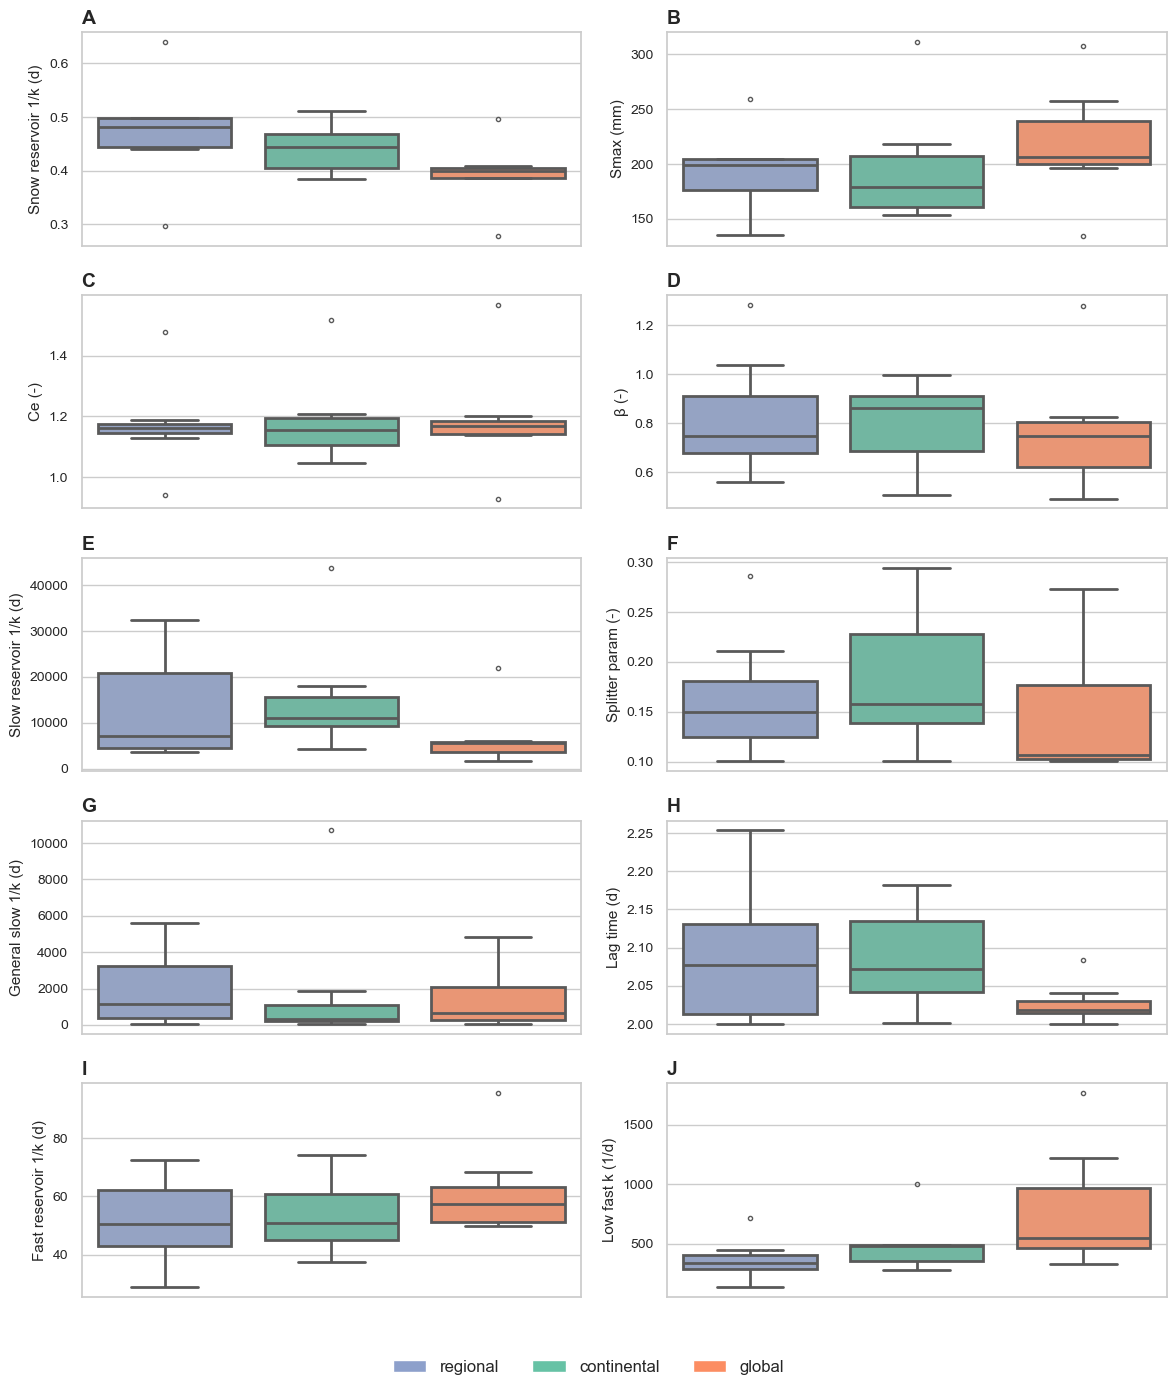

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

subplot_titles = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # Enough for 26 variables


# Seaborn styling
sns.set_theme(style="whitegrid", font_scale=1.2)

# Prepare long-format data
def prepare_long_df(df, name):
    df_long = df.copy()
    df_long['source'] = name
    return df_long

regional_long = prepare_long_df(regional_params_2, 'regional')
continental_long = prepare_long_df(continental_params_2, 'continental')
global_long = prepare_long_df(global_params_2, 'global')

all_long = pd.concat([regional_long, continental_long, global_long], axis=0)
all_long = all_long.melt(id_vars='source', var_name='variable', value_name='value')

# Colors for groups
palette = {
    'regional': '#8da0cb',     # blue
    'continental': '#66c2a5',  # green
    'global': '#fc8d62'        # orange
}

# Variables to plot
variables = [
    'high_snow_k', 
    'high_unsaturated_Smax', 
    'high_unsaturated_Ce',
    'high_unsaturated_beta', 
    'high_slowhigh_k', 
    'general_lowersplitter_splitpar',
    'general_slow_k', 
    'general_lag-fun_lag-time', 
    'general_fast_k',
    'low_fast_k'
]


# Pretty labels for y-axes
pretty_labels = {
    'high_snow_k': 'Snow reservoir 1/k (d)',#
    'high_unsaturated_Smax': 'Smax (mm)',#
    'high_unsaturated_Ce': 'Ce (-)',#
    'high_unsaturated_beta': 'β (-)',#
    'high_slowhigh_k': 'Slow reservoir 1/k (d)',#
    'general_lowersplitter_splitpar': 'Splitter param (-)',#
    'general_slow_k': 'General slow 1/k (d)',#
    'general_lag-fun_lag-time': 'Lag time (d)',#
    'general_fast_k': 'Fast reservoir 1/k (d)',#
    'low_fast_k': 'Low fast k (1/d)'#
}

# Layout
ncols = 2
nrows = int(np.ceil(len(variables) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14), sharey=False)
axes = axes.flatten()

# Plot
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(
        data=all_long[all_long['variable'] == var],
        x='source', y='value',
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        ax=ax
    )
    ax.set_title(subplot_titles[i], fontsize=14, weight='bold', loc="left")  # "A", "B", ...
    ax.set_xlabel('')
    ax.set_ylabel(pretty_labels.get(var, var), fontsize=11)
    ax.set_xticks([])  # remove x-axis group labels
    ax.tick_params(labelsize=10)

# Hide unused axes
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Custom legend
legend_elements = [
    Patch(facecolor=palette['regional'], label='regional'),
    Patch(facecolor=palette['continental'], label='continental'),
    Patch(facecolor=palette['global'], label='global')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\boxplots_params.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

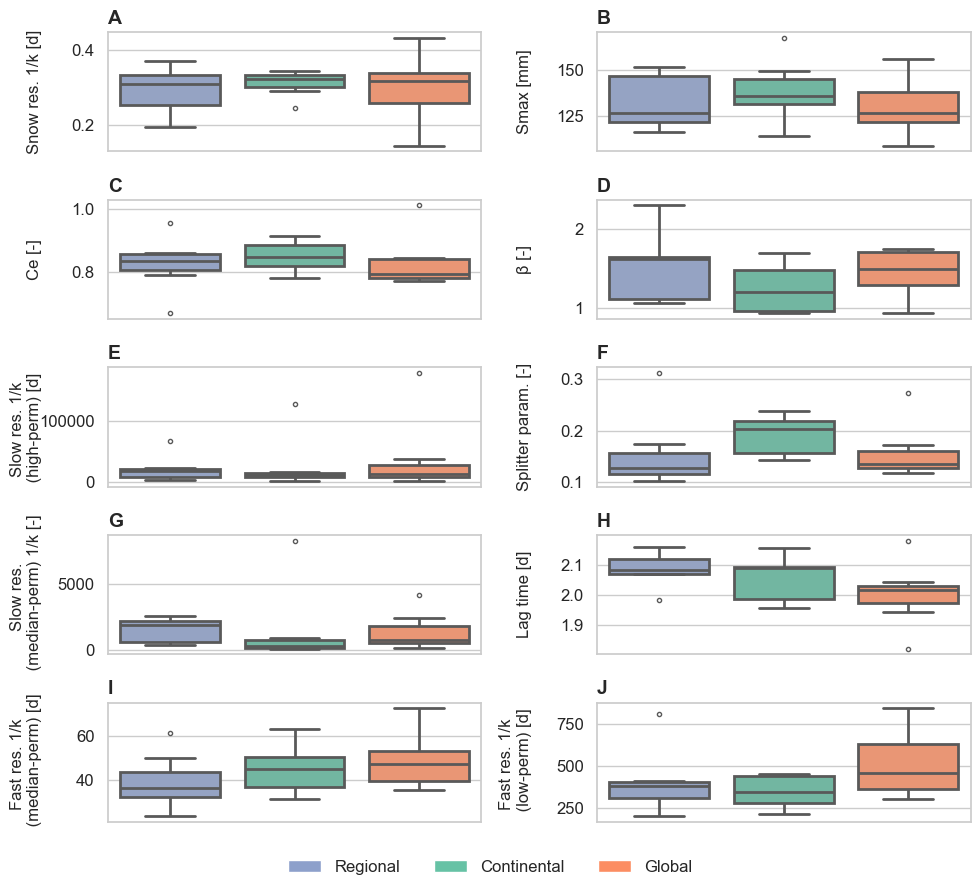

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

subplot_titles = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # Enough for 26 variables


# Seaborn styling
sns.set_theme(style="whitegrid", font_scale=1.2)

# Prepare long-format data
def prepare_long_df(df, name):
    df_long = df.copy()
    df_long['source'] = name
    return df_long

regional_long = prepare_long_df(regional_params_1, 'Regional')
continental_long = prepare_long_df(continental_params_1, 'Continental')
global_long = prepare_long_df(global_params_1, 'Global')

all_long = pd.concat([regional_long, continental_long, global_long], axis=0)
all_long = all_long.melt(id_vars='source', var_name='variable', value_name='value')

# Colors for groups
palette = {
    'Regional': '#8da0cb',     # blue
    'Continental': '#66c2a5',  # green
    'Global': '#fc8d62'        # orange
}

# Variables to plot
variables = [
    'high_snow_k', 
    'high_unsaturated_Smax', 
    'high_unsaturated_Ce',
    'high_unsaturated_beta', 
    'high_slowhigh_k', 
    'general_lowersplitter_splitpar',
    'general_slow_k', 
    'general_lag-fun_lag-time', 
    'general_fast_k',
    'low_fast_k'
]


# Pretty labels for y-axes
pretty_labels = {
    'high_snow_k': 'Snow res. 1/k [d]',#
    'high_unsaturated_Smax': 'Smax [mm]',#
    'high_unsaturated_Ce': 'Ce [-]',#
    'high_unsaturated_beta': 'β [-]',#
    'high_slowhigh_k': 'Slow res. 1/k \n (high-perm) [d] ',#
    'general_lowersplitter_splitpar': 'Splitter param. [-]',#
    'general_slow_k': 'Slow res. \n (median-perm) 1/k [-]',#
    'general_lag-fun_lag-time': 'Lag time [d]',#
    'general_fast_k': 'Fast res. 1/k \n (median-perm) [d]',#
    'low_fast_k': 'Fast res. 1/k \n (low-perm) [d]'#
}

# Layout
ncols = 2
nrows = int(np.ceil(len(variables) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 9), sharey=False)
axes = axes.flatten()

# Plot
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(
        data=all_long[all_long['variable'] == var],
        x='source', y='value',
        palette=palette,
        linewidth=2.0,
        fliersize=3,
        ax=ax
    )
    ax.set_title(subplot_titles[i], fontsize=14, weight='bold', loc="left")  # "A", "B", ...
    ax.set_xlabel('')
    ax.set_ylabel(pretty_labels.get(var, var), fontsize=12)
    ax.set_xticks([])  # remove x-axis group labels
    ax.tick_params(labelsize=12)

# Hide unused axes
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Custom legend
legend_elements = [
    Patch(facecolor=palette['Regional'], label='Regional'),
    Patch(facecolor=palette['Continental'], label='Continental'),
    Patch(facecolor=palette['Global'], label='Global')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

# Align all y-axis labels
for ax in axes:
    ax.yaxis.set_label_coords(-0.175, 0.5)  # adjust -0.15 as needed
    
plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig(r"C:\Users\nascimth\OneDrive - Eawag\Eawag\Papers\Moselle_superflexpy\GitHub\estreams_superflexpy\results\figs\boxplots_params_1.png", dpi=300)  # You can change the filename or format (e.g., .pdf, .svg)

plt.show()

# Use one set of params to the other

In [ ]:
path_inputs = '../data/models/input/subset_2001_2015'
inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
global_keys = [k for k in all_param_dicts if "glob" in k and is_valid_key(k)]

output_global_dict_regigeo = {}


for key in tqdm.tqdm(global_keys):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_global_dict_regigeo[key] = output


path_inputs = '../data/models/input/subset_1988_2001'
inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

# Filter keys
global_keys_2 = [k for k in all_param_dicts if "glob" in k and is_valid_key_2(k)]

output_global_dict_regigeo_8801 = {}

for key in tqdm.tqdm(global_keys_2):
    output = run_model_superflexpy(
        catchments_ids=catchments_ids,
        best_params_dict_model=all_param_dicts[key],
        perm_areas_model=perm_areas
    )
    output_global_dict_regigeo_8801[key] = output


# Create the concatenated data for the complete series analysis
path_inputs = '../data/models/input/subset_1988_2001'
observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'
observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

In [38]:
output_global_dict_regigeo_cal = {}

for param_key in output_global_dict_regigeo:
    param_key_8801 = param_key + "_2"

    if param_key_8801 in output_global_dict_regigeo_8801:
        merged_outputs = {}

        for gauge_id in output_global_dict_regigeo[param_key]:
            if gauge_id in output_global_dict_regigeo_8801[param_key_8801]:
                # Ensure both arrays are flat (1D)
                series_8801 = np.ravel(output_global_dict_regigeo_8801[param_key_8801][gauge_id])
                series_recent = np.ravel(output_global_dict_regigeo[param_key][gauge_id])
                concatenated = np.concatenate([series_8801, series_recent])
                merged_outputs[gauge_id] = [concatenated]

        output_global_dict_regigeo_cal[param_key] = merged_outputs


date_range = pd.date_range("1988-10-01", "2015-09-30", freq="D")

nse_results_global_dict_calregigeo = {}
for key in tqdm.tqdm(output_global_dict_regigeo_cal):
    nse_results_global_dict_calregigeo[key] = generate_nse_results(
        catchments_ids,
        date_range,
        output_global_dict_regigeo_cal[key],
        observations_cal,
        quality_masks_cal
    )
    nse_results_global_dict_calregigeo[key].drop_duplicates(subset='basin', keep='first', inplace=True)

100%|██████████| 7/7 [01:03<00:00,  9.07s/it]


In [53]:
nse_results_global_dict_calregigeo["moselle_best_params_glob_Group_1"].corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_15792\2921404408.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_global_dict_calregigeo["moselle_best_params_glob_Group_1"].corr()


nse   bfi_obs   bfi_sim  nse_value_bfi  qmean_obs  \
nse            1.000000 -0.405711 -0.271235       0.974768   0.042742   
bfi_obs       -0.405711  1.000000  0.572113      -0.542408   0.067962   
bfi_sim       -0.271235  0.572113  1.000000      -0.607851   0.029588   
nse_value_bfi  0.974768 -0.542408 -0.607851       1.000000   0.276281   
qmean_obs      0.042742  0.067962  0.029588       0.276281   1.000000   
qmean_sim      0.068591  0.061295  0.103501       0.220019   0.949894   
slope_obs      0.213694 -0.716254 -0.403770       0.473767  -0.006449   
slope_sim      0.152008 -0.516009 -0.911471       0.501579   0.060929   
hfd_obs       -0.618962  0.845981  0.569909      -0.670239   0.027007   
hfd_sim       -0.443081  0.504684  0.843550      -0.679981  -0.179392   

               qmean_sim  slope_obs  slope_sim   hfd_obs   hfd_sim  
nse             0.068591   0.213694   0.152008 -0.618962 -0.443081  
bfi_obs         0.061295  -0.716254  -0.516009  0.845981  0.504684  
bfi_sim         0.103501  -0.403770  -0.911471  0.569909  0.843550  
nse_value_bfi   0.220019   0.473767   0.501579 -0.670239 -0.679981  
qmean_obs       0.949894  -0.006449   0.060929  0.027007 -0.179392  
qmean_sim       1.000000   0.021123  -0.021281  0.015991 -0.137989  
slope_obs       0.021123   1.000000   0.551987 -0.610688 -0.414104  
slope_sim      -0.021281   0.551987   1.000000 -0.510446 -0.801182  
hfd_obs         0.015991  -0.610688  -0.510446  1.000000  0.650557  
hfd_sim        -0.137989  -0.414104  -0.801182  0.650557  1.000000

In [54]:
data_diff_cal_complete_dict["Group_1"].corr()

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
nse         1.000000  0.061224  0.240844 -0.040089  0.210574    0.302402   
nse_rg      0.061224  1.000000  0.203715  0.192090 -0.249801   -0.319864   
nse_r1      0.240844  0.203715  1.000000  0.960128  0.897104    0.971548   
nse_c1     -0.040089  0.192090  0.960128  1.000000  0.862916    0.963392   
nse_g1      0.210574 -0.249801  0.897104  0.862916  1.000000    0.950829   
nse_bfi_r1  0.302402 -0.319864  0.971548  0.963392  0.950829    1.000000   
nse_bfi_c1  0.133009 -0.288811  0.941920  0.962451  0.918276    0.978583   
nse_bfi_g1  0.321222 -0.505646  0.970274  0.958717  0.980685    0.969670   
bfi_obs    -0.119907 -0.271050 -0.443854 -0.422411 -0.316668   -0.607621   
bfi_r1      0.121757 -0.310020 -0.259256 -0.301975 -0.116507   -0.707432   
bfi_c1      0.210214 -0.138596 -0.244184 -0.311937 -0.178961   -0.685805   
bfi_g1     -0.200932  0.444429 -0.026548  0.030545 -0.226821   -0.410208   
qmean_obs  -0.181224 -0.219597  0.007996  0.060431  0.107009    0.277086   
qmean_r1   -0.128703 -0.186783  0.045478  0.083892  0.129272    0.207326   
qmean_c1   -0.127011 -0.192337  0.044120  0.082006  0.130435    0.207310   
qmean_g1   -0.129798 -0.190713  0.043167  0.081827  0.128759    0.203828   
slope_obs  -0.054523  0.474086  0.271143  0.294847  0.054224    0.534943   
slope_r1   -0.240213  0.475311  0.175083  0.249438 -0.041336    0.561387   
slope_c1   -0.179445  0.239396  0.225954  0.284307  0.115442    0.551763   
slope_g1    0.091412 -0.374710 -0.114503 -0.144211  0.055852    0.296926   
hfd_obs    -0.190075 -0.311388 -0.557150 -0.518838 -0.410518   -0.725528   
hfd_r1      0.049439 -0.324165 -0.408622 -0.434917 -0.257852   -0.811819   
hfd_c1      0.180287 -0.146337 -0.383172 -0.446406 -0.312932   -0.756070   
hfd_g1     -0.156449  0.537297 -0.081856 -0.039208 -0.323432   -0.499110   

            nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  \
nse           0.133009    0.321222 -0.119907  0.121757  ... -0.127011   
nse_rg       -0.288811   -0.505646 -0.271050 -0.310020  ... -0.192337   
nse_r1        0.941920    0.970274 -0.443854 -0.259256  ...  0.044120   
nse_c1        0.962451    0.958717 -0.422411 -0.301975  ...  0.082006   
nse_g1        0.918276    0.980685 -0.316668 -0.116507  ...  0.130435   
nse_bfi_r1    0.978583    0.969670 -0.607621 -0.707432  ...  0.207310   
nse_bfi_c1    1.000000    0.939590 -0.594288 -0.716336  ...  0.221501   
nse_bfi_g1    0.939590    1.000000 -0.595258 -0.620069  ...  0.237583   
bfi_obs      -0.594288   -0.595258  1.000000  0.657429  ...  0.018086   
bfi_r1       -0.716336   -0.620069  0.657429  1.000000  ... -0.167133   
bfi_c1       -0.676066   -0.601909  0.457019  0.860198  ... -0.307944   
bfi_g1       -0.407844   -0.475672  0.342999  0.362962  ...  0.070110   
qmean_obs     0.290791    0.287630  0.021818 -0.241156  ...  0.953712   
qmean_r1      0.222228    0.238123  0.017155 -0.168161  ...  0.999925   
qmean_c1      0.221501    0.237583  0.018086 -0.167133  ...  1.000000   
qmean_g1      0.218629    0.235888  0.020236 -0.164715  ...  0.999889   
slope_obs     0.547152    0.466171 -0.725891 -0.675794  ...  0.029914   
slope_r1      0.597701    0.459887 -0.574850 -0.864209  ...  0.253434   
slope_c1      0.558234    0.425727 -0.372173 -0.754260  ...  0.413314   
slope_g1      0.323365    0.349638 -0.275724 -0.337346  ... -0.131693   
hfd_obs      -0.715422   -0.738375  0.893271  0.651697  ... -0.038554   
hfd_r1       -0.823675   -0.745763  0.604282  0.915901  ... -0.197468   
hfd_c1       -0.756690   -0.679111  0.429601  0.777380  ... -0.327725   
hfd_g1       -0.502434   -0.591366  0.227825  0.287996  ... -0.093972   

            qmean_g1  slope_obs  slope_r1  slope_c1  slope_g1   hfd_obs  \
nse        -0.129798  -0.054523 -0.240213 -0.179445  0.091412 -0.190075   
nse_rg     -0.190713   0.474086  0.475311  0.239396 -0.374710 -0.311388   
nse_r1      0.043167   0.271143  0.175083  0.225954 -0.114503 -0.

In [ ]:




data_diff_cal_complete_dictregigeo = {}

groups_list = [1,2,3, 4,5,6,7]

for number_group in groups_list:

    Group_number = f"Group_"+str(number_group)

    nse_results_cal_r_1_100_complete_cal = nse_results_regional_dict_cal[f"moselle_best_params_regi_Group_{number_group}"]
    nse_results_cal_c_1_100_complete_cal = nse_results_global_dict_calregigeo[f"moselle_best_params_glob_Group_{number_group}"]
    nse_results_cal_g_1_100_complete_cal = nse_results_global_dict_cal[f"moselle_best_params_glob_Group_{number_group}"]


    list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == Group_number].index.tolist()

    # Remove strings starting with 'LU'
    list_cal = [g for g in list_cal if not g.startswith("LU")]


    data_diff_cal_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_c_1_100_complete_cal.nse)
    data_diff_cal_complete["nse_rg"] = nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_g_1_100_complete_cal.nse

    data_diff_cal_complete.index = nse_results_cal_c_1_100_complete_cal.basin

    data_diff_cal_complete = data_diff_cal_complete.loc[~data_diff_cal_complete.index.isin(list_cal)]

    data_diff_cal_complete["nse_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse
    data_diff_cal_complete["nse_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse
    data_diff_cal_complete["nse_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse

    data_diff_cal_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
    data_diff_cal_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
    data_diff_cal_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

    data_diff_cal_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_obs
    data_diff_cal_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
    data_diff_cal_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
    data_diff_cal_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim

    data_diff_cal_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_obs
    data_diff_cal_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
    data_diff_cal_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
    data_diff_cal_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim

    data_diff_cal_complete["slope_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_obs
    data_diff_cal_complete["slope_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
    data_diff_cal_complete["slope_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
    data_diff_cal_complete["slope_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).slope_sim

    data_diff_cal_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_obs
    data_diff_cal_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
    data_diff_cal_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
    data_diff_cal_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim

    data_diff_cal_complete_dictregigeo[Group_number] = data_diff_cal_complete

100%|██████████| 7/7 [02:15<00:00, 19.42s/it]
0it [00:00, ?it/s]


NameError: name 'nse_results_regional_dict_cal' is not defined

In [29]:
global_keys_2

['moselle_best_params_glob_Group_1_2',
 'moselle_best_params_glob_Group_2_2',
 'moselle_best_params_glob_Group_3_2',
 'moselle_best_params_glob_Group_4_2',
 'moselle_best_params_glob_Group_5_2',
 'moselle_best_params_glob_Group_6_2',
 'moselle_best_params_glob_Group_7_2']

## Discussion with Gnann
- Check the parameters. Plot them for example to see. The variability should be bigger between groups than within.
- Use the parameters form the global with the correct geology: to see what is the problem? 
- Check the catchments where there is the very high PROBLEM (fdc flope)
- How dificult would be to improve the model for the Garone? If it would be relativelly easier, how does it work?
- LSTM?
- Can you look inside the LSTMs and see if is there a BF ts?

# End